In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%reload_ext nb_black

<IPython.core.display.Javascript object>

# ResNet

## Import

In [2]:
import sys

sys.path.insert(0, "../src")

<IPython.core.display.Javascript object>

In [3]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import scipy
from sklearn import metrics
from sklearn import model_selection

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchcontrib
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

torch.backends.cudnn.benchmark = True

import albumentations as A
from iterstrat import ml_stratifiers

import dataset
import engine
import models
import optimizers
import utils

<IPython.core.display.Javascript object>

In [4]:
SEED = 42
utils.seed_everything(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available else "cpu")

<IPython.core.display.Javascript object>

## Data

In [5]:
DATA_PATH = Path("../input")
df = pd.read_csv(DATA_PATH / "train.csv")
df.head()

id  digit letter  0  1  2  3  4  5  6  ...  774  775  776  777  778  779  \
0   1      5      L  1  1  1  4  3  0  0  ...    2    1    0    1    2    4   
1   2      0      B  0  4  0  0  4  1  1  ...    0    3    0    1    4    1   
2   3      4      L  1  1  2  2  1  1  1  ...    3    3    3    0    2    0   
3   4      9      D  1  2  0  2  0  4  0  ...    3    3    2    0    1    4   
4   5      6      A  3  0  2  4  0  3  0  ...    4    4    3    2    1    3   

   780  781  782  783  
0    4    4    3    4  
1    4    2    1    2  
2    3    0    2    2  
3    0    0    1    1  
4    4    3    1    2  

[5 rows x 787 columns]

<IPython.core.display.Javascript object>

## Model

In [6]:
def init_cnn(m):
    if getattr(m, "bias", None) is not None:
        nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
    for l in m.children():
        init_cnn(l)

<IPython.core.display.Javascript object>

In [7]:
sigmoid = torch.nn.Sigmoid()


class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


swish = Swish.apply


class Swish_module(nn.Module):
    def forward(self, x):
        return swish(x)


swish_layer = Swish_module()


def relu_fn(x):
    """ Swish activation function """
    # return x * torch.sigmoid(x)
    return swish_layer(x)

<IPython.core.display.Javascript object>

### ResNet

In [8]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False
    )


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBlock(nn.Module):
    """Pre-activation version of the BasicBlock"""

    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)

        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                )
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        x = F.relu(self.bn1(x))
        shortcut = self.shortcut(x)
        x = self.conv1(x)
        out = self.conv2(F.relu(self.bn2(x)))
        out += shortcut
        return out


class Bottleneck(nn.Module):
    """Pre-activation version of the original Bottleneck module."""

    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion * planes, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

<IPython.core.display.Javascript object>

In [9]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(1, 64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(1024 * block.expansion, num_classes)
        init_cnn(self)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        avg_feats = F.adaptive_avg_pool2d(x, output_size=1)
        max_feats = F.adaptive_max_pool2d(x, output_size=1)
        x = torch.cat([avg_feats, max_feats], dim=1)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x


def ResNet18():
    return ResNet(PreActBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

<IPython.core.display.Javascript object>

### XResNet

In [38]:
def conv(ni, nf, kernel_size=3, stride=1, bias=False):
    """Creats a convolutional layer for `XResNet`"""
    return nn.Conv2d(
        ni,
        nf,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
        bias=bias,
    )


def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    """Creates a convolutional block for `XResNet`."""
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0.0 if zero_bn else 1.0)
    layers = [
        conv(ni, nf, ks, stride=stride),
        bn,
    ]
    if act:
        layers.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layers)


class XResBlock(nn.Module):
    """Creates the standard `XResNet` block."""

    def __init__(self, expansion, ni, nh, stride=1):
        super(XResBlock, self).__init__()
        ni, nf = ni * expansion, nh * expansion
        layers = [conv_layer(ni, nh, 1)]
        layers += (
            [conv_layer(nh, nf, 3, stride=stride, zero_bn=True, act=False)]
            if expansion == 1
            else [
                conv_layer(nh, nh, 3, stride=stride),
                conv_layer(nh, nf, 1, zero_bn=True, act=False),
            ]
        )
        self.convs = nn.Sequential(*layers)
        self.idconv = nn.Identity() if ni == nf else conv_layer(ni, nf, 1)
        self.pool = nn.Identity() if stride == 1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        return F.relu(self.convs(x) + self.pool(self.idconv(x)))

<IPython.core.display.Javascript object>

In [39]:
class XResNet(nn.Sequential):
    def __init__(self, expansion, layers, num_classes=10):
        #         stem = [conv_layer(1, 16), conv_layer(16, 32), conv_layer(32, 64)]
        stem = [
            conv_layer(1, 64),
        ]

        block_szs = [64 // expansion, 64, 128, 256, 512]
        blocks = [
            self._make_layer(
                expansion,
                block_szs[i],
                block_szs[i + 1],
                blocks=l,
                stride=1 if i == 0 else 2,
            )
            for i, l in enumerate(layers)
        ]
        super().__init__(
            *stem,
            *blocks,
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(block_szs[-1] * expansion, num_classes),
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[
                XResBlock(expansion, ni if i == 0 else nf, nf, stride if i == 0 else 1)
                for i in range(blocks)
            ]
        )


def XResNet18(**kwargs):
    return XResNet(1, [2, 2, 2, 2], **kwargs)


def XResNet34(**kwargs):
    return XResNet(1, [3, 4, 6, 3], **kwargs)


def XResNet50(**kwargs):
    return XResNet(4, [3, 4, 6, 3], **kwargs)


def XResNet101(**kwargs):
    return XResNet(4, [3, 4, 23, 3], **kwargs)


def XResNet152(**kwargs):
    return XResNet(4, [3, 8, 36, 3], **kwargs)

<IPython.core.display.Javascript object>

## Train

In [10]:
def get_model(model_name):
    """Get model."""
    if model_name == "resnet18":
        model = ResNet18()
    elif model_name == "resnet34":
        model = ResNet34()
    elif model_name == "resnet50":
        model = ResNet50()
    elif model_name == "xresnet18":
        model = XResNet18()
    elif model_name == "xresnet34":
        model = XResNet34()
    elif model_name == "xresnet50":
        model = XResNet50()
    elif model_name == "efficientnetb0":
        model = models.EfficientNetB0()
    else:
        raise RuntimeError("Unknown model name:", model_name)

    return model


def get_optimizer(optim_name, model, lr, skip_list=["bias", "bn"]):
    """Get optimizer."""
    params = []
    exclude_params = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        elif any(skip in name for skip in skip_list):
            exclude_params.append(param)
        else:
            params.append(param)

    optim_params = [
        {"params": params, "weight_decay": wd},
        {"params": exclude_params, "weight_decay": 0.0},
    ]
    if optim_name == "radam":
        optimizer = optimizers.RAdam(optim_params, lr=lr)
    elif optim_name == "adam":
        optimizer = torch.optim.Adam(optim_params, lr=lr)
    else:
        raise RuntimeError("Unknown optimizer:", optim_name)

    return optimizer

<IPython.core.display.Javascript object>

In [11]:
def run(
    model_name,
    optim_name,
    epochs,
    lr,
    wd,
    augs=None,
    label_smooth=True,
    mixup=False,
    cutmix=False,
    device=DEVICE,
    swa=False,
    swa_lr=4e-4,
):
    oof = np.zeros((len(df), 10))
    targs = np.zeros(len(df))

    for fold in range(5):
        train_indices = np.load(DATA_PATH / f"train_idx-fold{fold}.npy")
        valid_indices = np.load(DATA_PATH / f"valid_idx-fold{fold}.npy")
        train_dataset = dataset.EMNISTDataset(df, train_indices, augs=augs)
        valid_dataset = dataset.EMNISTDataset(df, valid_indices)
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True
        )
        valid_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=256, num_workers=4, pin_memory=True
        )

        model = get_model(model_name).to(device)
        optimizer = get_optimizer(optim_name, model, lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        scaler = torch.cuda.amp.GradScaler()

        if swa:
            swa_start = int(epochs * 0.75)
            steps_per_epoch = len(train_dataset) // 64
            optimizer = torchcontrib.optim.SWA(
                optimizer,
                swa_start=swa_start * steps_per_epoch,
                swa_freq=steps_per_epoch,
                swa_lr=swa_lr,
            )

        train_accuracies = []
        valid_accuracies = []

        for epoch in range(epochs):
            # Train
            train_loss, train_accuracy = engine.train(
                train_loader,
                model,
                optimizer,
                device,
                scaler,
                label_smooth=label_smooth,
                mixup=mixup,
                cutmix=cutmix,
            )
            train_accuracies.append(train_accuracy)
            scheduler.step()

            # Validate
            valid_probs, valid_targs, valid_loss, valid_accuracy = engine.evaluate(
                valid_loader, model, device
            )
            valid_accuracies.append(valid_accuracy)
            if epoch % 10 == 0:
                print(
                    f"Epoch={epoch}, Train loss={train_loss:.5f}, Valid loss={valid_loss:.5f}, Train Accuracy={train_accuracy:.5f}, Validation Accuracy={valid_accuracy:.5f}"
                )

        if swa:
            optimizer.swap_swa_sgd()
            optimizer.bn_update(train_loader, model, device)

        valid_probs, valid_targs, valid_loss, valid_accuracy = engine.evaluate(
            valid_loader, model, device
        )
        print(
            f"Fold={fold}, Valid loss={valid_loss:.5f}, Valid Accuracy={valid_accuracy:.5f}"
        )

        # oof prediction
        oof[valid_indices] = scipy.special.softmax(valid_probs, axis=1)
        targs[valid_indices] = valid_targs

        # Save model
        checkpoint = (
            f"./models/swa_{model_name}_fold{fold}.pth"
            if swa
            else f"./models/{model_name}_fold{fold}.pth"
        )
        torch.save(model.state_dict(), checkpoint)

        # Plot training curve
        rng = np.arange(len(train_accuracies))
        plt.plot(rng, train_accuracies, label="Train")
        plt.plot(rng, valid_accuracies, label="Validation")
        plt.title(f"Training curve for fold{fold}")
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
        plt.legend()
        plt.show()

    # Confusion matrix
    conf = metrics.confusion_matrix(targs, np.argmax(oof, axis=1))
    plt.figure(figsize=(9, 7))
    sns.heatmap(conf, cmap="coolwarm", annot=True, fmt="d")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

    # Classification report
    print(metrics.classification_report(targs, np.argmax(oof, axis=1)))

    return oof, targs

<IPython.core.display.Javascript object>

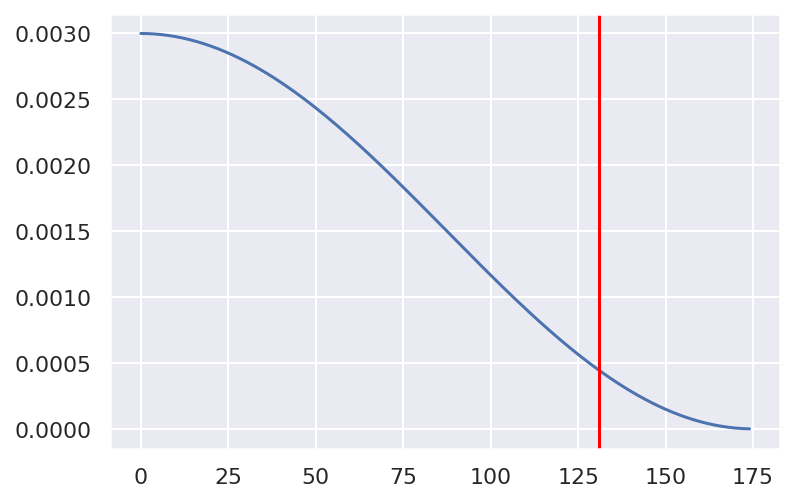

<IPython.core.display.Javascript object>

In [110]:
optimizer = torch.optim.SGD([torch.tensor(1)], lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

lrs = []
for _ in range(epochs):
    optimizer.step()
    lrs.append(scheduler.get_last_lr())
    scheduler.step()

plt.plot(lrs)
plt.axvline(x=int(0.75 * epochs), color="red")
plt.show()

### 1.0

Epoch=0, Train loss=6.91973, Valid loss=8118.68703, Train Accuracy=0.10613, Validation Accuracy=0.10024
Epoch=10, Train loss=2.95821, Valid loss=1215.03387, Train Accuracy=0.18735, Validation Accuracy=0.11491
Epoch=20, Train loss=2.48288, Valid loss=1.87936, Train Accuracy=0.25956, Validation Accuracy=0.42543
Epoch=30, Train loss=2.26061, Valid loss=2.23030, Train Accuracy=0.37623, Validation Accuracy=0.48411
Epoch=40, Train loss=2.17843, Valid loss=1.70252, Train Accuracy=0.37396, Validation Accuracy=0.49633
Epoch=50, Train loss=2.04682, Valid loss=1.26328, Train Accuracy=0.41665, Validation Accuracy=0.65770
Epoch=60, Train loss=2.14560, Valid loss=1.32239, Train Accuracy=0.37559, Validation Accuracy=0.74328
Epoch=70, Train loss=1.99306, Valid loss=1.08517, Train Accuracy=0.42412, Validation Accuracy=0.74817
Epoch=80, Train loss=1.49899, Valid loss=0.85143, Train Accuracy=0.67522, Validation Accuracy=0.78973
Epoch=90, Train loss=2.00820, Valid loss=1.31516, Train Accuracy=0.44180, Val

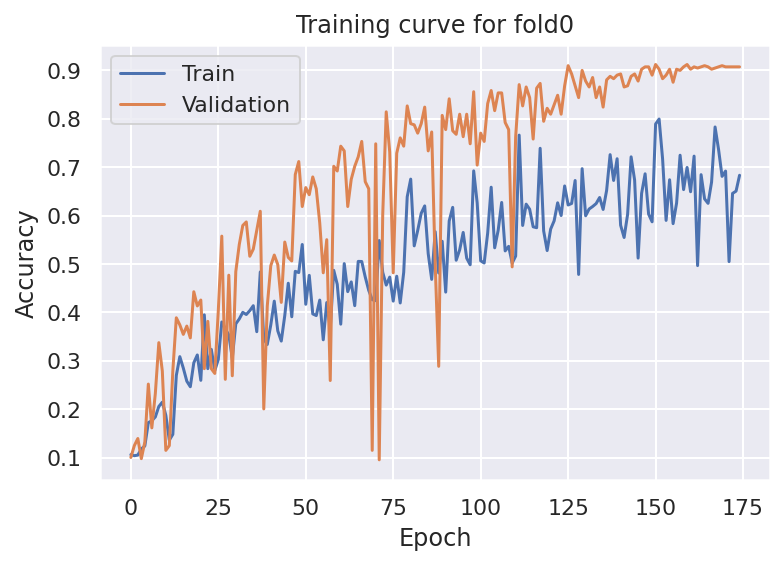

Epoch=0, Train loss=6.47939, Valid loss=1020.96630, Train Accuracy=0.09670, Validation Accuracy=0.09512
Epoch=10, Train loss=2.47352, Valid loss=2.27136, Train Accuracy=0.25438, Validation Accuracy=0.31951
Epoch=20, Train loss=2.40365, Valid loss=1.93785, Train Accuracy=0.24833, Validation Accuracy=0.31463
Epoch=30, Train loss=2.14151, Valid loss=1.50368, Train Accuracy=0.38619, Validation Accuracy=0.51707
Epoch=40, Train loss=1.78036, Valid loss=1.20998, Train Accuracy=0.54924, Validation Accuracy=0.65366
Epoch=50, Train loss=2.18643, Valid loss=3.65350, Train Accuracy=0.35778, Validation Accuracy=0.43659
Epoch=60, Train loss=2.08120, Valid loss=1.23950, Train Accuracy=0.42232, Validation Accuracy=0.69756
Epoch=70, Train loss=1.80749, Valid loss=1.79076, Train Accuracy=0.51248, Validation Accuracy=0.59024
Epoch=80, Train loss=1.90296, Valid loss=1.55599, Train Accuracy=0.51218, Validation Accuracy=0.67073
Epoch=90, Train loss=1.81571, Valid loss=2.44209, Train Accuracy=0.55040, Valida

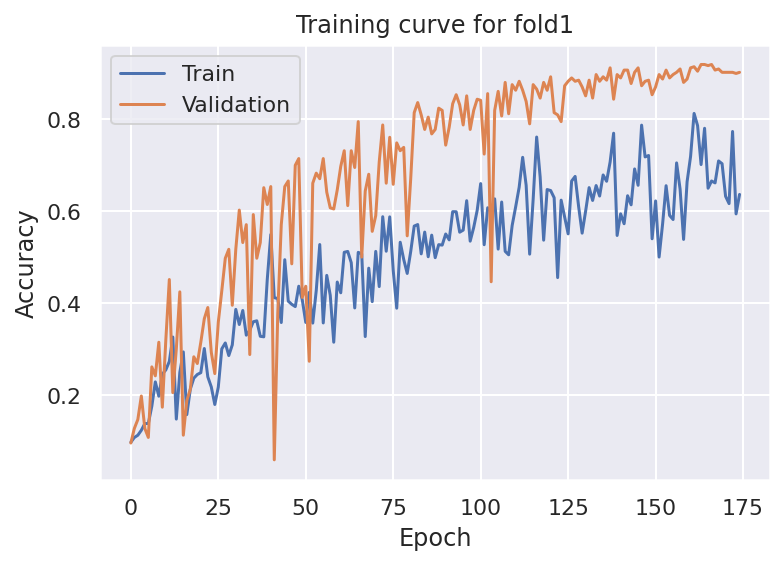

Epoch=0, Train loss=6.03428, Valid loss=1397.54064, Train Accuracy=0.09613, Validation Accuracy=0.11951
Epoch=10, Train loss=2.47150, Valid loss=7.01065, Train Accuracy=0.24558, Validation Accuracy=0.18780
Epoch=20, Train loss=2.26106, Valid loss=1.77661, Train Accuracy=0.31644, Validation Accuracy=0.41707
Epoch=30, Train loss=2.22088, Valid loss=2.97252, Train Accuracy=0.36354, Validation Accuracy=0.41707
Epoch=40, Train loss=2.29235, Valid loss=2.98699, Train Accuracy=0.33723, Validation Accuracy=0.51951
Epoch=50, Train loss=1.99596, Valid loss=37.05637, Train Accuracy=0.47813, Validation Accuracy=0.35610
Epoch=60, Train loss=2.03964, Valid loss=2.76054, Train Accuracy=0.43872, Validation Accuracy=0.56829
Epoch=70, Train loss=1.91950, Valid loss=1.04684, Train Accuracy=0.50616, Validation Accuracy=0.73659
Epoch=80, Train loss=2.01867, Valid loss=1.52329, Train Accuracy=0.46446, Validation Accuracy=0.73171
Epoch=90, Train loss=2.03298, Valid loss=1.33370, Train Accuracy=0.45067, Valid

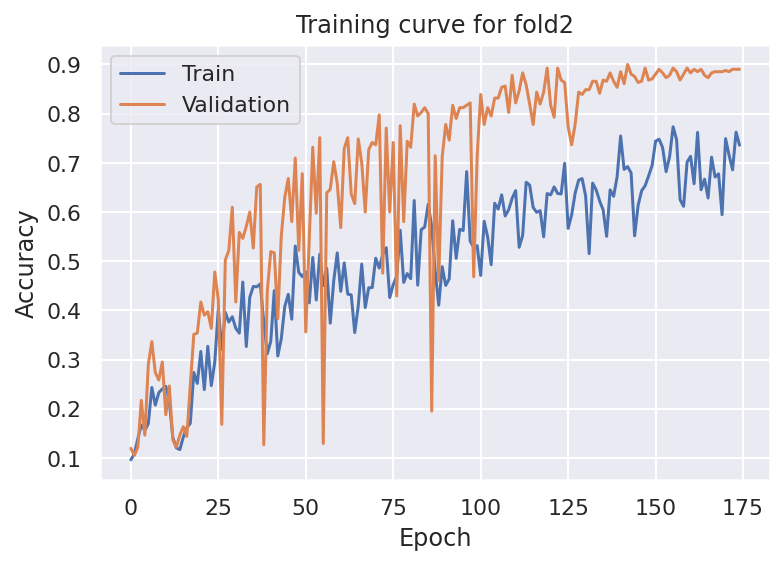

Epoch=0, Train loss=6.71430, Valid loss=7880.19571, Train Accuracy=0.08632, Validation Accuracy=0.06585
Epoch=10, Train loss=2.63807, Valid loss=3.42929, Train Accuracy=0.11414, Validation Accuracy=0.13171
Epoch=20, Train loss=2.63319, Valid loss=9.10780, Train Accuracy=0.13278, Validation Accuracy=0.12195
Epoch=30, Train loss=2.59021, Valid loss=4.00241, Train Accuracy=0.14335, Validation Accuracy=0.12683
Epoch=40, Train loss=2.33690, Valid loss=2.19108, Train Accuracy=0.19290, Validation Accuracy=0.22195
Epoch=50, Train loss=2.23161, Valid loss=2.06099, Train Accuracy=0.27398, Validation Accuracy=0.41951
Epoch=60, Train loss=2.09259, Valid loss=2.29638, Train Accuracy=0.36126, Validation Accuracy=0.40244
Epoch=70, Train loss=2.04476, Valid loss=1.54548, Train Accuracy=0.41365, Validation Accuracy=0.57805
Epoch=80, Train loss=1.65337, Valid loss=0.86616, Train Accuracy=0.60093, Validation Accuracy=0.80000
Epoch=90, Train loss=1.78515, Valid loss=1.33728, Train Accuracy=0.54301, Valida

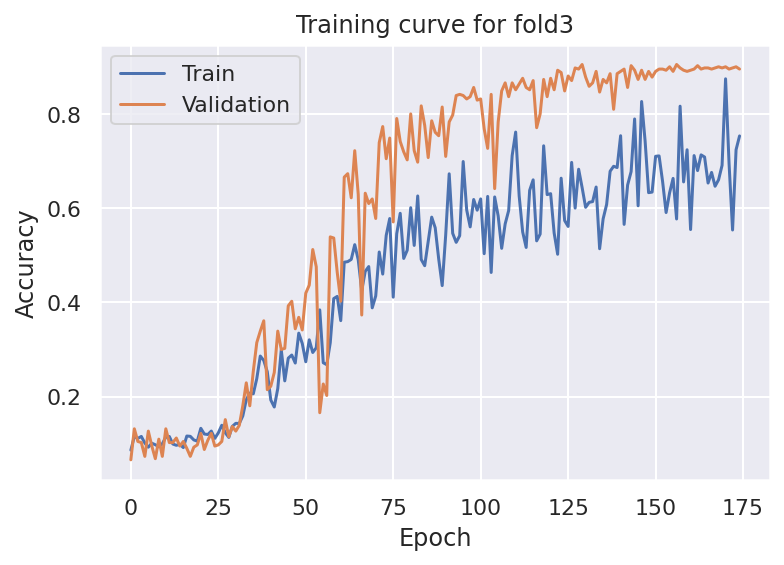

Epoch=0, Train loss=6.86123, Valid loss=83056.07322, Train Accuracy=0.09434, Validation Accuracy=0.12225
Epoch=10, Train loss=2.55651, Valid loss=3.52952, Train Accuracy=0.22097, Validation Accuracy=0.28117
Epoch=20, Train loss=2.45297, Valid loss=6.93513, Train Accuracy=0.26293, Validation Accuracy=0.38142
Epoch=30, Train loss=2.42761, Valid loss=2.78246, Train Accuracy=0.16642, Validation Accuracy=0.20782
Epoch=40, Train loss=2.21434, Valid loss=1.53721, Train Accuracy=0.33592, Validation Accuracy=0.52323
Epoch=50, Train loss=2.22049, Valid loss=52.99990, Train Accuracy=0.31281, Validation Accuracy=0.11980
Epoch=60, Train loss=2.01605, Valid loss=1.49635, Train Accuracy=0.45146, Validation Accuracy=0.59902
Epoch=70, Train loss=2.02234, Valid loss=1.25996, Train Accuracy=0.45230, Validation Accuracy=0.71394
Epoch=80, Train loss=1.80737, Valid loss=0.98717, Train Accuracy=0.53246, Validation Accuracy=0.75550
Epoch=90, Train loss=1.71441, Valid loss=0.92970, Train Accuracy=0.60036, Vali

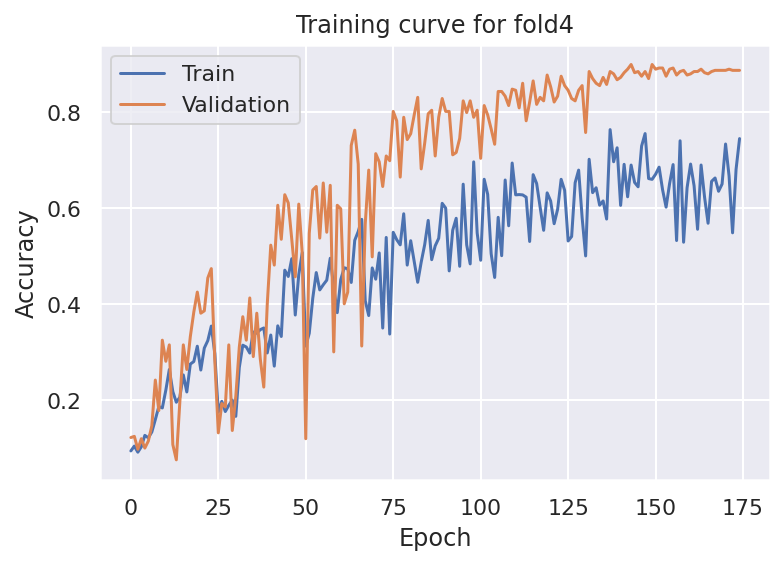

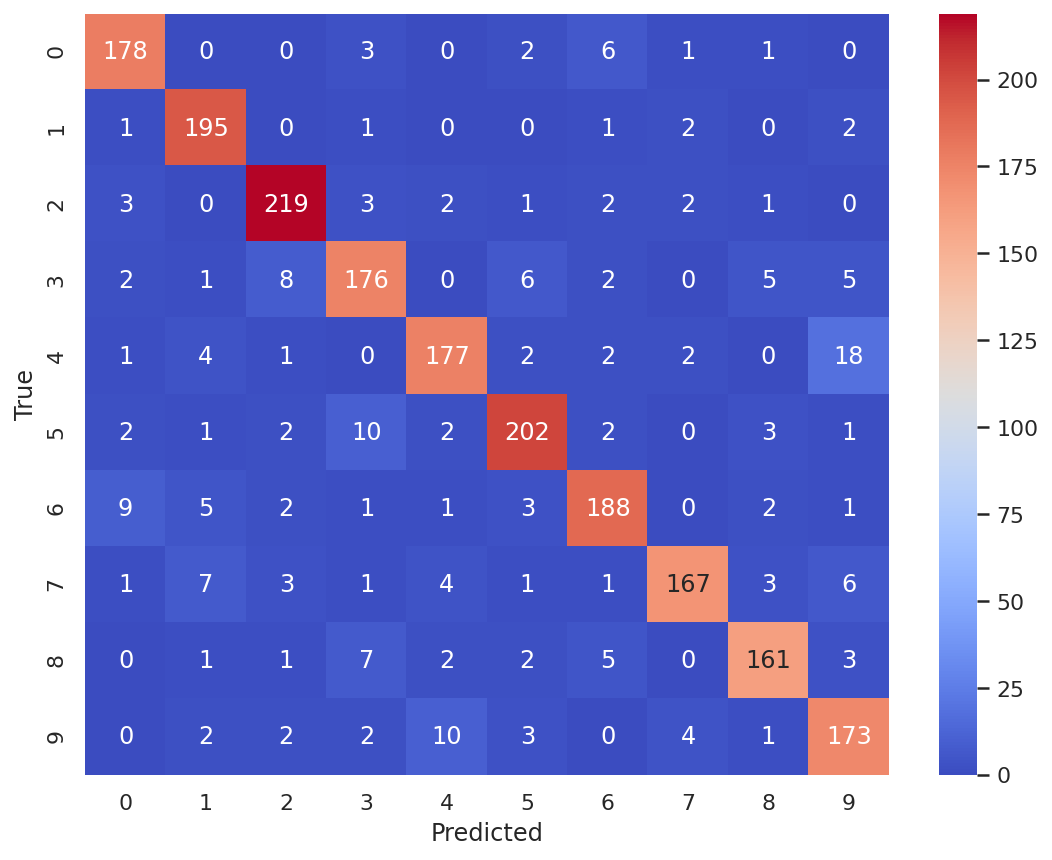

              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92       191
         1.0       0.90      0.97      0.93       202
         2.0       0.92      0.94      0.93       233
         3.0       0.86      0.86      0.86       205
         4.0       0.89      0.86      0.87       207
         5.0       0.91      0.90      0.90       225
         6.0       0.90      0.89      0.89       212
         7.0       0.94      0.86      0.90       194
         8.0       0.91      0.88      0.90       182
         9.0       0.83      0.88      0.85       197

    accuracy                           0.90      2048
   macro avg       0.90      0.90      0.90      2048
weighted avg       0.90      0.90      0.90      2048

CV Accuracy Score=0.896484375
model=resnet34, optimizer=adam, epochs=175, lr=0.003, wd=0.0005
CPU times: user 14min, sys: 2min 22s, total: 16min 22s
Wall time: 17min 11s


<IPython.core.display.Javascript object>

In [26]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "adam"
epochs = 175
lr = 3e-3
wd = 5e-4
oof, targs = run(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

Epoch=0, Train loss=6.24889, Valid loss=11130.24254, Train Accuracy=0.09989, Validation Accuracy=0.11736
Epoch=10, Train loss=2.61141, Valid loss=11.41594, Train Accuracy=0.14621, Validation Accuracy=0.17359
Epoch=20, Train loss=2.67534, Valid loss=23.07633, Train Accuracy=0.11971, Validation Accuracy=0.11002
Epoch=30, Train loss=2.39590, Valid loss=2.70787, Train Accuracy=0.17663, Validation Accuracy=0.19071
Epoch=40, Train loss=1.97574, Valid loss=1.56920, Train Accuracy=0.45103, Validation Accuracy=0.45966
Epoch=50, Train loss=2.16905, Valid loss=1.94979, Train Accuracy=0.35511, Validation Accuracy=0.40587
Epoch=60, Train loss=1.85928, Valid loss=2.15246, Train Accuracy=0.52038, Validation Accuracy=0.58191
Epoch=70, Train loss=1.92482, Valid loss=2.05131, Train Accuracy=0.47307, Validation Accuracy=0.56968
Epoch=80, Train loss=1.88754, Valid loss=1.18764, Train Accuracy=0.50405, Validation Accuracy=0.77262
Epoch=90, Train loss=2.03059, Valid loss=1.08104, Train Accuracy=0.46332, Val

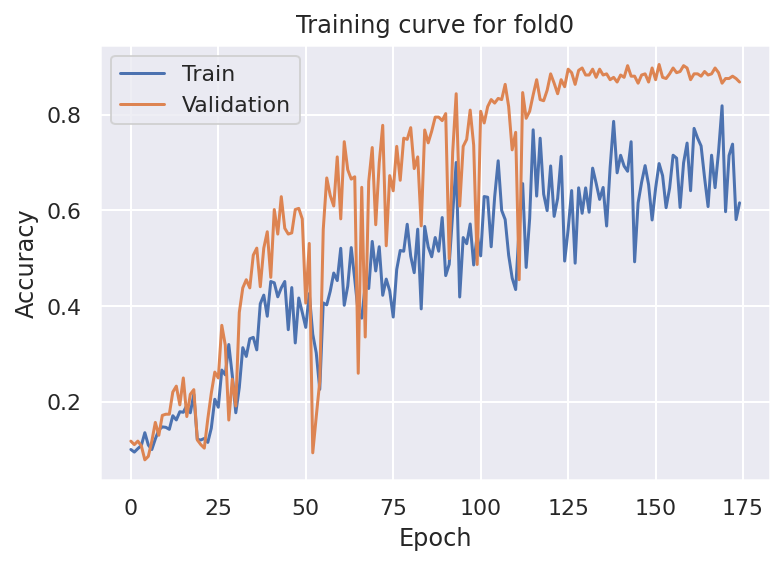

Epoch=0, Train loss=6.86174, Valid loss=1568.44453, Train Accuracy=0.10484, Validation Accuracy=0.10244
Epoch=10, Train loss=2.62147, Valid loss=2.48180, Train Accuracy=0.16824, Validation Accuracy=0.23415
Epoch=20, Train loss=2.42629, Valid loss=1.91902, Train Accuracy=0.22351, Validation Accuracy=0.34390
Epoch=30, Train loss=2.33948, Valid loss=2.45486, Train Accuracy=0.26150, Validation Accuracy=0.43171
Epoch=40, Train loss=2.14565, Valid loss=1.44521, Train Accuracy=0.38211, Validation Accuracy=0.56829
Epoch=50, Train loss=2.11017, Valid loss=2.18723, Train Accuracy=0.37088, Validation Accuracy=0.51707
Epoch=60, Train loss=2.17645, Valid loss=1.39016, Train Accuracy=0.34485, Validation Accuracy=0.61951
Epoch=70, Train loss=2.04006, Valid loss=1.31685, Train Accuracy=0.44081, Validation Accuracy=0.70488
Epoch=80, Train loss=1.77331, Valid loss=0.83413, Train Accuracy=0.54893, Validation Accuracy=0.80488
Epoch=90, Train loss=1.85065, Valid loss=0.89508, Train Accuracy=0.51463, Valida

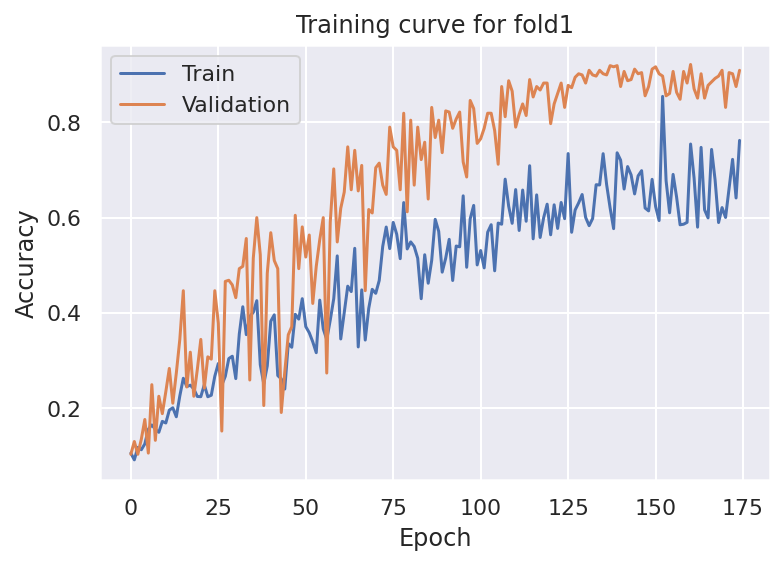

Epoch=0, Train loss=6.33619, Valid loss=9130.16671, Train Accuracy=0.08786, Validation Accuracy=0.07317
Epoch=10, Train loss=2.67419, Valid loss=5.37981, Train Accuracy=0.19683, Validation Accuracy=0.17317
Epoch=20, Train loss=2.37474, Valid loss=3.08042, Train Accuracy=0.31859, Validation Accuracy=0.48537
Epoch=30, Train loss=2.25933, Valid loss=1.62000, Train Accuracy=0.32056, Validation Accuracy=0.52683
Epoch=40, Train loss=2.03878, Valid loss=1.54186, Train Accuracy=0.43613, Validation Accuracy=0.60976
Epoch=50, Train loss=1.75191, Valid loss=1.07431, Train Accuracy=0.56310, Validation Accuracy=0.70976
Epoch=60, Train loss=1.80150, Valid loss=1.54144, Train Accuracy=0.54149, Validation Accuracy=0.68049
Epoch=70, Train loss=1.98370, Valid loss=4.33161, Train Accuracy=0.45163, Validation Accuracy=0.51220
Epoch=80, Train loss=1.89878, Valid loss=0.98050, Train Accuracy=0.52222, Validation Accuracy=0.80488
Epoch=90, Train loss=1.86768, Valid loss=1.06528, Train Accuracy=0.53228, Valida

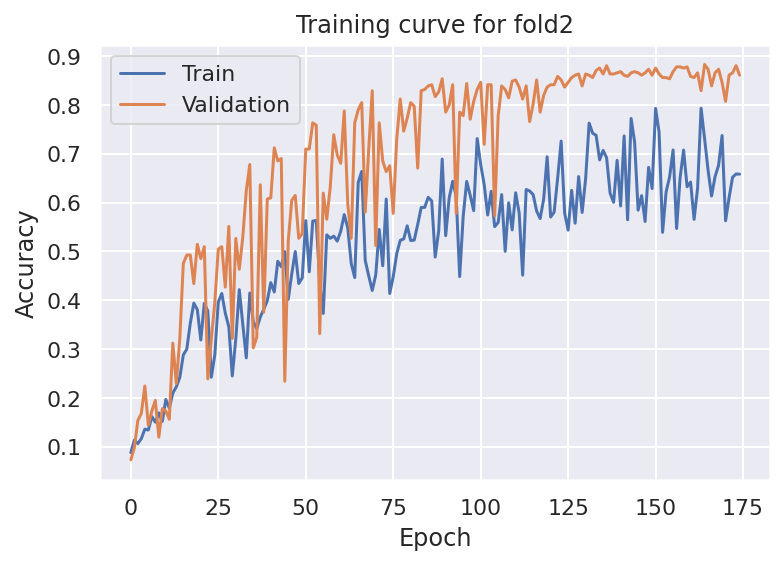

Epoch=0, Train loss=5.64237, Valid loss=5857.57753, Train Accuracy=0.10736, Validation Accuracy=0.09512
Epoch=10, Train loss=2.63410, Valid loss=4.40938, Train Accuracy=0.19257, Validation Accuracy=0.23171
Epoch=20, Train loss=2.42841, Valid loss=2.08871, Train Accuracy=0.24149, Validation Accuracy=0.28537
Epoch=30, Train loss=2.54970, Valid loss=2.16019, Train Accuracy=0.17102, Validation Accuracy=0.22439
Epoch=40, Train loss=2.29906, Valid loss=2.34543, Train Accuracy=0.25850, Validation Accuracy=0.32439
Epoch=50, Train loss=2.15165, Valid loss=1.80525, Train Accuracy=0.35165, Validation Accuracy=0.50244
Epoch=60, Train loss=2.12616, Valid loss=1.65532, Train Accuracy=0.40171, Validation Accuracy=0.61951
Epoch=70, Train loss=1.94482, Valid loss=1.40459, Train Accuracy=0.48718, Validation Accuracy=0.66585
Epoch=80, Train loss=1.91961, Valid loss=1.23145, Train Accuracy=0.48455, Validation Accuracy=0.72927
Epoch=90, Train loss=2.05403, Valid loss=1.45019, Train Accuracy=0.41335, Valida

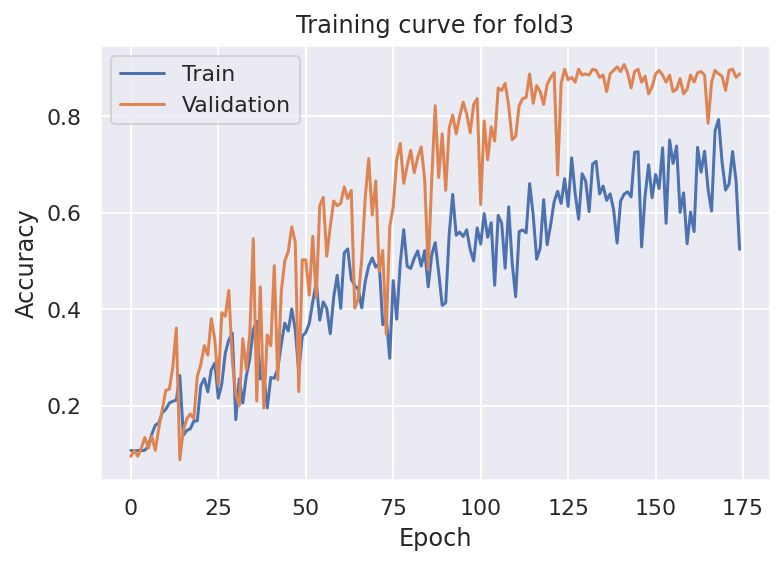

Epoch=0, Train loss=6.35229, Valid loss=2.31426, Train Accuracy=0.10843, Validation Accuracy=0.12225
Epoch=10, Train loss=2.53108, Valid loss=5.32968, Train Accuracy=0.23210, Validation Accuracy=0.17604
Epoch=20, Train loss=2.49666, Valid loss=2.01081, Train Accuracy=0.25741, Validation Accuracy=0.40098
Epoch=30, Train loss=2.36768, Valid loss=1.98829, Train Accuracy=0.22170, Validation Accuracy=0.27384
Epoch=40, Train loss=2.46977, Valid loss=2.85657, Train Accuracy=0.16711, Validation Accuracy=0.21760
Epoch=50, Train loss=2.32258, Valid loss=1.93336, Train Accuracy=0.23304, Validation Accuracy=0.40098
Epoch=60, Train loss=2.00122, Valid loss=1.67576, Train Accuracy=0.40693, Validation Accuracy=0.45477
Epoch=70, Train loss=1.81819, Valid loss=1.64654, Train Accuracy=0.51036, Validation Accuracy=0.48655
Epoch=80, Train loss=1.95534, Valid loss=1.36449, Train Accuracy=0.46685, Validation Accuracy=0.70171
Epoch=90, Train loss=1.99359, Valid loss=2.57786, Train Accuracy=0.45266, Validatio

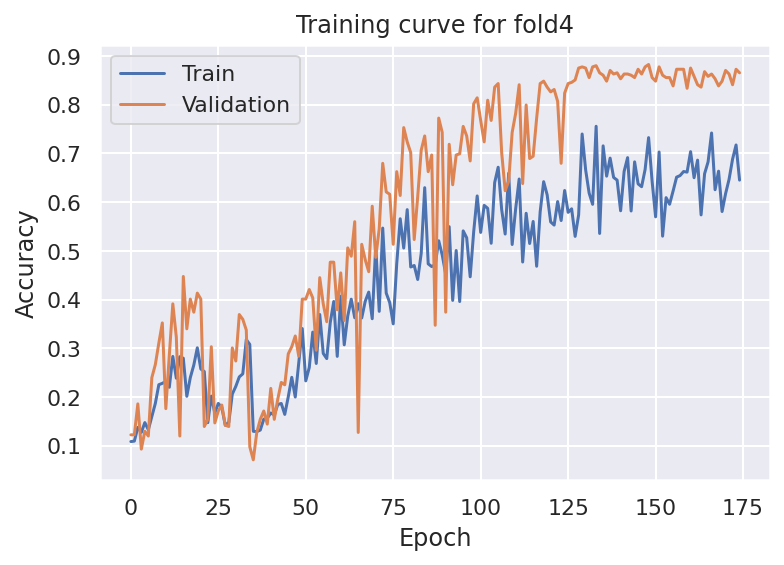

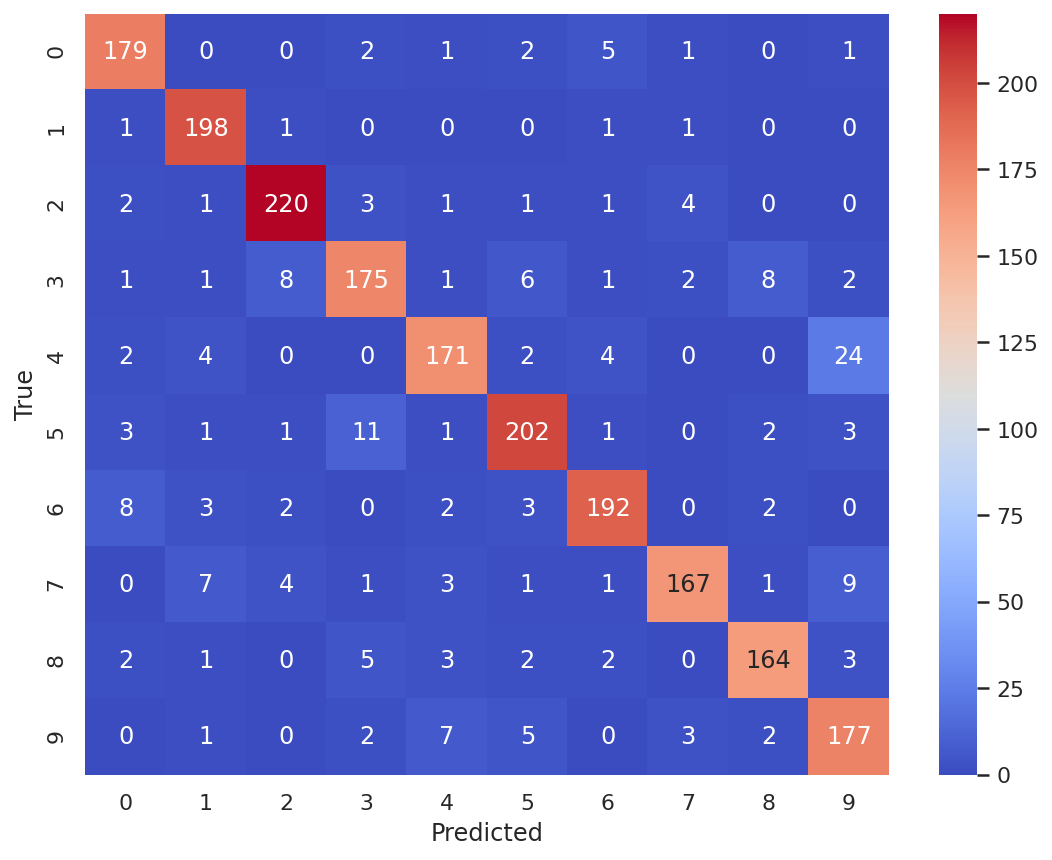

              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       191
         1.0       0.91      0.98      0.95       202
         2.0       0.93      0.94      0.94       233
         3.0       0.88      0.85      0.87       205
         4.0       0.90      0.83      0.86       207
         5.0       0.90      0.90      0.90       225
         6.0       0.92      0.91      0.91       212
         7.0       0.94      0.86      0.90       194
         8.0       0.92      0.90      0.91       182
         9.0       0.81      0.90      0.85       197

    accuracy                           0.90      2048
   macro avg       0.90      0.90      0.90      2048
weighted avg       0.90      0.90      0.90      2048

CV Accuracy Score=0.90087890625
model=resnet34, optimizer=adam, epochs=175, lr=0.003, wd=0.0005
CPU times: user 13min 59s, sys: 3min 40s, total: 17min 40s
Wall time: 18min 56s


<IPython.core.display.Javascript object>

In [111]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "adam"
epochs = 175
lr = 3e-3
wd = 5e-4
swa_lr = 2e-4
oof, targs = run(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True, swa=True, swa_lr=swa_lr)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

## Inference

In [12]:
def infer(model_names, checkpoints, test_df, device=DEVICE):
    output = np.zeros((len(test_df), 10))

    test_dataset = dataset.EMNISTDataset(test_df, np.arange(len(test_df)), label=False)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, num_workers=4, pin_memory=True
    )

    for model_name, checkpoint in zip(model_names, checkpoints):
        model = get_model(model_name).to(device)
        model.load_state_dict(torch.load(checkpoint))
        probs = engine.evaluate(test_loader, model, device, test=True)
        output += scipy.special.softmax(probs, axis=1) / len(model_names)

    return output

<IPython.core.display.Javascript object>

In [27]:
checkpoints = [
    "./models/resnet34_fold0.pth",
    "./models/resnet34_fold1.pth",
    "./models/resnet34_fold2.pth",
    "./models/resnet34_fold3.pth",
    "./models/resnet34_fold4.pth",
]
model_names = [
    "resnet34",
    "resnet34",
    "resnet34",
    "resnet34",
    "resnet34",
]

<IPython.core.display.Javascript object>

In [69]:
%%time
test_df = pd.read_csv(DATA_PATH / "test.csv")
test_probs = infer(model_names, checkpoints, test_df, device=DEVICE)
test_preds = np.argmax(test_probs, axis=1)

<IPython.core.display.Javascript object>

In [72]:
test_preds = np.argmax(test_probs, axis=1)
submit = pd.DataFrame({"id": test_df.id.values, "digit": test_preds})
submit.to_csv("submit.csv", index=False)

<IPython.core.display.Javascript object>

In [82]:
a = np.take_along_axis(test_probs, test_preds[:, None], axis=1)
a.shape

(20480, 1)

<IPython.core.display.Javascript object>

### SWA

In [112]:
checkpoints = [
    "./models/swa_resnet34_fold0.pth",
    "./models/swa_resnet34_fold1.pth",
    "./models/swa_resnet34_fold2.pth",
    "./models/swa_resnet34_fold3.pth",
    "./models/swa_resnet34_fold4.pth",
]
model_names = [
    "resnet34",
    "resnet34",
    "resnet34",
    "resnet34",
    "resnet34",
]

<IPython.core.display.Javascript object>

In [113]:
%%time
test_probs = infer(model_names, checkpoints, test_df, device=DEVICE)
test_preds = np.argmax(test_probs, axis=1)

CPU times: user 6min 17s, sys: 16.4 s, total: 6min 33s
Wall time: 6min 2s


<IPython.core.display.Javascript object>

In [114]:
test_preds = np.argmax(test_probs, axis=1)
submit = pd.DataFrame({"id": test_df.id.values, "digit": test_preds})
submit.to_csv("swa_submit.csv", index=False)

<IPython.core.display.Javascript object>

In [115]:
np.save("swa_probs.npy", test_probs)

<IPython.core.display.Javascript object>

## Pseudo-labeling

In [14]:
test_df = pd.read_csv(DATA_PATH / "test.csv")
test_probs = np.load("swa_probs.npy")
test_preds = np.argmax(test_probs, axis=1)

<IPython.core.display.Javascript object>

In [15]:
thresh = 0.50
maxprobs = np.take_along_axis(test_probs, test_preds[:, None], axis=1)
(maxprobs > thresh).sum()

15256

<IPython.core.display.Javascript object>

In [16]:
test_df["prob"] = maxprobs
test_df["digit"] = test_preds

<IPython.core.display.Javascript object>

In [17]:
pl = test_df[test_df.prob > thresh].reset_index(drop=True)
pl = pl.drop("prob", axis=1)
pl = pd.concat([pl, df], axis=0)
pl = pl.sample(frac=1).reset_index(drop=True)
pl.to_csv("./input/pl_resnet34_050.csv", index=False)
pl.shape

(17304, 787)

<IPython.core.display.Javascript object>

In [ ]:
y = pl[["digit", "letter"]]
kf = ml_stratifiers.MultilabelStratifiedKFold(n_splits=5)
for fold, (train_, valid_) in enumerate(kf.split(pl, y=y)):
    np.save(f"./input/train_fold{fold}", train_)
    np.save(f"./input/valid_fold{fold}", valid_)

In [12]:
def run_pl(
    model_name,
    optim_name,
    epochs,
    lr,
    wd,
    augs=None,
    label_smooth=True,
    mixup=False,
    cutmix=False,
    device=DEVICE,
    swa=False,
    swa_lr=4e-4,
    version=1,
):
    oof = np.zeros((len(pl), 10))
    targs = np.zeros(len(pl))

    for fold in range(5):
        train_indices = np.load(f"./input/train{version}_fold{fold}.npy")
        valid_indices = np.load(f"./input/valid{version}_fold{fold}.npy")
        train_dataset = dataset.EMNISTDataset(pl, train_indices, augs=augs)
        valid_dataset = dataset.EMNISTDataset(pl, valid_indices)
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True
        )
        valid_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=256, num_workers=4, pin_memory=True
        )

        model = get_model(model_name).to(device)
        optimizer = get_optimizer(optim_name, model, lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        scaler = torch.cuda.amp.GradScaler()

        if swa:
            swa_start = int(epochs * 0.75)
            steps_per_epoch = len(train_dataset) // 64
            optimizer = torchcontrib.optim.SWA(
                optimizer,
                swa_start=swa_start * steps_per_epoch,
                swa_freq=steps_per_epoch,
                swa_lr=swa_lr,
            )

        train_accuracies = []
        valid_accuracies = []

        for epoch in range(epochs):
            # Train
            train_loss, train_accuracy = engine.train(
                train_loader,
                model,
                optimizer,
                device,
                scaler,
                label_smooth=label_smooth,
                mixup=mixup,
                cutmix=cutmix,
            )
            train_accuracies.append(train_accuracy)
            scheduler.step()

            # Validate
            valid_probs, valid_targs, valid_loss, valid_accuracy = engine.evaluate(
                valid_loader, model, device
            )
            valid_accuracies.append(valid_accuracy)
            if epoch % 10 == 0:
                print(
                    f"Epoch={epoch}, Train loss={train_loss:.5f}, Valid loss={valid_loss:.5f}, Train Accuracy={train_accuracy:.5f}, Validation Accuracy={valid_accuracy:.5f}"
                )

        if swa:
            optimizer.swap_swa_sgd()
            optimizer.bn_update(train_loader, model, device)

        valid_probs, valid_targs, valid_loss, valid_accuracy = engine.evaluate(
            valid_loader, model, device
        )
        print(
            f"Fold={fold}, Valid loss={valid_loss:.5f}, Valid Accuracy={valid_accuracy:.5f}"
        )

        # oof prediction
        oof[valid_indices] = scipy.special.softmax(valid_probs, axis=1)
        targs[valid_indices] = valid_targs

        # Save model
        checkpoint = (
            f"./models/swa_{model_name}_fold{fold}_pl{version}.pth"
            if swa
            else f"./models/{model_name}_fold{fold}_pl{version}.pth"
        )
        torch.save(model.state_dict(), checkpoint)

        # Plot training curve
        rng = np.arange(len(train_accuracies))
        plt.plot(rng, train_accuracies, label="Train")
        plt.plot(rng, valid_accuracies, label="Validation")
        plt.title(f"Training curve for fold{fold}")
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
        plt.legend()
        plt.show()

    # Confusion matrix
    conf = metrics.confusion_matrix(targs, np.argmax(oof, axis=1))
    plt.figure(figsize=(9, 7))
    sns.heatmap(conf, cmap="coolwarm", annot=True, fmt="d")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

    # Classification report
    print(metrics.classification_report(targs, np.argmax(oof, axis=1)))

    return oof, targs

<IPython.core.display.Javascript object>

Epoch=0, Train loss=3.25954, Valid loss=3.00309, Train Accuracy=0.14411, Validation Accuracy=0.33661
Epoch=10, Train loss=1.73678, Valid loss=0.93561, Train Accuracy=0.59444, Validation Accuracy=0.74747
Epoch=20, Train loss=1.66182, Valid loss=0.88183, Train Accuracy=0.61884, Validation Accuracy=0.87085
Epoch=30, Train loss=1.57142, Valid loss=0.58531, Train Accuracy=0.65869, Validation Accuracy=0.95724
Epoch=40, Train loss=1.49344, Valid loss=0.62457, Train Accuracy=0.68488, Validation Accuracy=0.95117
Epoch=50, Train loss=1.40918, Valid loss=0.43475, Train Accuracy=0.72015, Validation Accuracy=0.97602
Epoch=60, Train loss=1.56174, Valid loss=0.40954, Train Accuracy=0.65829, Validation Accuracy=0.98035
Epoch=70, Train loss=1.43070, Valid loss=0.38618, Train Accuracy=0.71296, Validation Accuracy=0.98382
Epoch=80, Train loss=1.54018, Valid loss=0.64601, Train Accuracy=0.66630, Validation Accuracy=0.98266
Epoch=90, Train loss=1.48072, Valid loss=0.50600, Train Accuracy=0.68874, Validatio

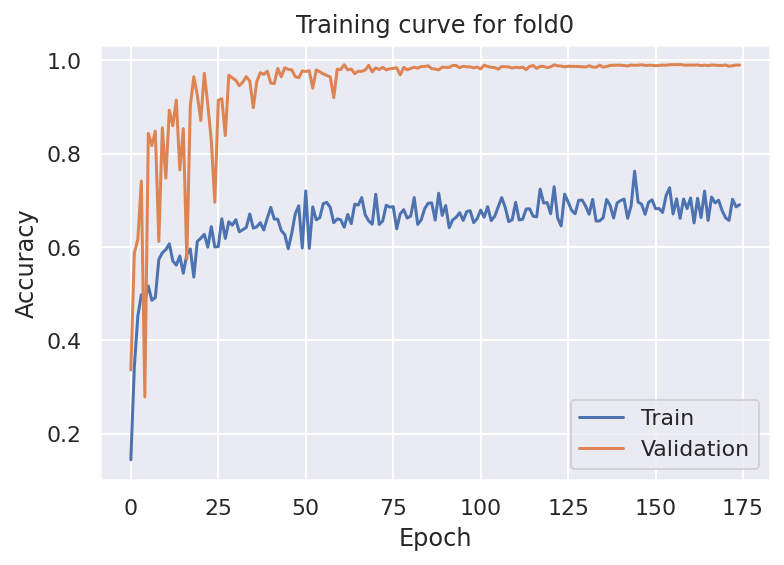

Epoch=0, Train loss=3.19948, Valid loss=12.92983, Train Accuracy=0.14635, Validation Accuracy=0.11182
Epoch=10, Train loss=1.76801, Valid loss=1.89285, Train Accuracy=0.57482, Validation Accuracy=0.59607
Epoch=20, Train loss=1.62643, Valid loss=0.76658, Train Accuracy=0.63839, Validation Accuracy=0.91650
Epoch=30, Train loss=1.67840, Valid loss=0.62777, Train Accuracy=0.61117, Validation Accuracy=0.96475
Epoch=40, Train loss=1.54578, Valid loss=0.54782, Train Accuracy=0.66820, Validation Accuracy=0.96764
Epoch=50, Train loss=1.45069, Valid loss=0.46405, Train Accuracy=0.70479, Validation Accuracy=0.97255
Epoch=60, Train loss=1.57295, Valid loss=0.52627, Train Accuracy=0.65062, Validation Accuracy=0.98151
Epoch=70, Train loss=1.48732, Valid loss=0.33371, Train Accuracy=0.68529, Validation Accuracy=0.97631
Epoch=80, Train loss=1.50077, Valid loss=0.43926, Train Accuracy=0.68147, Validation Accuracy=0.97949
Epoch=90, Train loss=1.49924, Valid loss=0.52220, Train Accuracy=0.68012, Validati

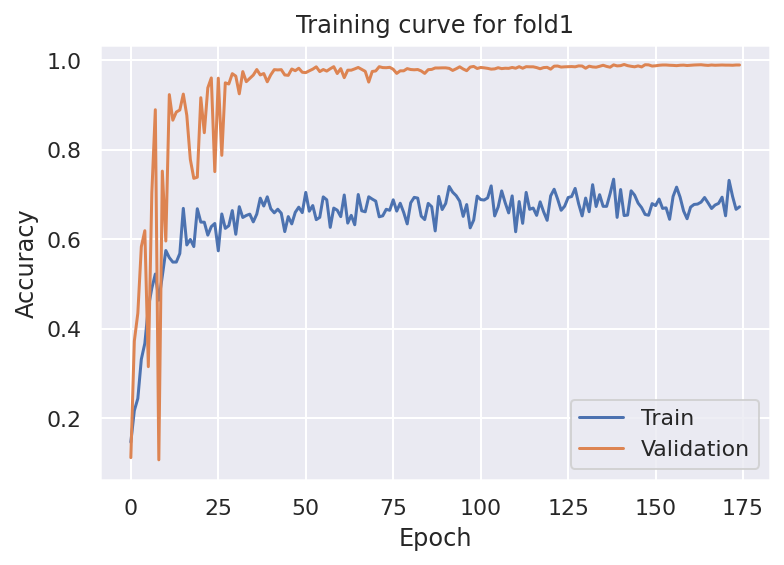

Epoch=0, Train loss=3.36849, Valid loss=2.20528, Train Accuracy=0.11967, Validation Accuracy=0.16329
Epoch=10, Train loss=1.78378, Valid loss=0.77872, Train Accuracy=0.57353, Validation Accuracy=0.90029
Epoch=20, Train loss=1.60239, Valid loss=4.44659, Train Accuracy=0.64753, Validation Accuracy=0.40780
Epoch=30, Train loss=1.53374, Valid loss=0.54905, Train Accuracy=0.67496, Validation Accuracy=0.96618
Epoch=40, Train loss=1.57620, Valid loss=0.65366, Train Accuracy=0.65512, Validation Accuracy=0.97746
Epoch=50, Train loss=1.51185, Valid loss=0.40205, Train Accuracy=0.67797, Validation Accuracy=0.97803
Epoch=60, Train loss=1.57494, Valid loss=0.67828, Train Accuracy=0.65064, Validation Accuracy=0.97659
Epoch=70, Train loss=1.48406, Valid loss=0.55303, Train Accuracy=0.68907, Validation Accuracy=0.98006
Epoch=80, Train loss=1.52308, Valid loss=0.60717, Train Accuracy=0.67321, Validation Accuracy=0.97572
Epoch=90, Train loss=1.54028, Valid loss=0.63503, Train Accuracy=0.66480, Validatio

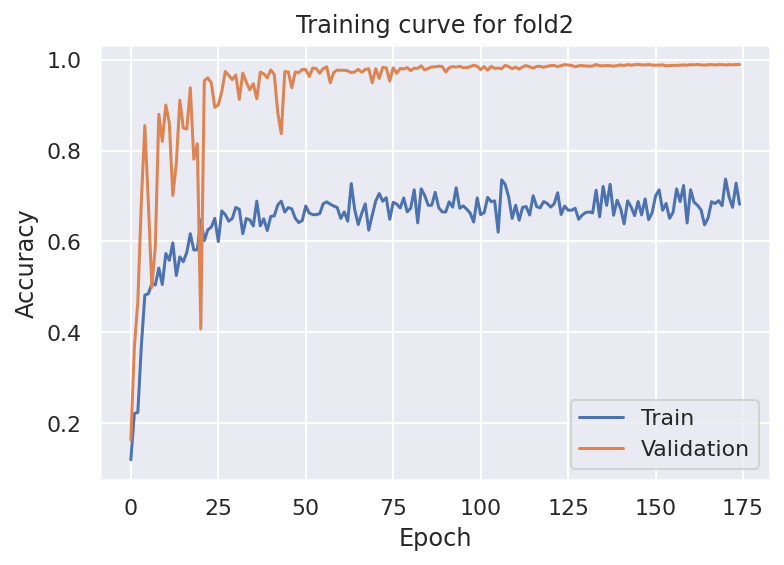

Epoch=0, Train loss=3.16595, Valid loss=2.29978, Train Accuracy=0.12402, Validation Accuracy=0.12800
Epoch=10, Train loss=1.79400, Valid loss=0.82545, Train Accuracy=0.56069, Validation Accuracy=0.89136
Epoch=20, Train loss=1.68113, Valid loss=0.61956, Train Accuracy=0.62100, Validation Accuracy=0.93875
Epoch=30, Train loss=1.58913, Valid loss=0.72682, Train Accuracy=0.65317, Validation Accuracy=0.95204
Epoch=40, Train loss=1.55699, Valid loss=0.62820, Train Accuracy=0.65907, Validation Accuracy=0.95290
Epoch=50, Train loss=1.54664, Valid loss=0.53421, Train Accuracy=0.66395, Validation Accuracy=0.97024
Epoch=60, Train loss=1.55186, Valid loss=0.62914, Train Accuracy=0.66022, Validation Accuracy=0.97891
Epoch=70, Train loss=1.60797, Valid loss=0.69191, Train Accuracy=0.63588, Validation Accuracy=0.95261
Epoch=80, Train loss=1.54852, Valid loss=0.38417, Train Accuracy=0.65933, Validation Accuracy=0.98526
Epoch=90, Train loss=1.46928, Valid loss=0.40991, Train Accuracy=0.69134, Validatio

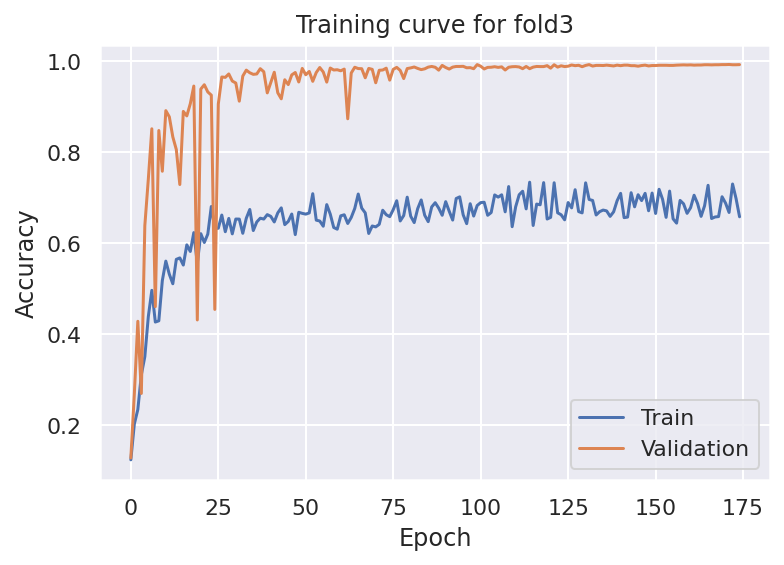

Epoch=0, Train loss=3.09878, Valid loss=7.47224, Train Accuracy=0.15995, Validation Accuracy=0.25137
Epoch=10, Train loss=1.95449, Valid loss=1.52602, Train Accuracy=0.48224, Validation Accuracy=0.57382
Epoch=20, Train loss=1.75669, Valid loss=0.78701, Train Accuracy=0.58306, Validation Accuracy=0.84947
Epoch=30, Train loss=1.54118, Valid loss=0.75223, Train Accuracy=0.66843, Validation Accuracy=0.94366
Epoch=40, Train loss=1.57314, Valid loss=1.06043, Train Accuracy=0.65434, Validation Accuracy=0.84773
Epoch=50, Train loss=1.51993, Valid loss=0.61378, Train Accuracy=0.67512, Validation Accuracy=0.97891
Epoch=60, Train loss=1.63593, Valid loss=0.55142, Train Accuracy=0.62516, Validation Accuracy=0.98151
Epoch=70, Train loss=1.47637, Valid loss=0.42552, Train Accuracy=0.68964, Validation Accuracy=0.97486
Epoch=80, Train loss=1.54467, Valid loss=0.55210, Train Accuracy=0.66465, Validation Accuracy=0.98440
Epoch=90, Train loss=1.55191, Valid loss=0.48976, Train Accuracy=0.65776, Validatio

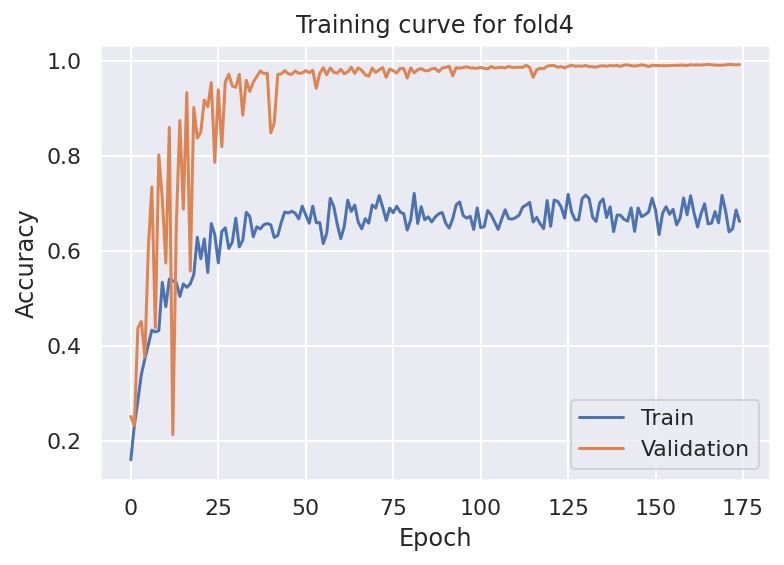

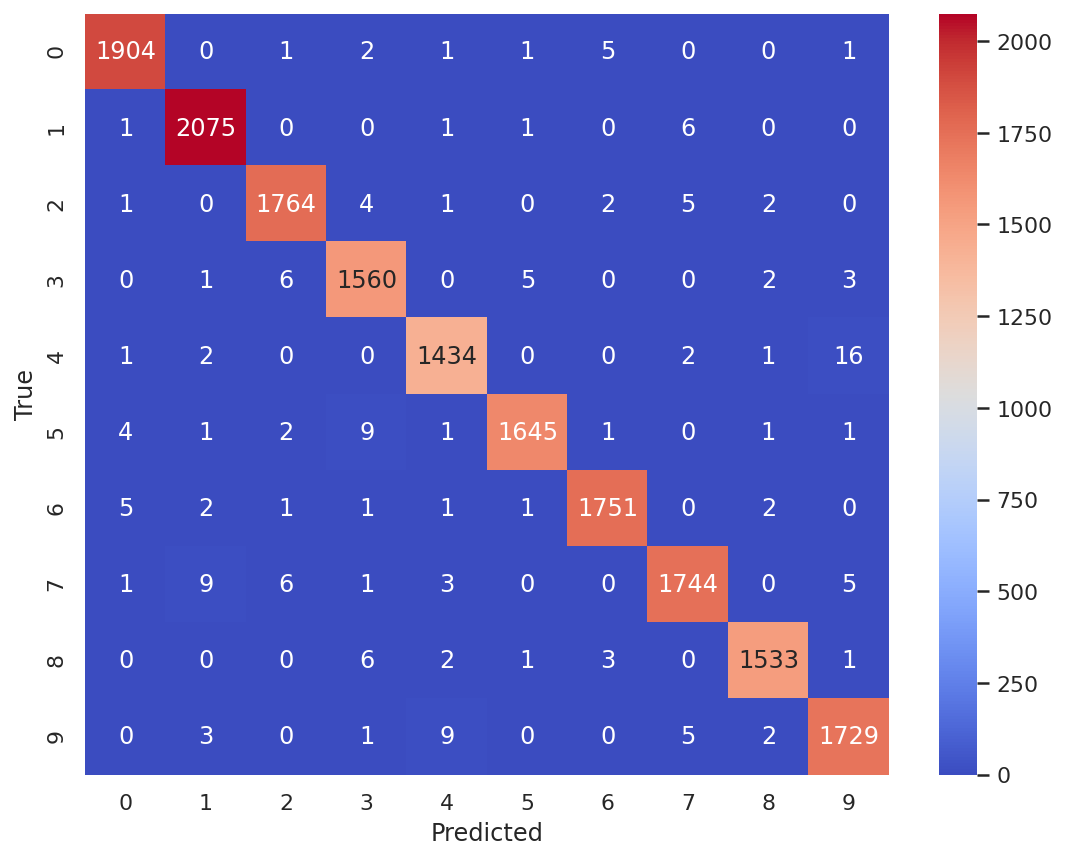

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1915
         1.0       0.99      1.00      0.99      2084
         2.0       0.99      0.99      0.99      1779
         3.0       0.98      0.99      0.99      1577
         4.0       0.99      0.98      0.99      1456
         5.0       0.99      0.99      0.99      1665
         6.0       0.99      0.99      0.99      1764
         7.0       0.99      0.99      0.99      1769
         8.0       0.99      0.99      0.99      1546
         9.0       0.98      0.99      0.99      1749

    accuracy                           0.99     17304
   macro avg       0.99      0.99      0.99     17304
weighted avg       0.99      0.99      0.99     17304

CV Accuracy Score=0.9904646324549237
model=resnet34, optimizer=adam, epochs=175, lr=0.003, wd=0.0005
CPU times: user 1h 55min 46s, sys: 3min 20s, total: 1h 59min 7s
Wall time: 1h 57min 23s


<IPython.core.display.Javascript object>

In [25]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "adam"
epochs = 175
lr = 3e-3
wd = 5e-4
oof, targs = run_pl(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

In [26]:
checkpoints = [
    "./models/resnet34_fold0_pl.pth",
    "./models/resnet34_fold1_pl.pth",
    "./models/resnet34_fold2_pl.pth",
    "./models/resnet34_fold3_pl.pth",
    "./models/resnet34_fold4_pl.pth",
]
model_names = [
    "resnet34",
    "resnet34",
    "resnet34",
    "resnet34",
    "resnet34",
]

<IPython.core.display.Javascript object>

In [27]:
%%time
test_df = pd.read_csv(DATA_PATH / "test.csv")
test_probs = infer(model_names, checkpoints, test_df, device=DEVICE)
test_preds = np.argmax(test_probs, axis=1)
np.save("pl_probs.npy", test_probs)

CPU times: user 6min 19s, sys: 16.4 s, total: 6min 36s
Wall time: 6min 3s


<IPython.core.display.Javascript object>

In [28]:
test_preds = np.argmax(test_probs, axis=1)
submit = pd.DataFrame({"id": test_df.id.values, "digit": test_preds})
submit.to_csv("pl_submit.csv", index=False)

<IPython.core.display.Javascript object>

### SWA

Epoch=0, Train loss=3.25374, Valid loss=2.15825, Train Accuracy=0.15635, Validation Accuracy=0.31003
Epoch=10, Train loss=1.94060, Valid loss=0.73561, Train Accuracy=0.49023, Validation Accuracy=0.83589
Epoch=20, Train loss=1.65548, Valid loss=1.02321, Train Accuracy=0.62712, Validation Accuracy=0.84080
Epoch=30, Train loss=1.58989, Valid loss=0.62288, Train Accuracy=0.65649, Validation Accuracy=0.95695
Epoch=40, Train loss=1.54488, Valid loss=0.34233, Train Accuracy=0.66589, Validation Accuracy=0.98324
Epoch=50, Train loss=1.61848, Valid loss=0.53500, Train Accuracy=0.63661, Validation Accuracy=0.98353
Epoch=60, Train loss=1.60430, Valid loss=0.58264, Train Accuracy=0.64092, Validation Accuracy=0.98353
Epoch=70, Train loss=1.54631, Valid loss=0.64025, Train Accuracy=0.66142, Validation Accuracy=0.98295
Epoch=80, Train loss=1.44489, Valid loss=0.79317, Train Accuracy=0.70153, Validation Accuracy=0.97746
Epoch=90, Train loss=1.51791, Valid loss=0.49139, Train Accuracy=0.67204, Validatio

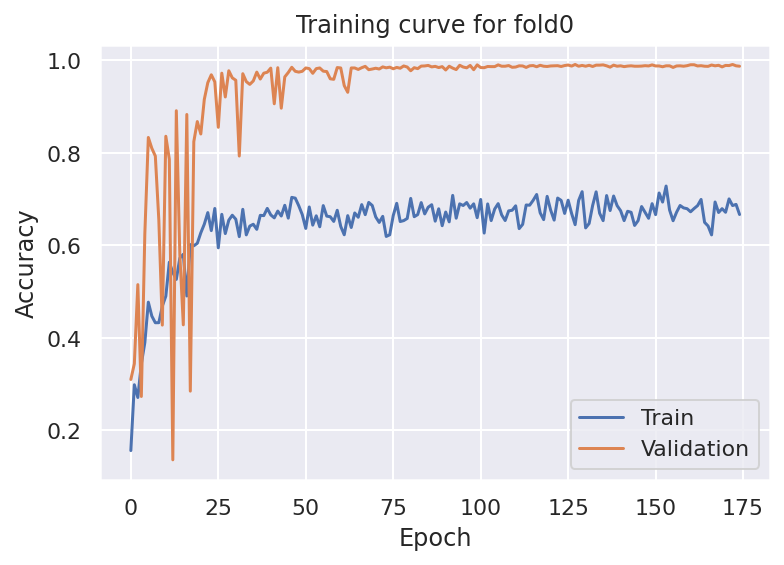

Epoch=0, Train loss=3.10964, Valid loss=2.40979, Train Accuracy=0.14088, Validation Accuracy=0.15371
Epoch=10, Train loss=1.92167, Valid loss=1.40106, Train Accuracy=0.48693, Validation Accuracy=0.63161
Epoch=20, Train loss=1.73355, Valid loss=0.85630, Train Accuracy=0.59065, Validation Accuracy=0.87778
Epoch=30, Train loss=1.55378, Valid loss=0.60203, Train Accuracy=0.66514, Validation Accuracy=0.97168
Epoch=40, Train loss=1.54745, Valid loss=0.56302, Train Accuracy=0.66509, Validation Accuracy=0.96995
Epoch=50, Train loss=1.39620, Valid loss=0.42374, Train Accuracy=0.72309, Validation Accuracy=0.97746
Epoch=60, Train loss=1.57049, Valid loss=0.38825, Train Accuracy=0.65422, Validation Accuracy=0.97977
Epoch=70, Train loss=1.44139, Valid loss=0.40862, Train Accuracy=0.70799, Validation Accuracy=0.98209
Epoch=80, Train loss=1.55212, Valid loss=0.74092, Train Accuracy=0.66231, Validation Accuracy=0.97197
Epoch=90, Train loss=1.45349, Valid loss=0.49528, Train Accuracy=0.69838, Validatio

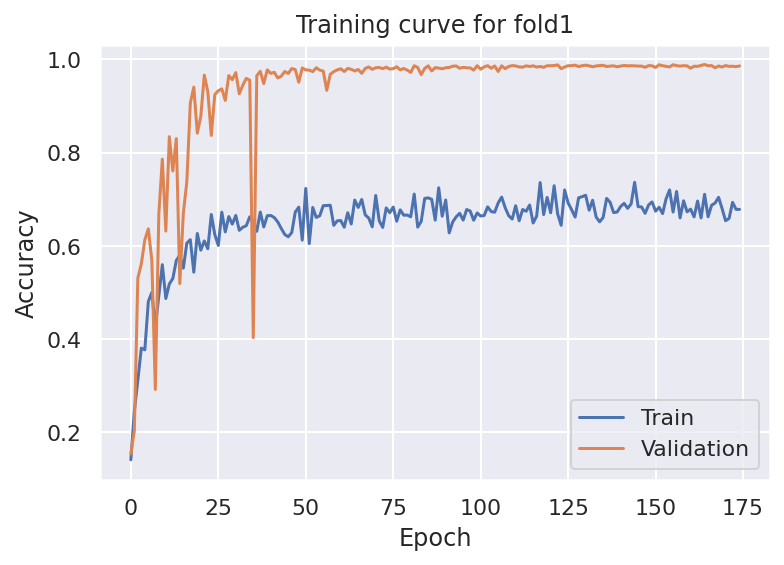

Epoch=0, Train loss=3.33777, Valid loss=12.93091, Train Accuracy=0.14145, Validation Accuracy=0.22890
Epoch=10, Train loss=1.76633, Valid loss=0.76778, Train Accuracy=0.57021, Validation Accuracy=0.88584
Epoch=20, Train loss=1.71302, Valid loss=0.75549, Train Accuracy=0.60468, Validation Accuracy=0.94017
Epoch=30, Train loss=1.73733, Valid loss=0.73337, Train Accuracy=0.58947, Validation Accuracy=0.94624
Epoch=40, Train loss=1.53930, Valid loss=0.45972, Train Accuracy=0.66974, Validation Accuracy=0.95202
Epoch=50, Train loss=1.45108, Valid loss=0.38040, Train Accuracy=0.70676, Validation Accuracy=0.97746
Epoch=60, Train loss=1.56524, Valid loss=0.59395, Train Accuracy=0.65542, Validation Accuracy=0.97197
Epoch=70, Train loss=1.47878, Valid loss=0.33266, Train Accuracy=0.68979, Validation Accuracy=0.97775
Epoch=80, Train loss=1.51674, Valid loss=0.39531, Train Accuracy=0.67762, Validation Accuracy=0.97803
Epoch=90, Train loss=1.52434, Valid loss=0.52608, Train Accuracy=0.67248, Validati

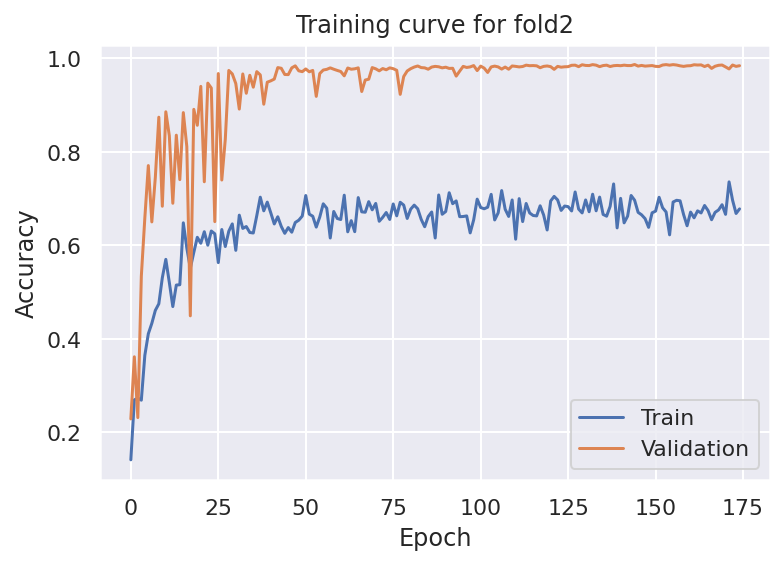

Epoch=0, Train loss=3.20669, Valid loss=2.34820, Train Accuracy=0.10947, Validation Accuracy=0.14331
Epoch=10, Train loss=1.83562, Valid loss=1.42456, Train Accuracy=0.54035, Validation Accuracy=0.66802
Epoch=20, Train loss=1.66486, Valid loss=1.55859, Train Accuracy=0.61495, Validation Accuracy=0.59000
Epoch=30, Train loss=1.55718, Valid loss=0.57651, Train Accuracy=0.66222, Validation Accuracy=0.96966
Epoch=40, Train loss=1.57867, Valid loss=0.62765, Train Accuracy=0.65292, Validation Accuracy=0.97775
Epoch=50, Train loss=1.53413, Valid loss=0.49018, Train Accuracy=0.66816, Validation Accuracy=0.98064
Epoch=60, Train loss=1.56486, Valid loss=0.77783, Train Accuracy=0.65620, Validation Accuracy=0.98006
Epoch=70, Train loss=1.51667, Valid loss=0.53867, Train Accuracy=0.67431, Validation Accuracy=0.98700
Epoch=80, Train loss=1.52468, Valid loss=0.57959, Train Accuracy=0.66991, Validation Accuracy=0.98266
Epoch=90, Train loss=1.53609, Valid loss=0.54464, Train Accuracy=0.66469, Validatio

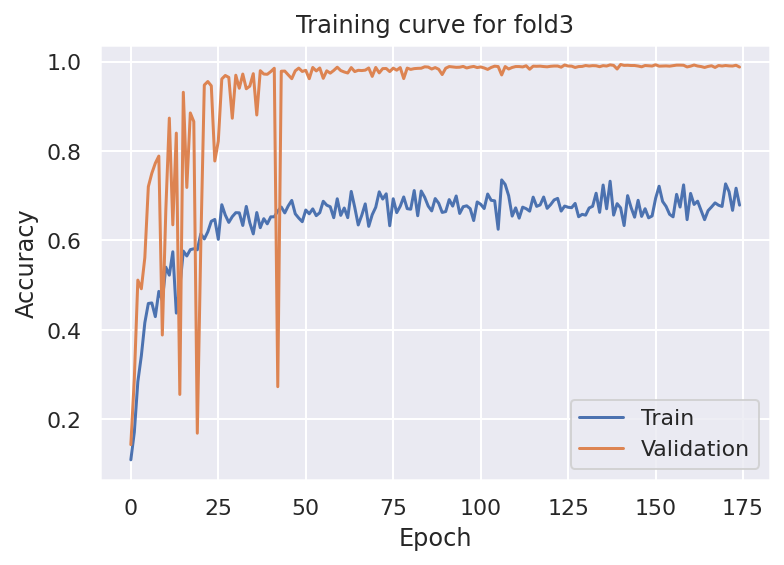

Epoch=0, Train loss=3.11229, Valid loss=1.93268, Train Accuracy=0.18226, Validation Accuracy=0.41635
Epoch=10, Train loss=1.85372, Valid loss=1.84979, Train Accuracy=0.53456, Validation Accuracy=0.34730
Epoch=20, Train loss=1.71485, Valid loss=0.66977, Train Accuracy=0.60369, Validation Accuracy=0.94597


In [ ]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "adam"
epochs = 175
lr = 3e-3
wd = 5e-4
swa_lr = 4e-4
oof, targs = run_pl(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True, swa=True, swa_lr=swa_lr)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

In [ ]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "adam"
epochs = 175
lr = 3e-3
wd = 5e-4
swa_lr = 4e-4
oof, targs = run_pl(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True, swa=True, swa_lr=swa_lr)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

In [30]:
checkpoints = [
    "./models/swa_resnet34_fold0_pl.pth",
    "./models/swa_resnet34_fold1_pl.pth",
    "./models/swa_resnet34_fold2_pl.pth",
    "./models/swa_resnet34_fold3_pl.pth",
    "./models/swa_resnet34_fold4_pl.pth",
]
model_names = [
    "resnet34",
    "resnet34",
    "resnet34",
    "resnet34",
    "resnet34",
]

<IPython.core.display.Javascript object>

In [31]:
%%time
test_df = pd.read_csv(DATA_PATH / "test.csv")
test_probs = infer(model_names, checkpoints, test_df, device=DEVICE)
test_preds = np.argmax(test_probs, axis=1)
np.save("swa_pl_probs.npy", test_probs)

CPU times: user 6min 24s, sys: 15.9 s, total: 6min 40s
Wall time: 6min 7s


<IPython.core.display.Javascript object>

In [32]:
test_preds = np.argmax(test_probs, axis=1)
submit = pd.DataFrame({"id": test_df.id.values, "digit": test_preds})
submit.to_csv("swa_pl_submit.csv", index=False)

<IPython.core.display.Javascript object>

## PL^2

In [33]:
test_df = pd.read_csv(DATA_PATH / "test.csv")
test_probs = np.load("swa_pl_probs.npy")
test_preds = np.argmax(test_probs, axis=1)

<IPython.core.display.Javascript object>

In [37]:
thresh = 0.50
maxprobs = np.take_along_axis(test_probs, test_preds[:, None], axis=1)
(maxprobs > thresh).sum()

18197

<IPython.core.display.Javascript object>

In [38]:
test_df["prob"] = maxprobs
test_df["digit"] = test_preds

<IPython.core.display.Javascript object>

In [39]:
pl = test_df[test_df.prob > thresh].reset_index(drop=True)
pl = pl.drop("prob", axis=1)
pl = pd.concat([pl, df], axis=0)
pl = pl.sample(frac=1).reset_index(drop=True)
pl.to_csv("./input/pl2_resnet34_050.csv", index=False)

<IPython.core.display.Javascript object>

In [43]:
y = pl[["digit", "letter"]]
kf = ml_stratifiers.MultilabelStratifiedKFold(n_splits=5)
for fold, (train_, valid_) in enumerate(kf.split(pl, y=y)):
    np.save(f"./input/train2_fold{fold}", train_)
    np.save(f"./input/valid2_fold{fold}", valid_)

/home/isleof/.pyenv/versions/miniconda3-latest/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass shuffle=False, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


<IPython.core.display.Javascript object>

Epoch=0, Train loss=3.35949, Valid loss=306.79012, Train Accuracy=0.20394, Validation Accuracy=0.11213
Epoch=10, Train loss=2.46322, Valid loss=1.61409, Train Accuracy=0.34220, Validation Accuracy=0.62855
Epoch=20, Train loss=2.18252, Valid loss=103.58676, Train Accuracy=0.44508, Validation Accuracy=0.59348
Epoch=30, Train loss=1.89915, Valid loss=1.11328, Train Accuracy=0.57347, Validation Accuracy=0.83305
Epoch=40, Train loss=1.97272, Valid loss=0.84264, Train Accuracy=0.52139, Validation Accuracy=0.83453
Epoch=50, Train loss=1.68057, Valid loss=0.89092, Train Accuracy=0.62301, Validation Accuracy=0.78810
Epoch=60, Train loss=1.66185, Valid loss=0.69189, Train Accuracy=0.61863, Validation Accuracy=0.91603
Epoch=70, Train loss=1.58356, Valid loss=0.70586, Train Accuracy=0.64993, Validation Accuracy=0.93653
Epoch=80, Train loss=1.67640, Valid loss=0.79263, Train Accuracy=0.60865, Validation Accuracy=0.94394
Epoch=90, Train loss=1.65773, Valid loss=1.03975, Train Accuracy=0.61760, Valid

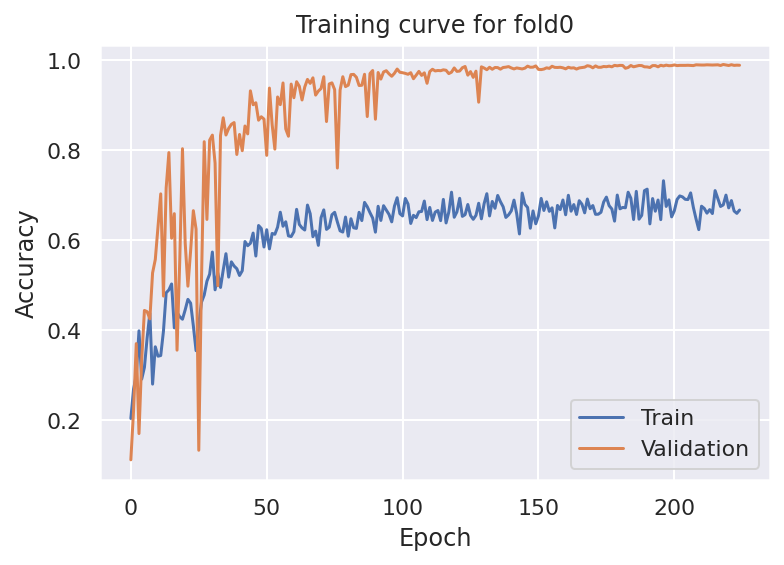

Epoch=0, Train loss=3.33767, Valid loss=31.29953, Train Accuracy=0.22552, Validation Accuracy=0.33761
Epoch=10, Train loss=2.29585, Valid loss=60.91200, Train Accuracy=0.41050, Validation Accuracy=0.53717
Epoch=20, Train loss=2.59748, Valid loss=3.60441, Train Accuracy=0.16653, Validation Accuracy=0.27167
Epoch=30, Train loss=2.10645, Valid loss=1.55996, Train Accuracy=0.43626, Validation Accuracy=0.48456
Epoch=40, Train loss=1.84125, Valid loss=1.90706, Train Accuracy=0.54670, Validation Accuracy=0.44949
Epoch=50, Train loss=1.80607, Valid loss=0.92255, Train Accuracy=0.56496, Validation Accuracy=0.85873
Epoch=60, Train loss=1.77078, Valid loss=2.90420, Train Accuracy=0.57458, Validation Accuracy=0.63176
Epoch=70, Train loss=1.64134, Valid loss=0.80307, Train Accuracy=0.62265, Validation Accuracy=0.88590
Epoch=80, Train loss=1.57978, Valid loss=0.54445, Train Accuracy=0.64825, Validation Accuracy=0.95036
Epoch=90, Train loss=1.52863, Valid loss=0.50781, Train Accuracy=0.66822, Validat

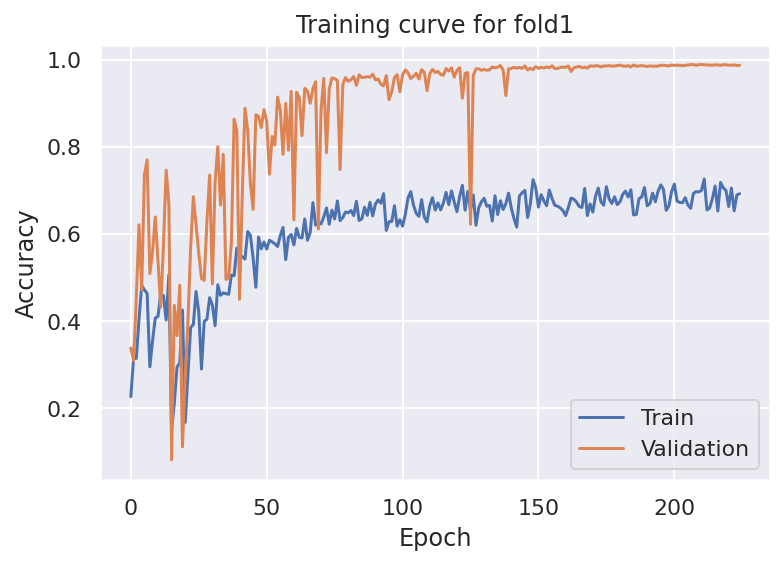

Epoch=0, Train loss=3.30076, Valid loss=9.75121, Train Accuracy=0.23154, Validation Accuracy=0.28748
Epoch=10, Train loss=2.08073, Valid loss=2.46360, Train Accuracy=0.52232, Validation Accuracy=0.68610
Epoch=20, Train loss=2.51472, Valid loss=2.59397, Train Accuracy=0.22476, Validation Accuracy=0.14473
Epoch=30, Train loss=1.99351, Valid loss=0.90306, Train Accuracy=0.48064, Validation Accuracy=0.81131
Epoch=40, Train loss=1.89682, Valid loss=1.76486, Train Accuracy=0.53779, Validation Accuracy=0.75525
Epoch=50, Train loss=1.80997, Valid loss=1.63693, Train Accuracy=0.56559, Validation Accuracy=0.62213
Epoch=60, Train loss=1.57017, Valid loss=0.70144, Train Accuracy=0.65980, Validation Accuracy=0.88046
Epoch=70, Train loss=1.62473, Valid loss=0.53524, Train Accuracy=0.63427, Validation Accuracy=0.95406
Epoch=80, Train loss=1.56050, Valid loss=0.63155, Train Accuracy=0.66062, Validation Accuracy=0.94838
Epoch=90, Train loss=1.53126, Valid loss=0.63679, Train Accuracy=0.67166, Validatio

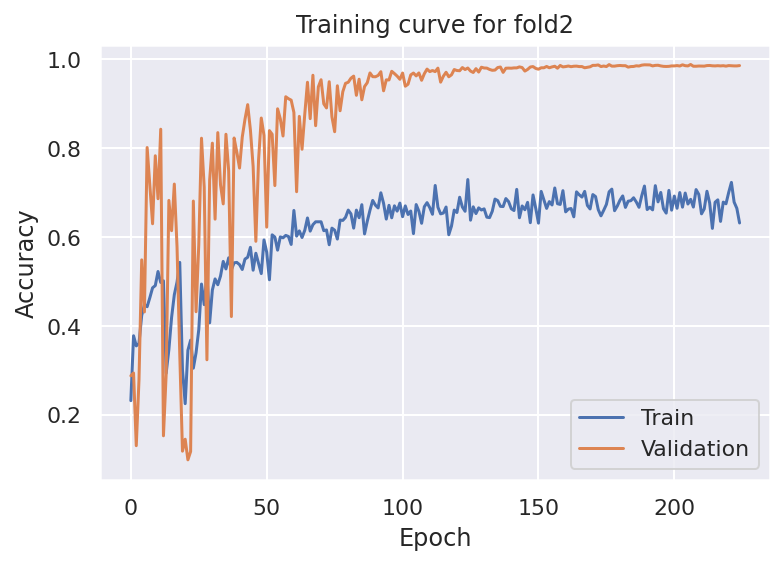

Epoch=0, Train loss=3.46014, Valid loss=2.56159, Train Accuracy=0.20453, Validation Accuracy=0.15930
Epoch=10, Train loss=2.49235, Valid loss=2.64226, Train Accuracy=0.33193, Validation Accuracy=0.55026
Epoch=20, Train loss=2.07928, Valid loss=20.21986, Train Accuracy=0.46902, Validation Accuracy=0.39985
Epoch=30, Train loss=2.00659, Valid loss=38.82485, Train Accuracy=0.49291, Validation Accuracy=0.26056
Epoch=40, Train loss=1.91350, Valid loss=0.90374, Train Accuracy=0.53354, Validation Accuracy=0.87182
Epoch=50, Train loss=1.65010, Valid loss=0.77933, Train Accuracy=0.63551, Validation Accuracy=0.88960
Epoch=60, Train loss=1.64950, Valid loss=1.34336, Train Accuracy=0.62452, Validation Accuracy=0.60657
Epoch=70, Train loss=1.58094, Valid loss=0.50463, Train Accuracy=0.65117, Validation Accuracy=0.95307
Epoch=80, Train loss=1.60025, Valid loss=1.18101, Train Accuracy=0.64245, Validation Accuracy=0.79328
Epoch=90, Train loss=1.55929, Valid loss=0.73674, Train Accuracy=0.65964, Validat

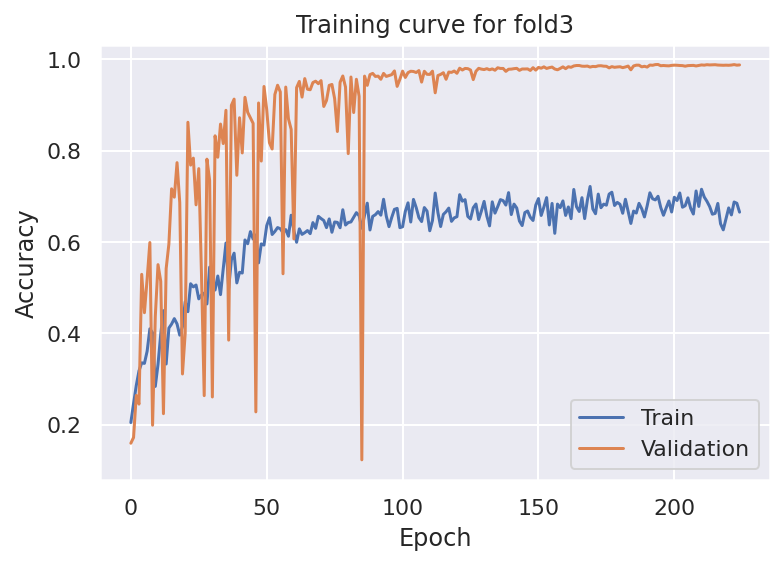

Epoch=0, Train loss=3.43717, Valid loss=18.42354, Train Accuracy=0.22938, Validation Accuracy=0.26327
Epoch=10, Train loss=2.13956, Valid loss=1.38402, Train Accuracy=0.47390, Validation Accuracy=0.63769
Epoch=20, Train loss=2.17696, Valid loss=82.67959, Train Accuracy=0.43591, Validation Accuracy=0.22005
Epoch=30, Train loss=2.13230, Valid loss=1.47879, Train Accuracy=0.43030, Validation Accuracy=0.70783
Epoch=40, Train loss=1.95530, Valid loss=1.01491, Train Accuracy=0.52356, Validation Accuracy=0.84292
Epoch=50, Train loss=1.67864, Valid loss=0.64941, Train Accuracy=0.61669, Validation Accuracy=0.94739
Epoch=60, Train loss=1.62665, Valid loss=0.95119, Train Accuracy=0.63309, Validation Accuracy=0.79723
Epoch=70, Train loss=1.58758, Valid loss=0.69210, Train Accuracy=0.64917, Validation Accuracy=0.93035
Epoch=80, Train loss=1.58519, Valid loss=0.55116, Train Accuracy=0.64790, Validation Accuracy=0.96518
Epoch=90, Train loss=1.59529, Valid loss=0.77914, Train Accuracy=0.64577, Validat

In [ ]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet50"
optim_name = "adam"
epochs = 225
lr = 1e-3
wd = 5e-4
oof, targs = run_pl(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True, version=2)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

### Efficientnet

Epoch=0, Train loss=2.48564, Valid loss=2.30500, Train Accuracy=0.11963, Validation Accuracy=0.11491
Epoch=10, Train loss=1.90798, Valid loss=1.44804, Train Accuracy=0.44750, Validation Accuracy=0.51589
Epoch=20, Train loss=1.59550, Valid loss=1.04859, Train Accuracy=0.62439, Validation Accuracy=0.74817
Epoch=30, Train loss=1.50692, Valid loss=0.93351, Train Accuracy=0.66106, Validation Accuracy=0.76528
Epoch=40, Train loss=1.34777, Valid loss=0.87297, Train Accuracy=0.73194, Validation Accuracy=0.77995
Epoch=50, Train loss=1.55436, Valid loss=0.80917, Train Accuracy=0.66515, Validation Accuracy=0.81663
Epoch=60, Train loss=1.85223, Valid loss=1.02621, Train Accuracy=0.53533, Validation Accuracy=0.82152
Epoch=70, Train loss=1.50044, Valid loss=0.82690, Train Accuracy=0.68779, Validation Accuracy=0.81907
Epoch=80, Train loss=1.74814, Valid loss=0.97350, Train Accuracy=0.58029, Validation Accuracy=0.82885
Epoch=90, Train loss=1.78748, Valid loss=1.01686, Train Accuracy=0.56996, Validatio

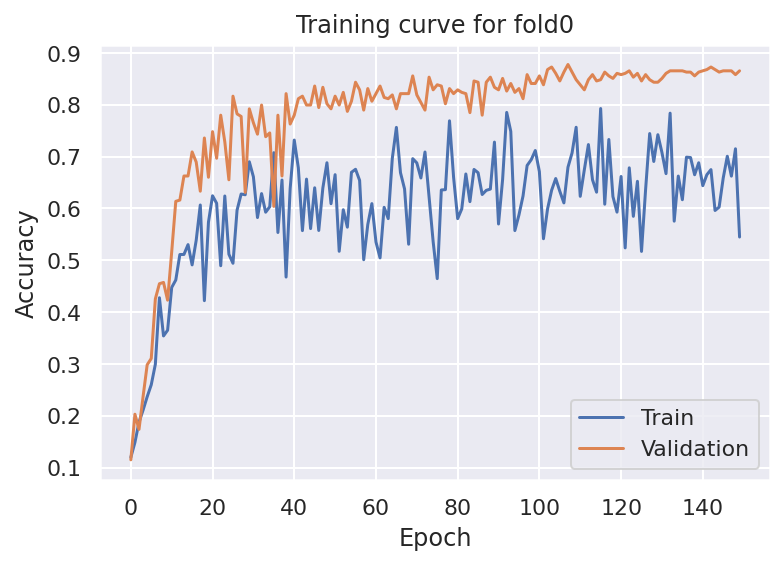

Epoch=0, Train loss=2.51758, Valid loss=2.30026, Train Accuracy=0.09626, Validation Accuracy=0.10976
Epoch=10, Train loss=1.77408, Valid loss=1.30438, Train Accuracy=0.50429, Validation Accuracy=0.58049
Epoch=20, Train loss=1.52251, Valid loss=0.95857, Train Accuracy=0.64670, Validation Accuracy=0.76585
Epoch=30, Train loss=1.52791, Valid loss=0.93035, Train Accuracy=0.65589, Validation Accuracy=0.77805
Epoch=40, Train loss=1.71004, Valid loss=1.04530, Train Accuracy=0.58050, Validation Accuracy=0.76585
Epoch=50, Train loss=1.61019, Valid loss=0.95594, Train Accuracy=0.63797, Validation Accuracy=0.81951
Epoch=60, Train loss=1.54145, Valid loss=0.99739, Train Accuracy=0.66308, Validation Accuracy=0.78537
Epoch=70, Train loss=1.61778, Valid loss=0.87136, Train Accuracy=0.63267, Validation Accuracy=0.82683
Epoch=80, Train loss=1.88179, Valid loss=1.03390, Train Accuracy=0.52415, Validation Accuracy=0.83902
Epoch=90, Train loss=1.58123, Valid loss=0.85601, Train Accuracy=0.65322, Validatio

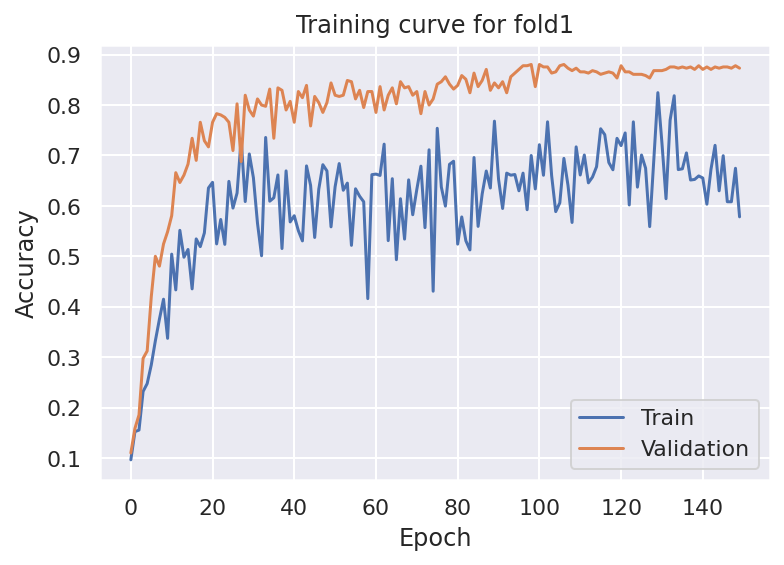

Epoch=0, Train loss=2.48232, Valid loss=2.32575, Train Accuracy=0.10794, Validation Accuracy=0.09268
Epoch=10, Train loss=1.73691, Valid loss=1.71514, Train Accuracy=0.53422, Validation Accuracy=0.50976
Epoch=20, Train loss=1.88065, Valid loss=1.31862, Train Accuracy=0.50297, Validation Accuracy=0.71951
Epoch=30, Train loss=1.75587, Valid loss=1.01160, Train Accuracy=0.56606, Validation Accuracy=0.79756
Epoch=40, Train loss=1.68331, Valid loss=1.18140, Train Accuracy=0.60311, Validation Accuracy=0.75122
Epoch=50, Train loss=1.70904, Valid loss=0.93241, Train Accuracy=0.59092, Validation Accuracy=0.79756
Epoch=60, Train loss=1.31724, Valid loss=0.89223, Train Accuracy=0.74989, Validation Accuracy=0.79512
Epoch=70, Train loss=1.64935, Valid loss=0.89657, Train Accuracy=0.61965, Validation Accuracy=0.79268
Epoch=80, Train loss=1.92285, Valid loss=1.03679, Train Accuracy=0.50717, Validation Accuracy=0.81463
Epoch=90, Train loss=1.51301, Valid loss=0.78081, Train Accuracy=0.68227, Validatio

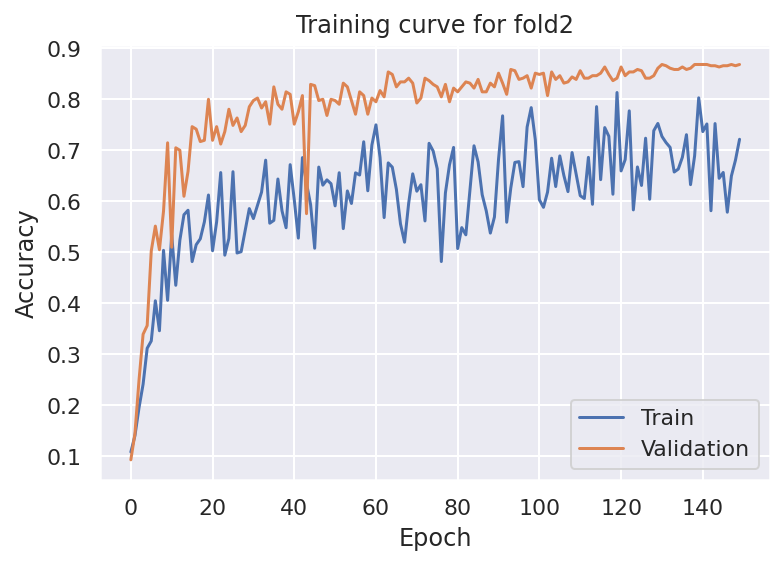

Epoch=0, Train loss=2.47679, Valid loss=2.30115, Train Accuracy=0.10183, Validation Accuracy=0.11951
Epoch=10, Train loss=1.94605, Valid loss=1.77919, Train Accuracy=0.42544, Validation Accuracy=0.54878
Epoch=20, Train loss=1.76105, Valid loss=1.19003, Train Accuracy=0.54374, Validation Accuracy=0.73415
Epoch=30, Train loss=1.72387, Valid loss=0.90491, Train Accuracy=0.59260, Validation Accuracy=0.79512
Epoch=40, Train loss=1.81884, Valid loss=1.11194, Train Accuracy=0.54721, Validation Accuracy=0.79024
Epoch=50, Train loss=1.60161, Valid loss=0.99413, Train Accuracy=0.63050, Validation Accuracy=0.80488
Epoch=60, Train loss=1.78634, Valid loss=1.11098, Train Accuracy=0.55737, Validation Accuracy=0.81707
Epoch=70, Train loss=1.73558, Valid loss=0.90753, Train Accuracy=0.58265, Validation Accuracy=0.85854
Epoch=80, Train loss=1.55435, Valid loss=0.79951, Train Accuracy=0.65977, Validation Accuracy=0.83659
Epoch=90, Train loss=1.26039, Valid loss=0.70386, Train Accuracy=0.77071, Validatio

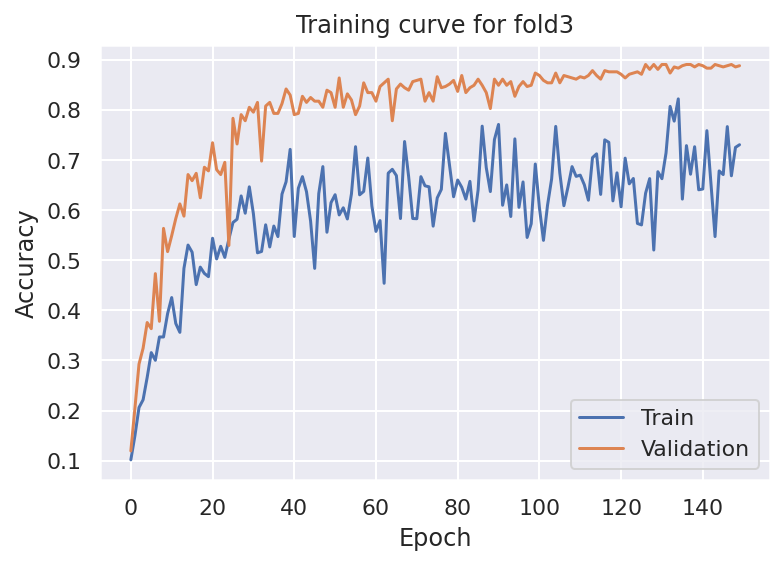

Epoch=0, Train loss=2.53101, Valid loss=2.31825, Train Accuracy=0.11081, Validation Accuracy=0.10269
Epoch=10, Train loss=1.89483, Valid loss=1.59797, Train Accuracy=0.45119, Validation Accuracy=0.48166
Epoch=20, Train loss=1.68177, Valid loss=1.17974, Train Accuracy=0.58346, Validation Accuracy=0.66748
Epoch=30, Train loss=1.72426, Valid loss=0.94582, Train Accuracy=0.57855, Validation Accuracy=0.76039
Epoch=40, Train loss=1.63276, Valid loss=0.94821, Train Accuracy=0.63242, Validation Accuracy=0.80929
Epoch=50, Train loss=1.89721, Valid loss=1.12385, Train Accuracy=0.50002, Validation Accuracy=0.79218
Epoch=60, Train loss=1.68761, Valid loss=0.99668, Train Accuracy=0.60776, Validation Accuracy=0.78484
Epoch=70, Train loss=1.69532, Valid loss=0.89943, Train Accuracy=0.60502, Validation Accuracy=0.81663
Epoch=80, Train loss=1.51315, Valid loss=0.87009, Train Accuracy=0.68269, Validation Accuracy=0.81663
Epoch=90, Train loss=1.51321, Valid loss=0.87764, Train Accuracy=0.68174, Validatio

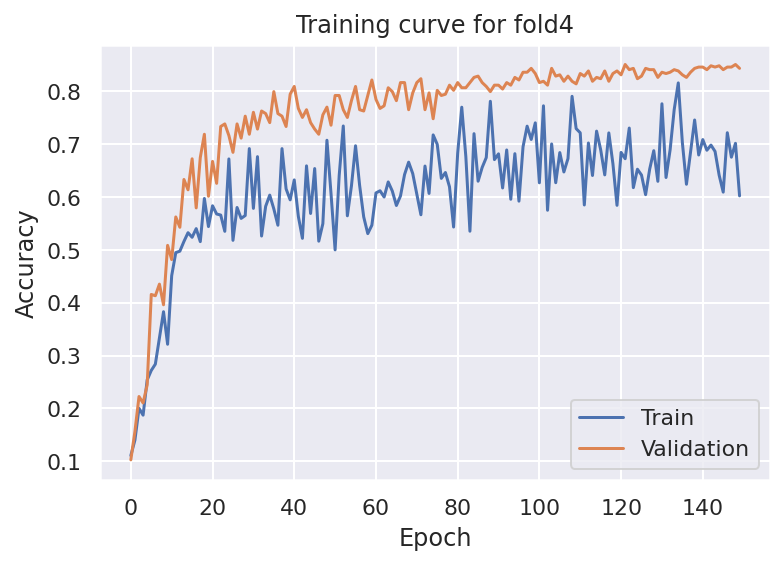

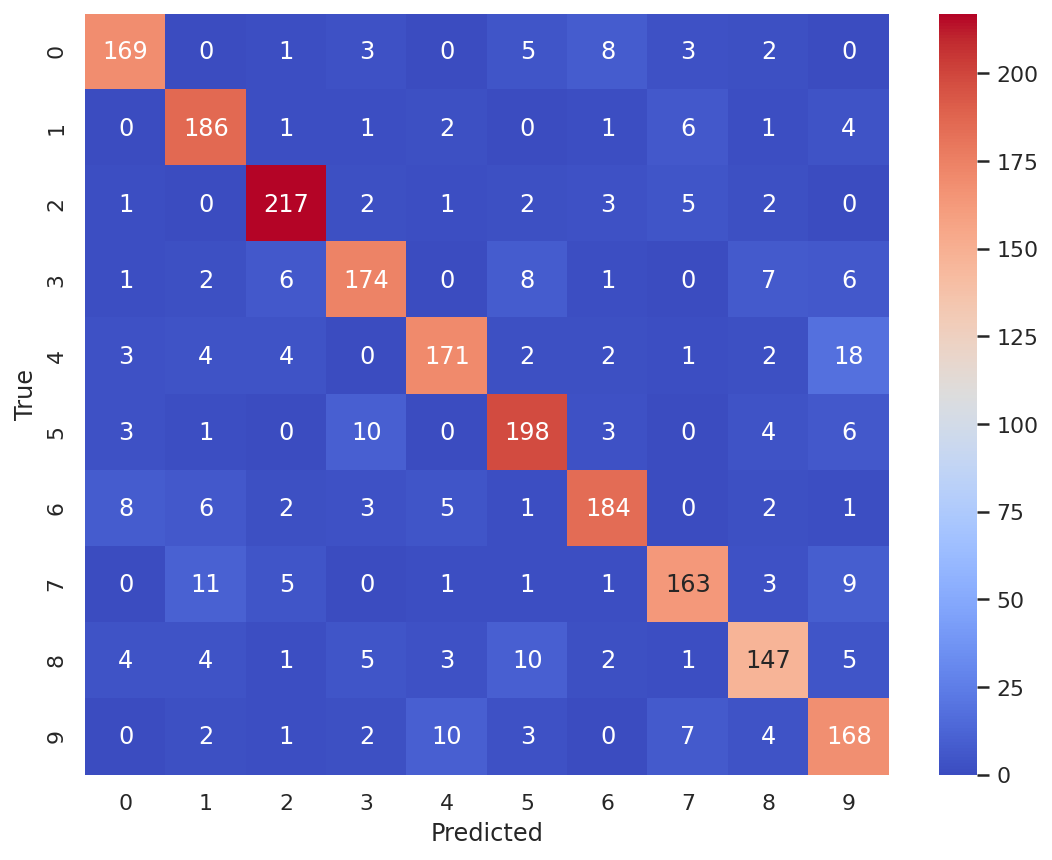

              precision    recall  f1-score   support

         0.0       0.89      0.88      0.89       191
         1.0       0.86      0.92      0.89       202
         2.0       0.91      0.93      0.92       233
         3.0       0.87      0.85      0.86       205
         4.0       0.89      0.83      0.85       207
         5.0       0.86      0.88      0.87       225
         6.0       0.90      0.87      0.88       212
         7.0       0.88      0.84      0.86       194
         8.0       0.84      0.81      0.83       182
         9.0       0.77      0.85      0.81       197

    accuracy                           0.87      2048
   macro avg       0.87      0.87      0.87      2048
weighted avg       0.87      0.87      0.87      2048

CV Accuracy Score=0.86767578125
model=efficientnetb0, optimizer=adam, epochs=150, lr=0.003, wd=0.0001
CPU times: user 16min 7s, sys: 3min 12s, total: 19min 19s
Wall time: 20min 20s


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "efficientnetb0"
optim_name = "adam"
epochs = 150
lr = 3e-3
wd = 1e-4
oof, targs = run(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

### 1.1

Epoch=0, Train loss=4.63888, Valid loss=13395.35032, Train Accuracy=0.10044, Validation Accuracy=0.10024
Epoch=10, Train loss=2.36484, Valid loss=5.11289, Train Accuracy=0.18264, Validation Accuracy=0.12225
Epoch=20, Train loss=2.07415, Valid loss=1.65523, Train Accuracy=0.34439, Validation Accuracy=0.47677
Epoch=30, Train loss=2.11137, Valid loss=1.93884, Train Accuracy=0.38403, Validation Accuracy=0.48655
Epoch=40, Train loss=2.04840, Valid loss=1.41125, Train Accuracy=0.43175, Validation Accuracy=0.68215
Epoch=50, Train loss=1.74775, Valid loss=1.00212, Train Accuracy=0.56018, Validation Accuracy=0.75795
Epoch=60, Train loss=1.62234, Valid loss=0.79021, Train Accuracy=0.62298, Validation Accuracy=0.83863
Epoch=70, Train loss=1.78584, Valid loss=0.95891, Train Accuracy=0.56447, Validation Accuracy=0.84352
Epoch=80, Train loss=1.68347, Valid loss=0.86701, Train Accuracy=0.60769, Validation Accuracy=0.87775
Epoch=90, Train loss=1.58598, Valid loss=0.77261, Train Accuracy=0.65169, Valid

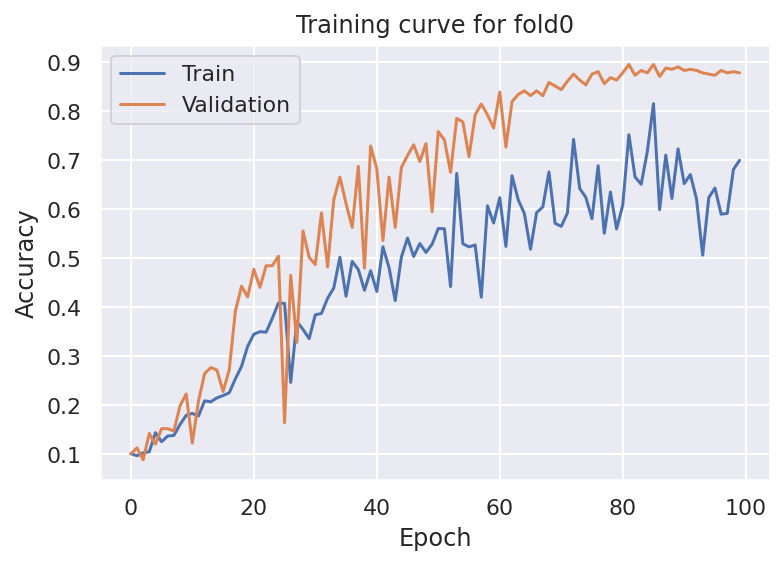

Epoch=0, Train loss=3.87910, Valid loss=8765.53419, Train Accuracy=0.09172, Validation Accuracy=0.06098
Epoch=10, Train loss=2.35702, Valid loss=2.37721, Train Accuracy=0.15226, Validation Accuracy=0.19268
Epoch=20, Train loss=2.27516, Valid loss=2.25161, Train Accuracy=0.22198, Validation Accuracy=0.27561
Epoch=30, Train loss=2.11332, Valid loss=2.80530, Train Accuracy=0.33649, Validation Accuracy=0.21220
Epoch=40, Train loss=1.93395, Valid loss=1.43237, Train Accuracy=0.45673, Validation Accuracy=0.61707
Epoch=50, Train loss=1.80775, Valid loss=0.91470, Train Accuracy=0.53805, Validation Accuracy=0.77317
Epoch=60, Train loss=1.79696, Valid loss=1.47297, Train Accuracy=0.54488, Validation Accuracy=0.65610
Epoch=70, Train loss=1.61938, Valid loss=0.99090, Train Accuracy=0.62620, Validation Accuracy=0.81220
Epoch=80, Train loss=1.55435, Valid loss=0.73984, Train Accuracy=0.66068, Validation Accuracy=0.87805
Epoch=90, Train loss=1.57543, Valid loss=0.69964, Train Accuracy=0.65324, Valida

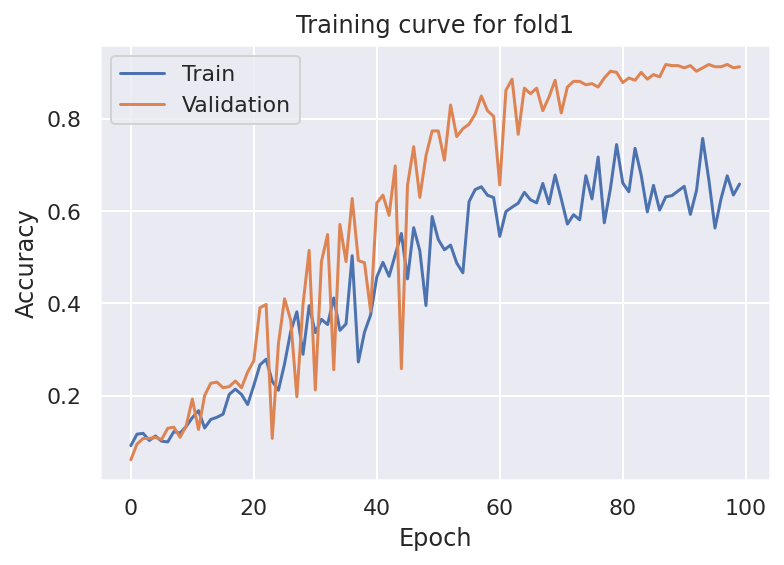

Epoch=0, Train loss=4.29714, Valid loss=4743.15369, Train Accuracy=0.09408, Validation Accuracy=0.09024
Epoch=10, Train loss=2.33644, Valid loss=2.14024, Train Accuracy=0.13732, Validation Accuracy=0.23659
Epoch=20, Train loss=2.12228, Valid loss=10.17418, Train Accuracy=0.33942, Validation Accuracy=0.23902
Epoch=30, Train loss=2.04218, Valid loss=1.61285, Train Accuracy=0.39419, Validation Accuracy=0.50000
Epoch=40, Train loss=1.90367, Valid loss=1.36410, Train Accuracy=0.49615, Validation Accuracy=0.69268
Epoch=50, Train loss=1.69525, Valid loss=1.01159, Train Accuracy=0.59008, Validation Accuracy=0.79512
Epoch=60, Train loss=1.64817, Valid loss=0.84940, Train Accuracy=0.62084, Validation Accuracy=0.80976
Epoch=70, Train loss=1.66918, Valid loss=0.85071, Train Accuracy=0.62174, Validation Accuracy=0.85366
Epoch=80, Train loss=1.52281, Valid loss=0.71319, Train Accuracy=0.67850, Validation Accuracy=0.86585
Epoch=90, Train loss=1.61996, Valid loss=0.75551, Train Accuracy=0.63842, Valid

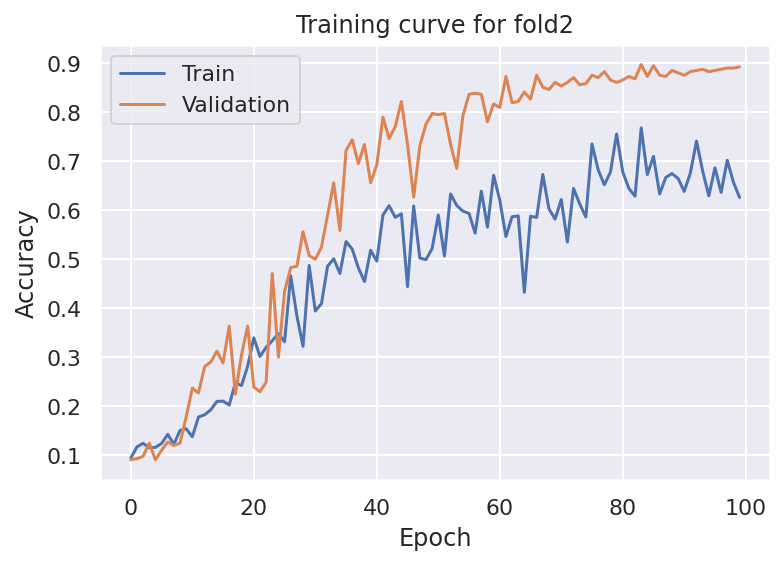

Epoch=0, Train loss=4.52322, Valid loss=2.77394, Train Accuracy=0.09979, Validation Accuracy=0.06341
Epoch=10, Train loss=2.27961, Valid loss=2.21773, Train Accuracy=0.23161, Validation Accuracy=0.30976
Epoch=20, Train loss=2.07365, Valid loss=1.57737, Train Accuracy=0.40545, Validation Accuracy=0.52195
Epoch=30, Train loss=2.05287, Valid loss=1.80298, Train Accuracy=0.39761, Validation Accuracy=0.53171
Epoch=40, Train loss=1.95317, Valid loss=1.22737, Train Accuracy=0.46544, Validation Accuracy=0.69268
Epoch=50, Train loss=1.73492, Valid loss=0.77364, Train Accuracy=0.56506, Validation Accuracy=0.84390
Epoch=60, Train loss=1.85977, Valid loss=1.02815, Train Accuracy=0.52092, Validation Accuracy=0.86341
Epoch=70, Train loss=1.80051, Valid loss=0.89801, Train Accuracy=0.55672, Validation Accuracy=0.87073
Epoch=80, Train loss=1.60994, Valid loss=0.74637, Train Accuracy=0.63624, Validation Accuracy=0.89024
Epoch=90, Train loss=1.78723, Valid loss=0.76425, Train Accuracy=0.56160, Validatio

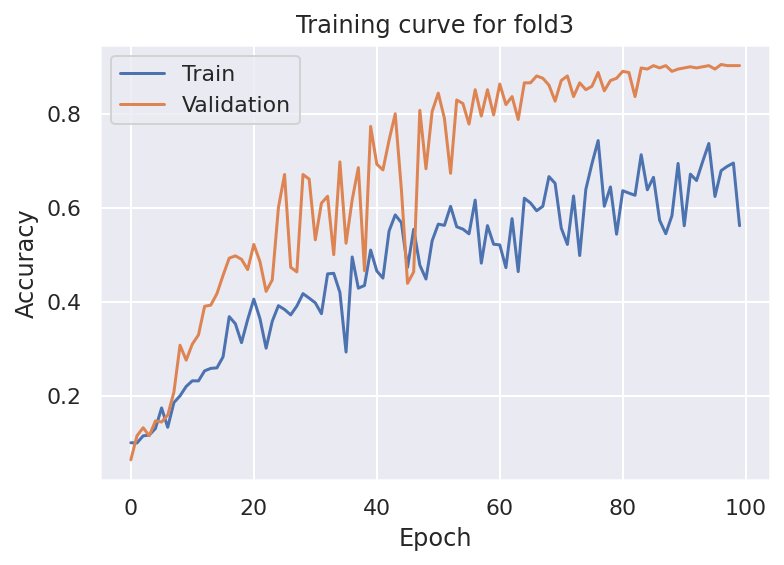

Epoch=0, Train loss=4.46541, Valid loss=21374.81981, Train Accuracy=0.10406, Validation Accuracy=0.10024
Epoch=10, Train loss=2.33029, Valid loss=2.25247, Train Accuracy=0.22771, Validation Accuracy=0.19804
Epoch=20, Train loss=2.01705, Valid loss=1.67745, Train Accuracy=0.41513, Validation Accuracy=0.50611
Epoch=30, Train loss=2.06831, Valid loss=2.86915, Train Accuracy=0.37046, Validation Accuracy=0.35941
Epoch=40, Train loss=1.95092, Valid loss=1.55110, Train Accuracy=0.46346, Validation Accuracy=0.53790
Epoch=50, Train loss=1.96952, Valid loss=1.08720, Train Accuracy=0.44408, Validation Accuracy=0.78729
Epoch=60, Train loss=1.61823, Valid loss=0.94143, Train Accuracy=0.63812, Validation Accuracy=0.82152
Epoch=70, Train loss=1.70925, Valid loss=1.23105, Train Accuracy=0.58911, Validation Accuracy=0.76284
Epoch=80, Train loss=1.67255, Valid loss=0.80526, Train Accuracy=0.60898, Validation Accuracy=0.86308
Epoch=90, Train loss=1.95236, Valid loss=0.94490, Train Accuracy=0.49258, Valid

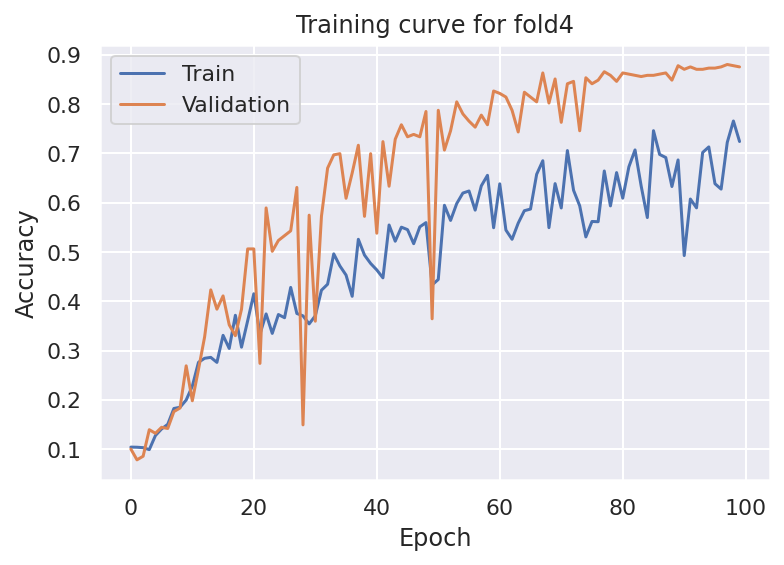

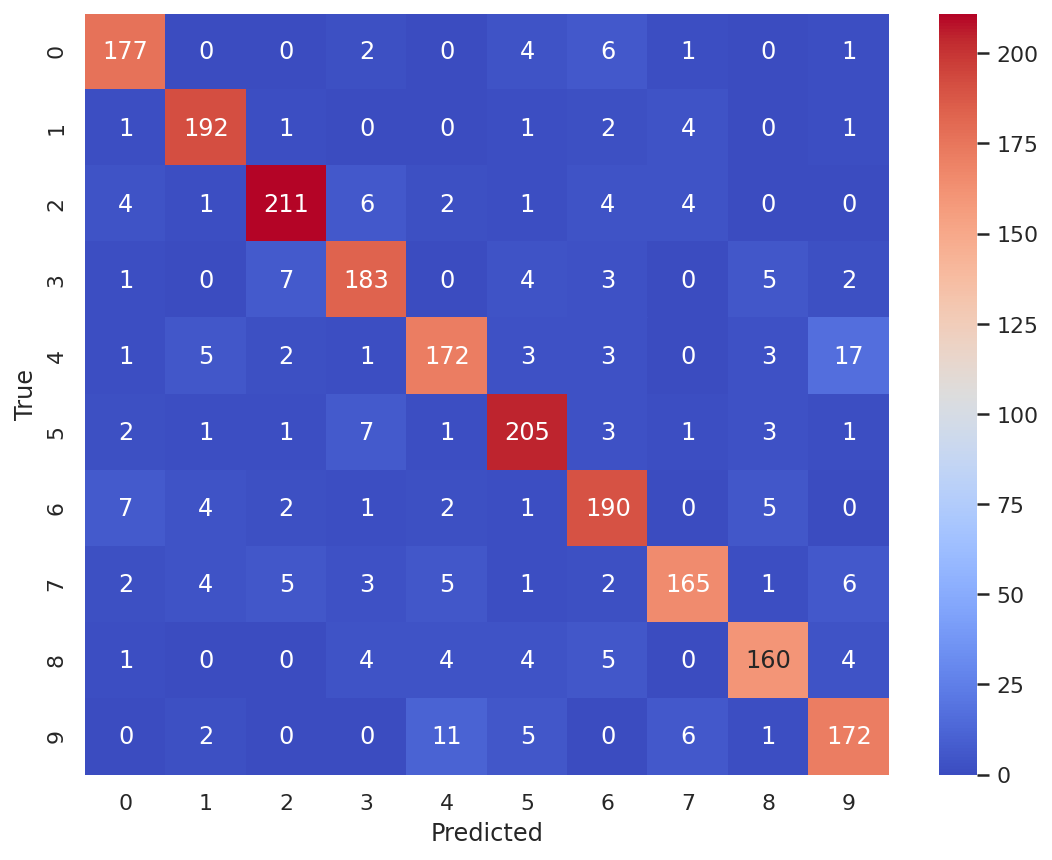

              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91       191
         1.0       0.92      0.95      0.93       202
         2.0       0.92      0.91      0.91       233
         3.0       0.88      0.89      0.89       205
         4.0       0.87      0.83      0.85       207
         5.0       0.90      0.91      0.90       225
         6.0       0.87      0.90      0.88       212
         7.0       0.91      0.85      0.88       194
         8.0       0.90      0.88      0.89       182
         9.0       0.84      0.87      0.86       197

    accuracy                           0.89      2048
   macro avg       0.89      0.89      0.89      2048
weighted avg       0.89      0.89      0.89      2048

CV Accuracy Score=0.89208984375
model=resnet34, optimizer=adam, epochs=100, lr=0.003, wd=0.0005
CPU times: user 8min 1s, sys: 55.1 s, total: 8min 56s
Wall time: 9min 29s


In [22]:
%%time
# With scaling
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "adam"
epochs = 100
lr = 3e-3
wd = 5e-4
oof, targs = run(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

### 1.2

Epoch=0, Train loss=2.89014, Valid loss=2.22944, Train Accuracy=0.12039, Validation Accuracy=0.13692
Epoch=10, Train loss=1.99330, Valid loss=2.21154, Train Accuracy=0.43569, Validation Accuracy=0.19071
Epoch=20, Train loss=2.10465, Valid loss=1.73553, Train Accuracy=0.43873, Validation Accuracy=0.50367
Epoch=30, Train loss=1.68626, Valid loss=1.26733, Train Accuracy=0.61502, Validation Accuracy=0.66015
Epoch=40, Train loss=1.51615, Valid loss=1.01355, Train Accuracy=0.70269, Validation Accuracy=0.75550
Epoch=50, Train loss=1.41043, Valid loss=0.72664, Train Accuracy=0.73808, Validation Accuracy=0.85086
Epoch=60, Train loss=1.89585, Valid loss=1.04053, Train Accuracy=0.53173, Validation Accuracy=0.79951
Epoch=70, Train loss=1.63782, Valid loss=0.88340, Train Accuracy=0.63932, Validation Accuracy=0.85575
Epoch=80, Train loss=1.43326, Valid loss=0.74626, Train Accuracy=0.72723, Validation Accuracy=0.89731
Epoch=90, Train loss=1.35378, Valid loss=0.76353, Train Accuracy=0.74526, Validatio

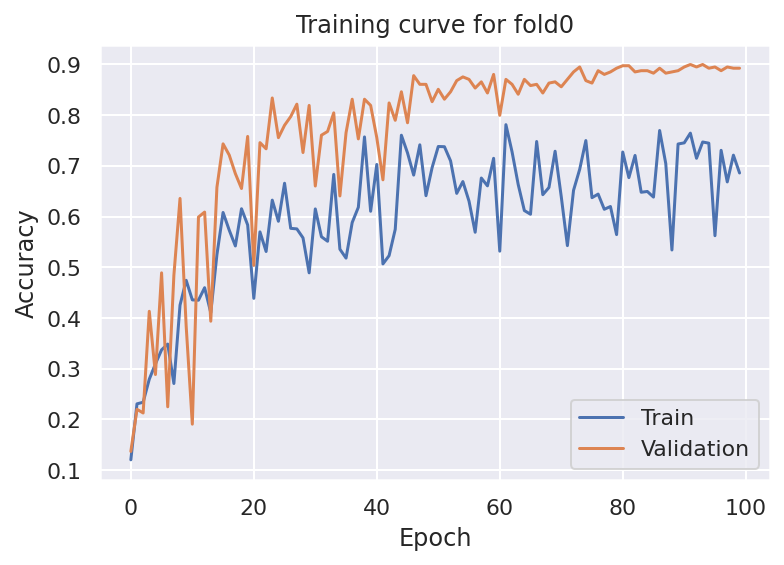

Epoch=0, Train loss=4.04853, Valid loss=6.02057, Train Accuracy=0.13489, Validation Accuracy=0.16829
Epoch=10, Train loss=2.01853, Valid loss=1.19131, Train Accuracy=0.40774, Validation Accuracy=0.65122
Epoch=20, Train loss=1.98389, Valid loss=2.02925, Train Accuracy=0.45997, Validation Accuracy=0.69512
Epoch=30, Train loss=1.94502, Valid loss=1.09993, Train Accuracy=0.48339, Validation Accuracy=0.75610
Epoch=40, Train loss=1.68221, Valid loss=0.83442, Train Accuracy=0.62497, Validation Accuracy=0.83171
Epoch=50, Train loss=1.70947, Valid loss=0.96362, Train Accuracy=0.60549, Validation Accuracy=0.81951
Epoch=60, Train loss=1.46364, Valid loss=0.73291, Train Accuracy=0.70570, Validation Accuracy=0.87805
Epoch=70, Train loss=1.64840, Valid loss=0.82014, Train Accuracy=0.63638, Validation Accuracy=0.87073
Epoch=80, Train loss=1.88079, Valid loss=0.86911, Train Accuracy=0.54063, Validation Accuracy=0.88049
Epoch=90, Train loss=1.64843, Valid loss=0.73085, Train Accuracy=0.62034, Validatio

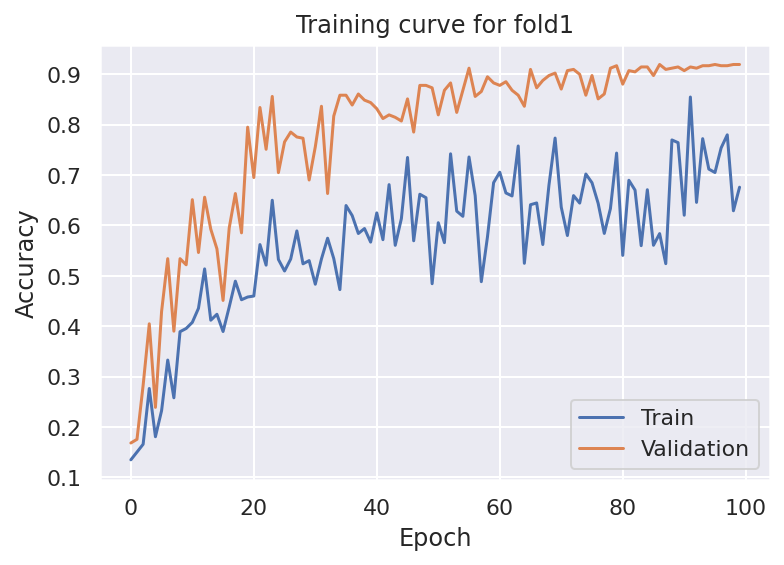

Epoch=0, Train loss=3.23942, Valid loss=2.38127, Train Accuracy=0.12342, Validation Accuracy=0.13659
Epoch=10, Train loss=1.84140, Valid loss=1.10370, Train Accuracy=0.49191, Validation Accuracy=0.64634
Epoch=20, Train loss=1.78066, Valid loss=0.73282, Train Accuracy=0.54794, Validation Accuracy=0.85122
Epoch=30, Train loss=1.71001, Valid loss=0.98300, Train Accuracy=0.60293, Validation Accuracy=0.78780
Epoch=40, Train loss=1.63317, Valid loss=1.25865, Train Accuracy=0.65263, Validation Accuracy=0.70732
Epoch=50, Train loss=1.53939, Valid loss=0.73502, Train Accuracy=0.69190, Validation Accuracy=0.87317
Epoch=60, Train loss=1.45608, Valid loss=0.74164, Train Accuracy=0.70735, Validation Accuracy=0.88049
Epoch=70, Train loss=1.57148, Valid loss=0.73822, Train Accuracy=0.66564, Validation Accuracy=0.89024
Epoch=80, Train loss=1.76110, Valid loss=0.87259, Train Accuracy=0.57654, Validation Accuracy=0.87805
Epoch=90, Train loss=1.72332, Valid loss=0.78943, Train Accuracy=0.59111, Validatio

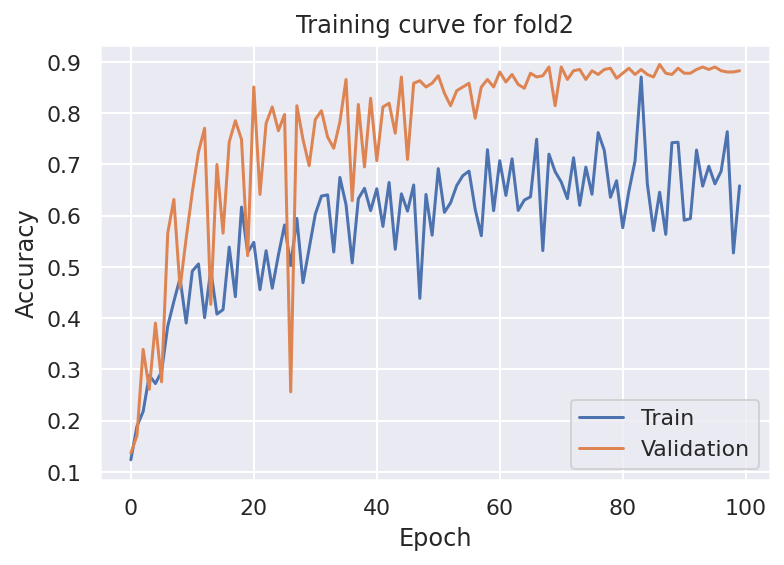

Epoch=0, Train loss=2.61648, Valid loss=2.18700, Train Accuracy=0.12715, Validation Accuracy=0.19512
Epoch=10, Train loss=2.24644, Valid loss=1.71936, Train Accuracy=0.34635, Validation Accuracy=0.38537
Epoch=20, Train loss=2.00698, Valid loss=1.11608, Train Accuracy=0.45018, Validation Accuracy=0.70244
Epoch=30, Train loss=1.88429, Valid loss=1.02248, Train Accuracy=0.51662, Validation Accuracy=0.74146
Epoch=40, Train loss=1.57557, Valid loss=0.96034, Train Accuracy=0.67730, Validation Accuracy=0.81951
Epoch=50, Train loss=1.43891, Valid loss=0.73860, Train Accuracy=0.72950, Validation Accuracy=0.87561
Epoch=60, Train loss=1.39444, Valid loss=0.72463, Train Accuracy=0.74159, Validation Accuracy=0.88537
Epoch=70, Train loss=1.53371, Valid loss=0.76632, Train Accuracy=0.68555, Validation Accuracy=0.87805
Epoch=80, Train loss=1.50104, Valid loss=0.74112, Train Accuracy=0.68422, Validation Accuracy=0.88537
Epoch=90, Train loss=1.57794, Valid loss=0.68913, Train Accuracy=0.65784, Validatio

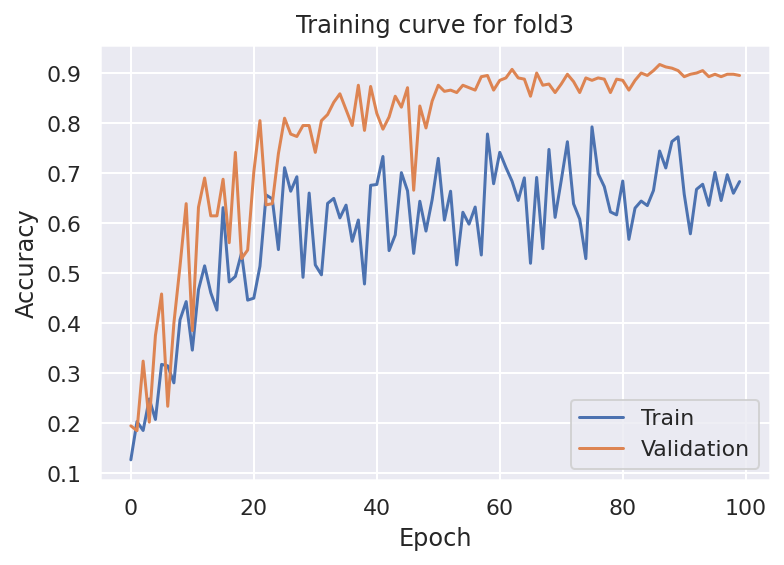

Epoch=0, Train loss=2.68577, Valid loss=2.57125, Train Accuracy=0.15997, Validation Accuracy=0.12958
Epoch=10, Train loss=1.94744, Valid loss=1.29773, Train Accuracy=0.44579, Validation Accuracy=0.59658
Epoch=20, Train loss=2.07040, Valid loss=1.15311, Train Accuracy=0.40877, Validation Accuracy=0.65526
Epoch=30, Train loss=1.83176, Valid loss=1.27496, Train Accuracy=0.55879, Validation Accuracy=0.70905
Epoch=40, Train loss=1.56137, Valid loss=0.93153, Train Accuracy=0.67475, Validation Accuracy=0.80440
Epoch=50, Train loss=1.86905, Valid loss=1.06445, Train Accuracy=0.54106, Validation Accuracy=0.83619
Epoch=60, Train loss=1.60162, Valid loss=0.90511, Train Accuracy=0.65607, Validation Accuracy=0.84352
Epoch=70, Train loss=1.66457, Valid loss=0.92447, Train Accuracy=0.62183, Validation Accuracy=0.86308
Epoch=80, Train loss=1.20482, Valid loss=0.68661, Train Accuracy=0.80674, Validation Accuracy=0.89731
Epoch=90, Train loss=1.42957, Valid loss=0.83051, Train Accuracy=0.71922, Validatio

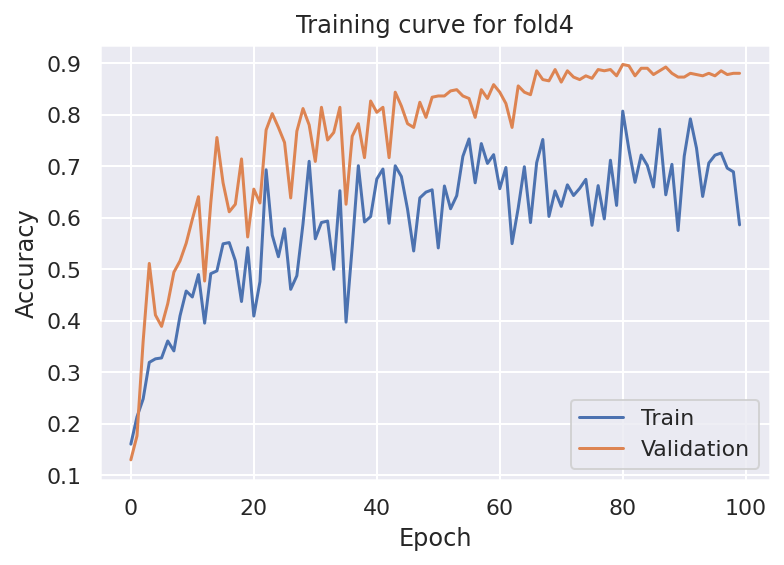

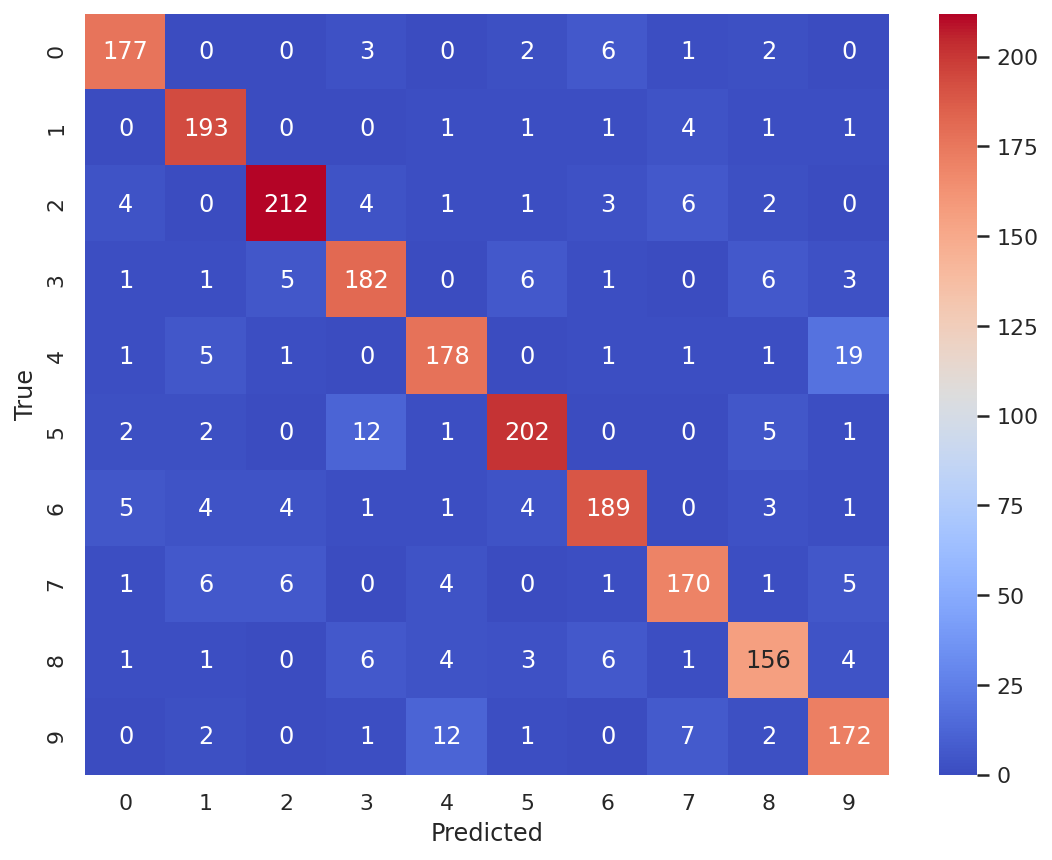

              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92       191
         1.0       0.90      0.96      0.93       202
         2.0       0.93      0.91      0.92       233
         3.0       0.87      0.89      0.88       205
         4.0       0.88      0.86      0.87       207
         5.0       0.92      0.90      0.91       225
         6.0       0.91      0.89      0.90       212
         7.0       0.89      0.88      0.89       194
         8.0       0.87      0.86      0.86       182
         9.0       0.83      0.87      0.85       197

    accuracy                           0.89      2048
   macro avg       0.89      0.89      0.89      2048
weighted avg       0.89      0.89      0.89      2048

CV Accuracy Score=0.89404296875
model=resnet34, optimizer=radam, epochs=100, lr=0.003, wd=0.0005
CPU times: user 7min 57s, sys: 55.4 s, total: 8min 52s
Wall time: 9min 25s


In [23]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0., rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "radam"
epochs = 100
lr = 3e-3
wd = 5e-4
oof, targs = run(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

### 1.3

Epoch=0, Train loss=2.58889, Valid loss=2.56613, Train Accuracy=0.13899, Validation Accuracy=0.13936
Epoch=10, Train loss=1.98644, Valid loss=1.36924, Train Accuracy=0.44816, Validation Accuracy=0.58924
Epoch=20, Train loss=1.71916, Valid loss=0.97937, Train Accuracy=0.57945, Validation Accuracy=0.73105
Epoch=30, Train loss=1.83807, Valid loss=0.93829, Train Accuracy=0.53893, Validation Accuracy=0.83863
Epoch=40, Train loss=1.54177, Valid loss=0.79962, Train Accuracy=0.67925, Validation Accuracy=0.81418
Epoch=50, Train loss=1.60984, Valid loss=0.72299, Train Accuracy=0.64281, Validation Accuracy=0.87775
Epoch=60, Train loss=1.53607, Valid loss=0.71955, Train Accuracy=0.69831, Validation Accuracy=0.84841
Epoch=70, Train loss=1.29711, Valid loss=0.68785, Train Accuracy=0.77283, Validation Accuracy=0.87042
Epoch=80, Train loss=1.60898, Valid loss=0.78133, Train Accuracy=0.64797, Validation Accuracy=0.88509
Epoch=90, Train loss=1.73896, Valid loss=0.85691, Train Accuracy=0.57999, Validatio

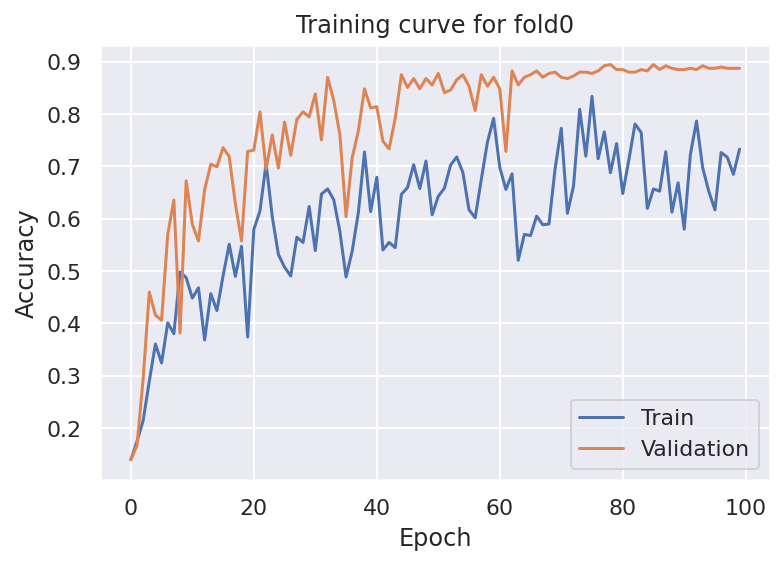

Epoch=0, Train loss=3.04373, Valid loss=2.22090, Train Accuracy=0.13131, Validation Accuracy=0.20976
Epoch=10, Train loss=1.98231, Valid loss=1.19301, Train Accuracy=0.43720, Validation Accuracy=0.67073
Epoch=20, Train loss=2.12393, Valid loss=1.34774, Train Accuracy=0.38034, Validation Accuracy=0.66585
Epoch=30, Train loss=1.55774, Valid loss=1.10857, Train Accuracy=0.66508, Validation Accuracy=0.74634
Epoch=40, Train loss=1.86902, Valid loss=1.28843, Train Accuracy=0.54111, Validation Accuracy=0.72195
Epoch=50, Train loss=1.44671, Valid loss=0.68700, Train Accuracy=0.72880, Validation Accuracy=0.85854
Epoch=60, Train loss=1.40065, Valid loss=0.66674, Train Accuracy=0.73010, Validation Accuracy=0.89512
Epoch=70, Train loss=1.36865, Valid loss=0.67322, Train Accuracy=0.75594, Validation Accuracy=0.89268
Epoch=80, Train loss=1.55039, Valid loss=0.76539, Train Accuracy=0.67358, Validation Accuracy=0.90488
Epoch=90, Train loss=1.54993, Valid loss=0.77568, Train Accuracy=0.66745, Validatio

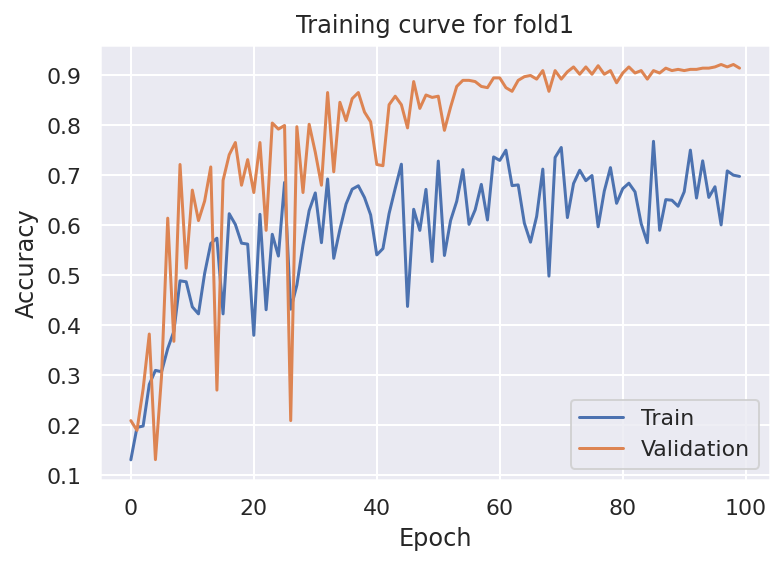

Epoch=0, Train loss=3.11905, Valid loss=2.30081, Train Accuracy=0.13153, Validation Accuracy=0.18537
Epoch=10, Train loss=2.01749, Valid loss=10.91591, Train Accuracy=0.43334, Validation Accuracy=0.19024
Epoch=20, Train loss=1.81577, Valid loss=0.98722, Train Accuracy=0.52748, Validation Accuracy=0.77805
Epoch=30, Train loss=1.73407, Valid loss=1.01856, Train Accuracy=0.59172, Validation Accuracy=0.81463
Epoch=40, Train loss=1.80350, Valid loss=1.29267, Train Accuracy=0.57656, Validation Accuracy=0.77073
Epoch=50, Train loss=1.52256, Valid loss=0.65278, Train Accuracy=0.69981, Validation Accuracy=0.87561
Epoch=60, Train loss=1.53121, Valid loss=0.73533, Train Accuracy=0.68257, Validation Accuracy=0.86585
Epoch=70, Train loss=1.82068, Valid loss=0.94801, Train Accuracy=0.56053, Validation Accuracy=0.86829
Epoch=80, Train loss=1.68897, Valid loss=0.81104, Train Accuracy=0.61821, Validation Accuracy=0.88537
Epoch=90, Train loss=1.49259, Valid loss=0.73868, Train Accuracy=0.68943, Validati

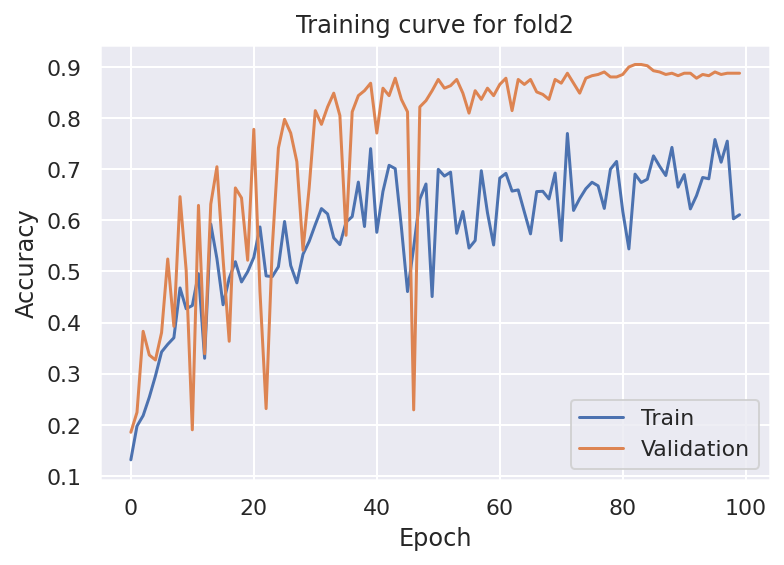

Epoch=0, Train loss=2.94317, Valid loss=2.28610, Train Accuracy=0.13599, Validation Accuracy=0.14146
Epoch=10, Train loss=1.80420, Valid loss=1.03499, Train Accuracy=0.52770, Validation Accuracy=0.71463
Epoch=20, Train loss=1.80046, Valid loss=0.92420, Train Accuracy=0.55199, Validation Accuracy=0.80976
Epoch=30, Train loss=1.50079, Valid loss=0.78894, Train Accuracy=0.69086, Validation Accuracy=0.82195
Epoch=40, Train loss=1.52580, Valid loss=0.74621, Train Accuracy=0.68641, Validation Accuracy=0.86341
Epoch=50, Train loss=1.55260, Valid loss=0.85370, Train Accuracy=0.68060, Validation Accuracy=0.86585
Epoch=60, Train loss=1.59798, Valid loss=0.86142, Train Accuracy=0.65636, Validation Accuracy=0.88780
Epoch=70, Train loss=1.72706, Valid loss=0.89663, Train Accuracy=0.60714, Validation Accuracy=0.90000
Epoch=80, Train loss=1.25794, Valid loss=0.67515, Train Accuracy=0.78654, Validation Accuracy=0.89268
Epoch=90, Train loss=1.44319, Valid loss=0.69273, Train Accuracy=0.70791, Validatio

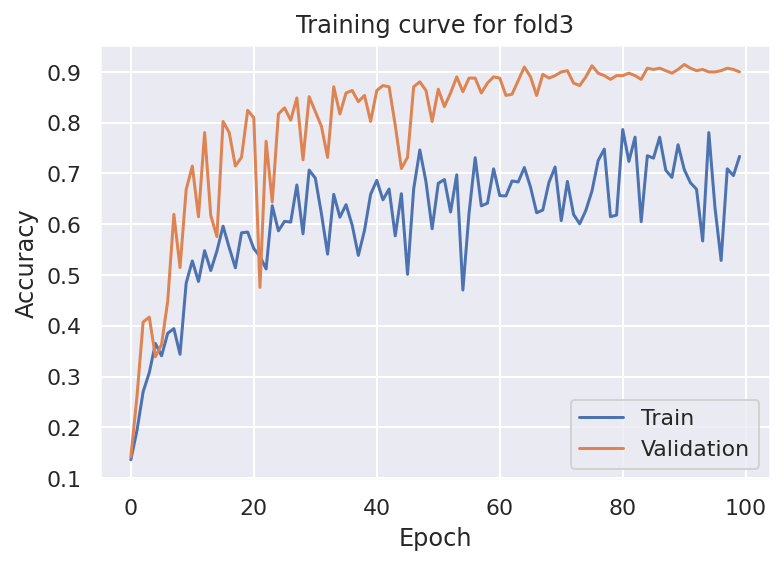

Epoch=0, Train loss=3.14981, Valid loss=2.44405, Train Accuracy=0.12891, Validation Accuracy=0.20049
Epoch=10, Train loss=2.14730, Valid loss=1.59459, Train Accuracy=0.32349, Validation Accuracy=0.51834
Epoch=20, Train loss=1.94396, Valid loss=1.69921, Train Accuracy=0.47616, Validation Accuracy=0.62592
Epoch=30, Train loss=1.82942, Valid loss=1.22799, Train Accuracy=0.53808, Validation Accuracy=0.62103
Epoch=40, Train loss=1.68019, Valid loss=0.82914, Train Accuracy=0.61612, Validation Accuracy=0.85330
Epoch=50, Train loss=1.60540, Valid loss=0.93320, Train Accuracy=0.65849, Validation Accuracy=0.85330
Epoch=60, Train loss=1.90874, Valid loss=1.11664, Train Accuracy=0.51870, Validation Accuracy=0.81907
Epoch=70, Train loss=1.59151, Valid loss=0.85903, Train Accuracy=0.66106, Validation Accuracy=0.87042
Epoch=80, Train loss=1.55003, Valid loss=0.81750, Train Accuracy=0.67090, Validation Accuracy=0.87042
Epoch=90, Train loss=1.69087, Valid loss=0.85411, Train Accuracy=0.60752, Validatio

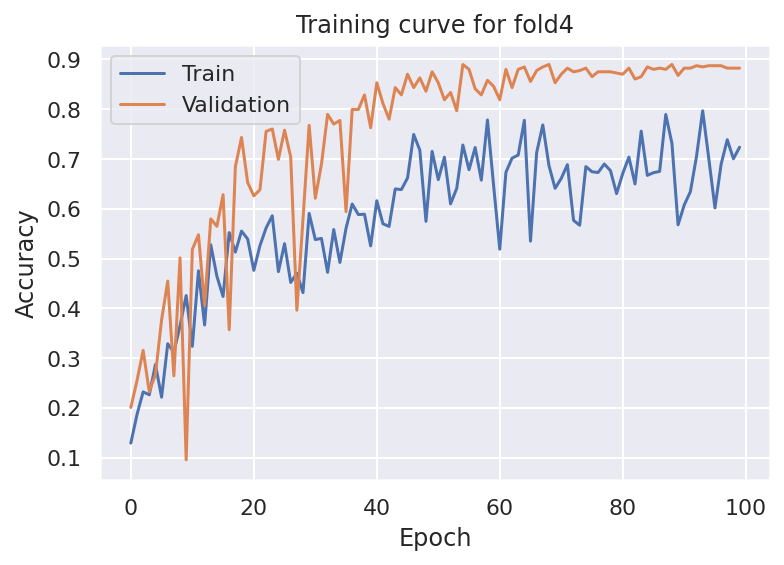

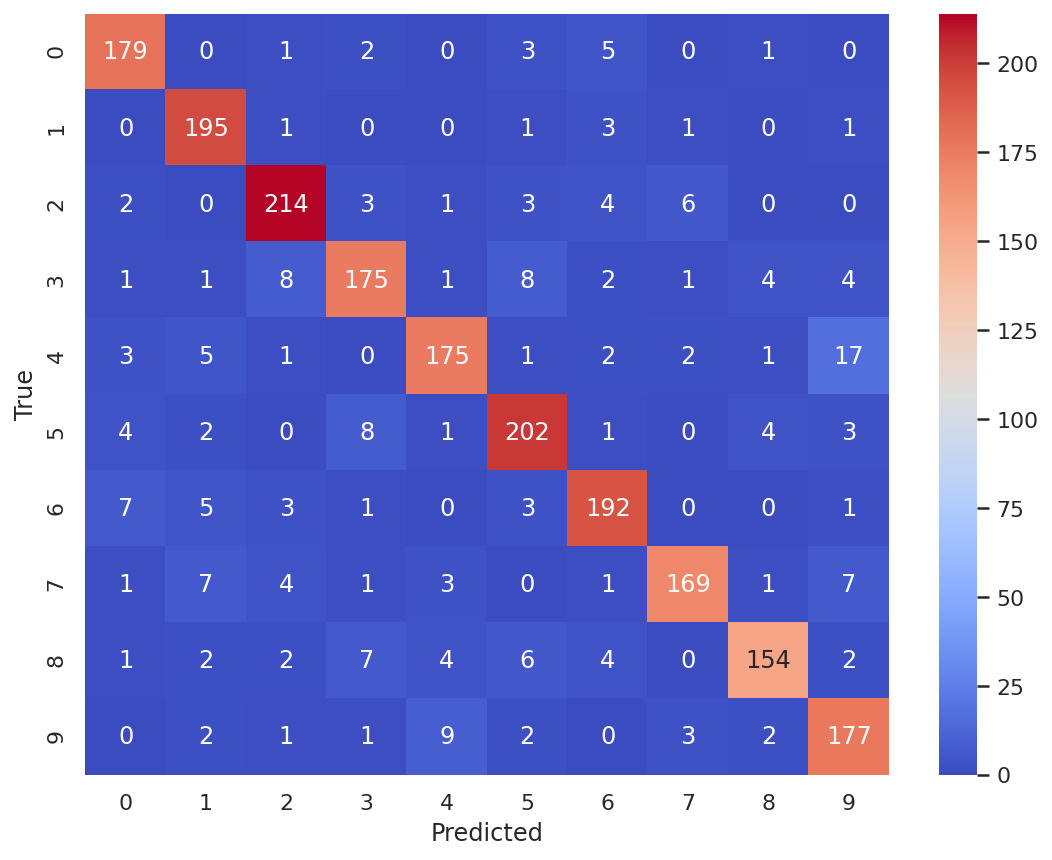

              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       191
         1.0       0.89      0.97      0.93       202
         2.0       0.91      0.92      0.91       233
         3.0       0.88      0.85      0.87       205
         4.0       0.90      0.85      0.87       207
         5.0       0.88      0.90      0.89       225
         6.0       0.90      0.91      0.90       212
         7.0       0.93      0.87      0.90       194
         8.0       0.92      0.85      0.88       182
         9.0       0.83      0.90      0.87       197

    accuracy                           0.89      2048
   macro avg       0.90      0.89      0.89      2048
weighted avg       0.90      0.89      0.89      2048

CV Accuracy Score=0.89453125
model=resnet34, optimizer=radam, epochs=100, lr=0.003, wd=0.0005
CPU times: user 7min 57s, sys: 54.7 s, total: 8min 51s
Wall time: 9min 24s


In [25]:
%%time
# With Scaling
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "radam"
epochs = 100
lr = 3e-3
wd = 5e-4
oof, targs = run(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

### 2.0

Epoch=0, Train loss=2.32986, Valid loss=2.34194, Train Accuracy=0.12872, Validation Accuracy=0.11980
Epoch=10, Train loss=2.10738, Valid loss=2.02650, Train Accuracy=0.30623, Validation Accuracy=0.20782
Epoch=20, Train loss=1.98205, Valid loss=1.72713, Train Accuracy=0.41830, Validation Accuracy=0.43765
Epoch=30, Train loss=1.97708, Valid loss=1.45774, Train Accuracy=0.42175, Validation Accuracy=0.56479
Epoch=40, Train loss=1.72967, Valid loss=1.22373, Train Accuracy=0.57695, Validation Accuracy=0.72861
Epoch=50, Train loss=1.63567, Valid loss=0.96027, Train Accuracy=0.63771, Validation Accuracy=0.78240
Epoch=60, Train loss=1.74945, Valid loss=1.09493, Train Accuracy=0.57607, Validation Accuracy=0.77262
Epoch=70, Train loss=1.84367, Valid loss=1.05568, Train Accuracy=0.52209, Validation Accuracy=0.81418
Epoch=80, Train loss=1.76682, Valid loss=0.95473, Train Accuracy=0.58410, Validation Accuracy=0.81418
Epoch=90, Train loss=1.62955, Valid loss=1.14923, Train Accuracy=0.63839, Validatio

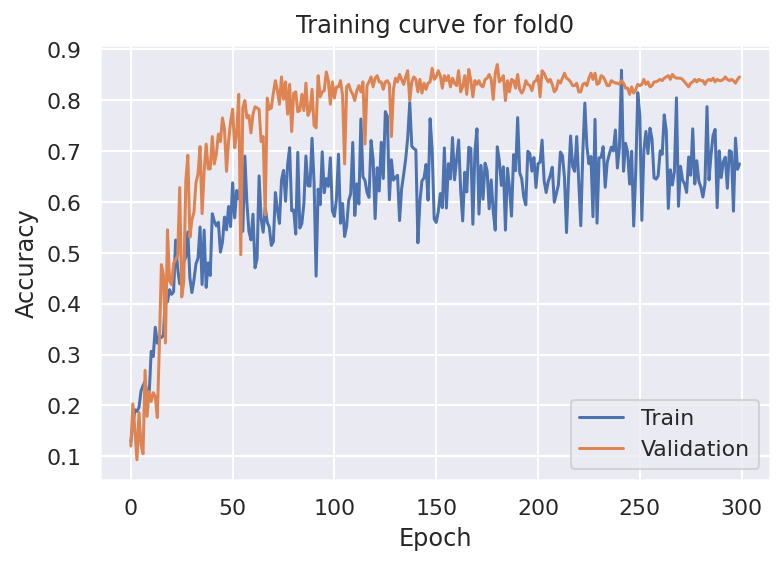

Epoch=0, Train loss=2.33766, Valid loss=2.29750, Train Accuracy=0.13175, Validation Accuracy=0.14634
Epoch=10, Train loss=2.10546, Valid loss=1.94810, Train Accuracy=0.31303, Validation Accuracy=0.28780
Epoch=20, Train loss=1.87250, Valid loss=1.95961, Train Accuracy=0.47133, Validation Accuracy=0.34878
Epoch=30, Train loss=1.79863, Valid loss=1.41313, Train Accuracy=0.52719, Validation Accuracy=0.57561
Epoch=40, Train loss=1.84919, Valid loss=1.46447, Train Accuracy=0.51422, Validation Accuracy=0.60976
Epoch=50, Train loss=1.62325, Valid loss=1.19698, Train Accuracy=0.64638, Validation Accuracy=0.70244
Epoch=60, Train loss=1.95045, Valid loss=1.01354, Train Accuracy=0.46164, Validation Accuracy=0.79268
Epoch=70, Train loss=1.75014, Valid loss=1.20792, Train Accuracy=0.59251, Validation Accuracy=0.76829
Epoch=80, Train loss=1.86786, Valid loss=1.13777, Train Accuracy=0.52339, Validation Accuracy=0.82439
Epoch=90, Train loss=1.58257, Valid loss=1.03442, Train Accuracy=0.65585, Validatio

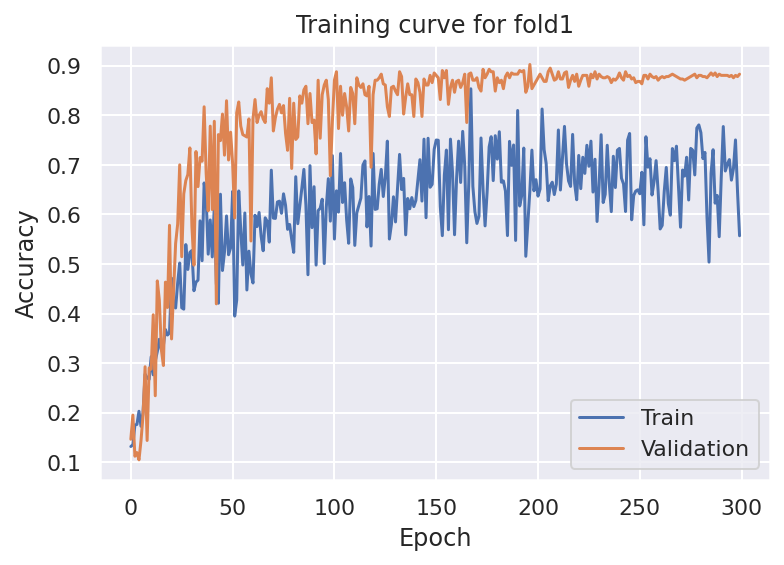

Epoch=0, Train loss=2.32715, Valid loss=2.37025, Train Accuracy=0.13393, Validation Accuracy=0.11951
Epoch=10, Train loss=2.04552, Valid loss=1.88310, Train Accuracy=0.32697, Validation Accuracy=0.30488
Epoch=20, Train loss=2.04102, Valid loss=1.50245, Train Accuracy=0.38581, Validation Accuracy=0.58780
Epoch=30, Train loss=1.73357, Valid loss=1.36185, Train Accuracy=0.57081, Validation Accuracy=0.55122
Epoch=40, Train loss=1.82609, Valid loss=1.41222, Train Accuracy=0.53969, Validation Accuracy=0.69268
Epoch=50, Train loss=1.68563, Valid loss=0.85893, Train Accuracy=0.61221, Validation Accuracy=0.81220
Epoch=60, Train loss=1.79201, Valid loss=1.08080, Train Accuracy=0.54903, Validation Accuracy=0.76098
Epoch=70, Train loss=1.75980, Valid loss=1.16782, Train Accuracy=0.57844, Validation Accuracy=0.63902
Epoch=80, Train loss=1.84272, Valid loss=0.96944, Train Accuracy=0.54028, Validation Accuracy=0.84878
Epoch=90, Train loss=1.73671, Valid loss=0.92212, Train Accuracy=0.59143, Validatio

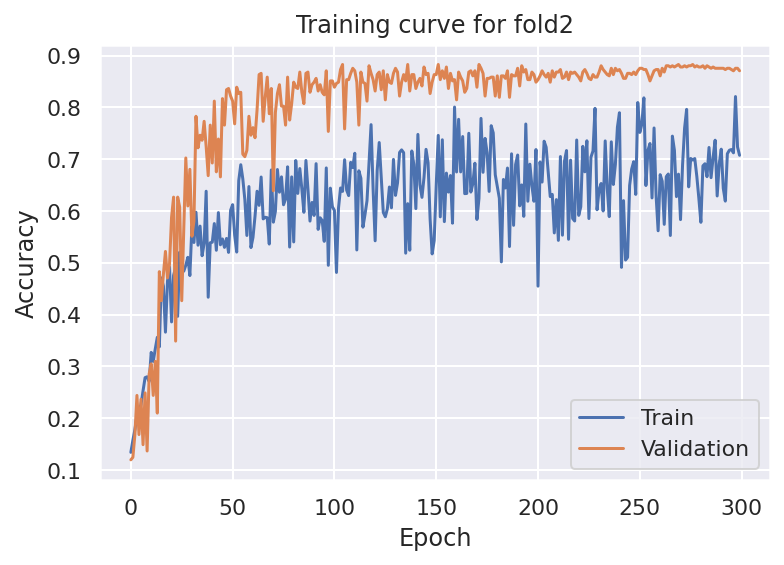

Epoch=0, Train loss=2.32889, Valid loss=2.48213, Train Accuracy=0.13418, Validation Accuracy=0.09756
Epoch=10, Train loss=1.97102, Valid loss=1.78551, Train Accuracy=0.35793, Validation Accuracy=0.38780
Epoch=20, Train loss=1.88268, Valid loss=1.36631, Train Accuracy=0.46431, Validation Accuracy=0.66098
Epoch=30, Train loss=1.95232, Valid loss=1.32553, Train Accuracy=0.45499, Validation Accuracy=0.69024
Epoch=40, Train loss=1.77160, Valid loss=1.02046, Train Accuracy=0.56684, Validation Accuracy=0.79268
Epoch=50, Train loss=1.63612, Valid loss=1.02395, Train Accuracy=0.63594, Validation Accuracy=0.83415
Epoch=60, Train loss=1.63181, Valid loss=1.04981, Train Accuracy=0.64424, Validation Accuracy=0.77317
Epoch=70, Train loss=1.67897, Valid loss=1.03589, Train Accuracy=0.62607, Validation Accuracy=0.71707
Epoch=80, Train loss=1.73096, Valid loss=0.94290, Train Accuracy=0.59118, Validation Accuracy=0.80732
Epoch=90, Train loss=1.47462, Valid loss=0.72794, Train Accuracy=0.69890, Validatio

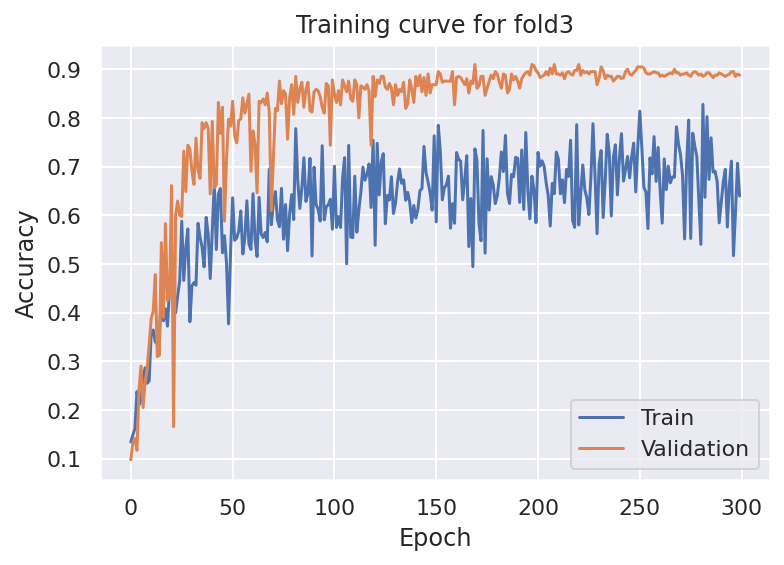

Epoch=0, Train loss=2.34544, Valid loss=2.47802, Train Accuracy=0.12586, Validation Accuracy=0.09046
Epoch=10, Train loss=2.20640, Valid loss=2.14389, Train Accuracy=0.21690, Validation Accuracy=0.18582
Epoch=20, Train loss=2.01047, Valid loss=1.71514, Train Accuracy=0.37564, Validation Accuracy=0.41076
Epoch=30, Train loss=1.92442, Valid loss=1.36202, Train Accuracy=0.47148, Validation Accuracy=0.63570
Epoch=40, Train loss=1.74639, Valid loss=1.68668, Train Accuracy=0.57826, Validation Accuracy=0.55501
Epoch=50, Train loss=1.91908, Valid loss=1.50502, Train Accuracy=0.49767, Validation Accuracy=0.61369
Epoch=60, Train loss=1.52141, Valid loss=1.01555, Train Accuracy=0.66459, Validation Accuracy=0.77262
Epoch=70, Train loss=1.57893, Valid loss=0.92712, Train Accuracy=0.65456, Validation Accuracy=0.81907
Epoch=80, Train loss=1.73645, Valid loss=0.97353, Train Accuracy=0.59260, Validation Accuracy=0.75550
Epoch=90, Train loss=1.68456, Valid loss=0.87605, Train Accuracy=0.61597, Validatio

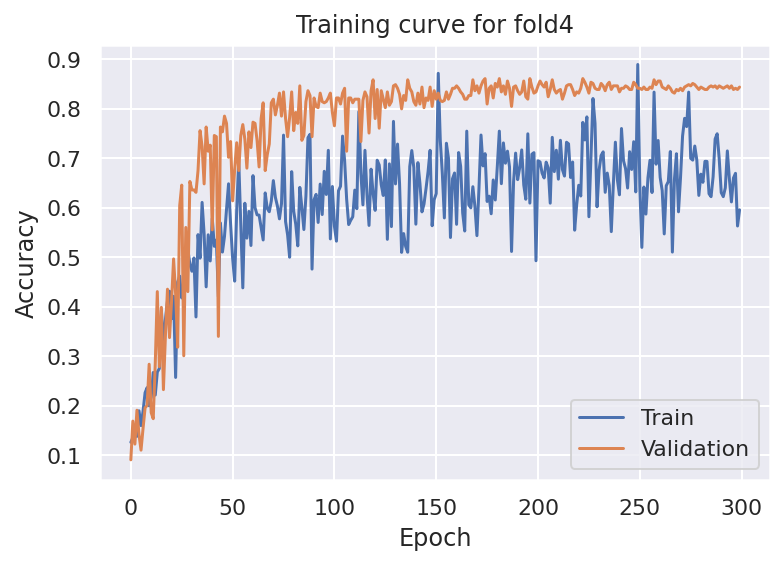

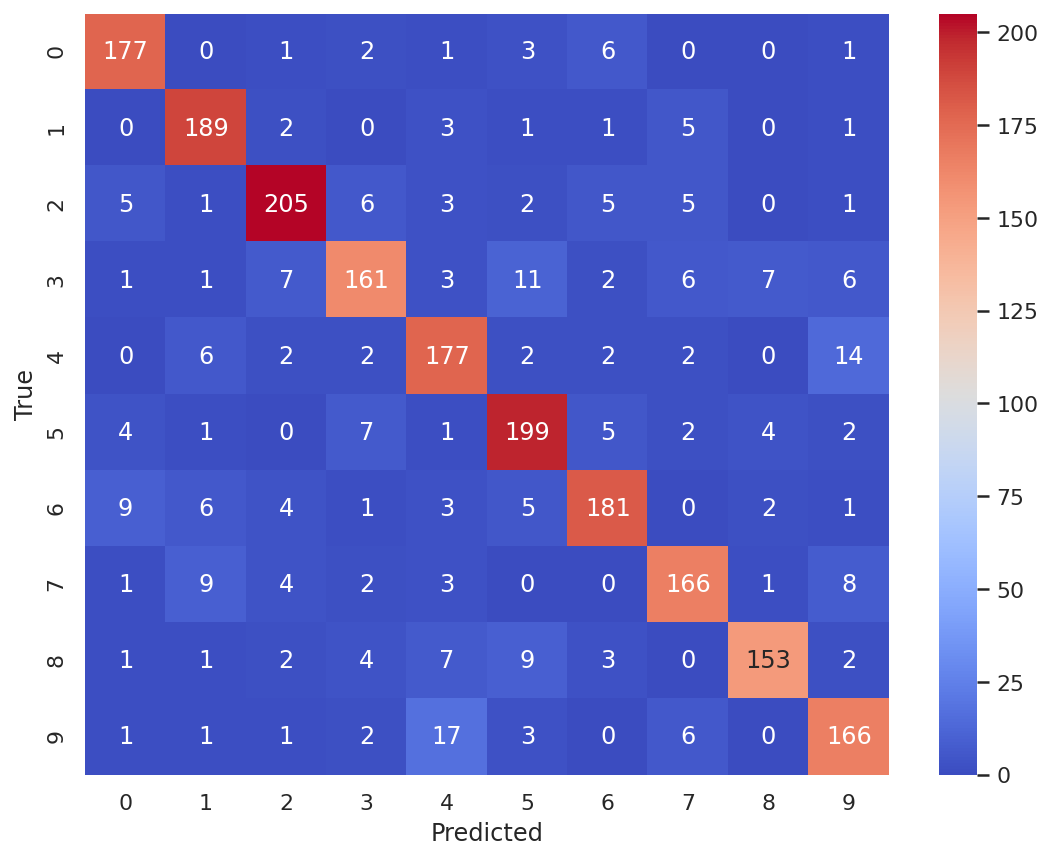

              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91       191
         1.0       0.88      0.94      0.91       202
         2.0       0.90      0.88      0.89       233
         3.0       0.86      0.79      0.82       205
         4.0       0.81      0.86      0.83       207
         5.0       0.85      0.88      0.87       225
         6.0       0.88      0.85      0.87       212
         7.0       0.86      0.86      0.86       194
         8.0       0.92      0.84      0.88       182
         9.0       0.82      0.84      0.83       197

    accuracy                           0.87      2048
   macro avg       0.87      0.87      0.87      2048
weighted avg       0.87      0.87      0.87      2048

CV Accuracy Score=0.8662109375
model=xresnet18, optimizer=adam, epochs=300, lr=0.003, wd=0.0005
CPU times: user 14min 29s, sys: 5min 19s, total: 19min 48s
Wall time: 21min 27s


<IPython.core.display.Javascript object>

In [19]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "xresnet18"
optim_name = "adam"
epochs = 300
lr = 3e-3
wd = 5e-4
oof, targs = run(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

### 2.1

Epoch=0, Train loss=2.30076, Valid loss=2.30234, Train Accuracy=0.09935, Validation Accuracy=0.11736
Epoch=10, Train loss=2.07526, Valid loss=1.84267, Train Accuracy=0.35612, Validation Accuracy=0.35452
Epoch=20, Train loss=1.81170, Valid loss=1.20688, Train Accuracy=0.54470, Validation Accuracy=0.71638
Epoch=30, Train loss=1.73836, Valid loss=1.03295, Train Accuracy=0.60782, Validation Accuracy=0.73594
Epoch=40, Train loss=1.50221, Valid loss=0.91757, Train Accuracy=0.70393, Validation Accuracy=0.81418
Epoch=50, Train loss=1.60328, Valid loss=0.88679, Train Accuracy=0.65655, Validation Accuracy=0.84841
Epoch=60, Train loss=1.43831, Valid loss=0.74254, Train Accuracy=0.72814, Validation Accuracy=0.86797
Epoch=70, Train loss=1.39463, Valid loss=0.72903, Train Accuracy=0.74854, Validation Accuracy=0.86553
Epoch=80, Train loss=1.57751, Valid loss=0.96368, Train Accuracy=0.67622, Validation Accuracy=0.78484
Epoch=90, Train loss=1.54977, Valid loss=0.83655, Train Accuracy=0.67294, Validatio

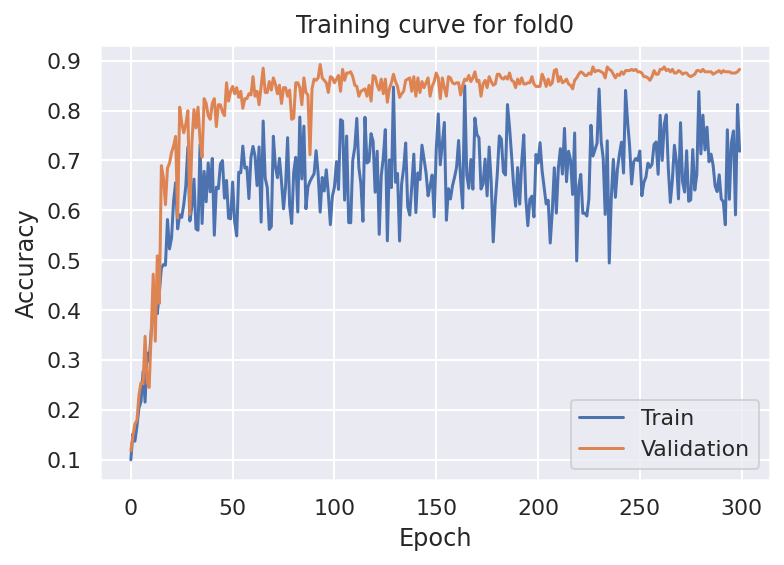

Epoch=0, Train loss=2.29966, Valid loss=2.30089, Train Accuracy=0.11040, Validation Accuracy=0.09512
Epoch=10, Train loss=2.11328, Valid loss=1.78051, Train Accuracy=0.31257, Validation Accuracy=0.42927
Epoch=20, Train loss=2.01957, Valid loss=1.20742, Train Accuracy=0.41699, Validation Accuracy=0.67561
Epoch=30, Train loss=1.65732, Valid loss=1.00501, Train Accuracy=0.62681, Validation Accuracy=0.77073
Epoch=40, Train loss=1.65323, Valid loss=0.81354, Train Accuracy=0.63976, Validation Accuracy=0.84146
Epoch=50, Train loss=1.51581, Valid loss=0.92749, Train Accuracy=0.69853, Validation Accuracy=0.83415
Epoch=60, Train loss=1.24794, Valid loss=0.69664, Train Accuracy=0.78960, Validation Accuracy=0.87073
Epoch=70, Train loss=1.54907, Valid loss=0.78084, Train Accuracy=0.68653, Validation Accuracy=0.87561
Epoch=80, Train loss=1.62674, Valid loss=0.87294, Train Accuracy=0.64031, Validation Accuracy=0.85610
Epoch=90, Train loss=1.45281, Valid loss=0.81187, Train Accuracy=0.71143, Validatio

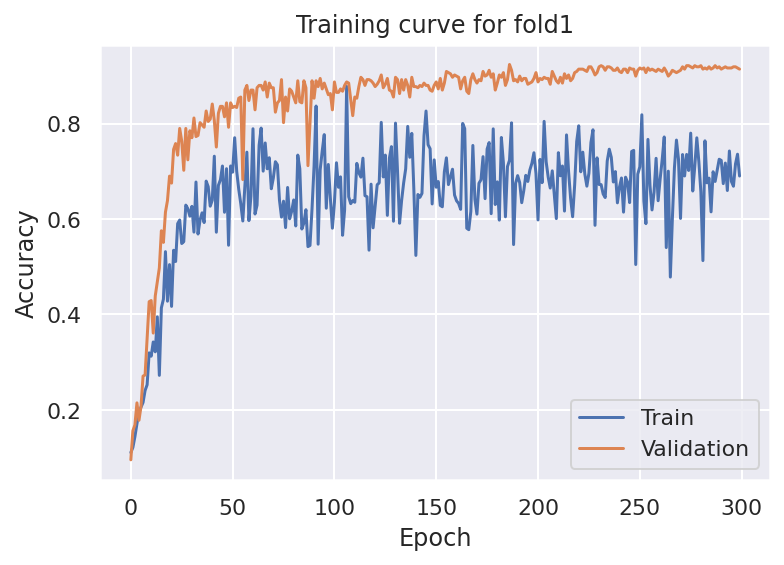

Epoch=0, Train loss=2.30134, Valid loss=2.30435, Train Accuracy=0.10594, Validation Accuracy=0.07317
Epoch=10, Train loss=2.07524, Valid loss=1.76582, Train Accuracy=0.35320, Validation Accuracy=0.44634
Epoch=20, Train loss=1.58541, Valid loss=1.04198, Train Accuracy=0.63733, Validation Accuracy=0.70244
Epoch=30, Train loss=1.94636, Valid loss=1.31251, Train Accuracy=0.50685, Validation Accuracy=0.65610
Epoch=40, Train loss=1.08235, Valid loss=0.67760, Train Accuracy=0.84069, Validation Accuracy=0.79512
Epoch=50, Train loss=1.71125, Valid loss=1.15511, Train Accuracy=0.59835, Validation Accuracy=0.81707
Epoch=60, Train loss=1.47706, Valid loss=0.80346, Train Accuracy=0.70827, Validation Accuracy=0.82439
Epoch=70, Train loss=1.65452, Valid loss=0.89663, Train Accuracy=0.65000, Validation Accuracy=0.82683
Epoch=80, Train loss=1.40775, Valid loss=0.74082, Train Accuracy=0.73010, Validation Accuracy=0.85854
Epoch=90, Train loss=1.56417, Valid loss=0.95418, Train Accuracy=0.68005, Validatio

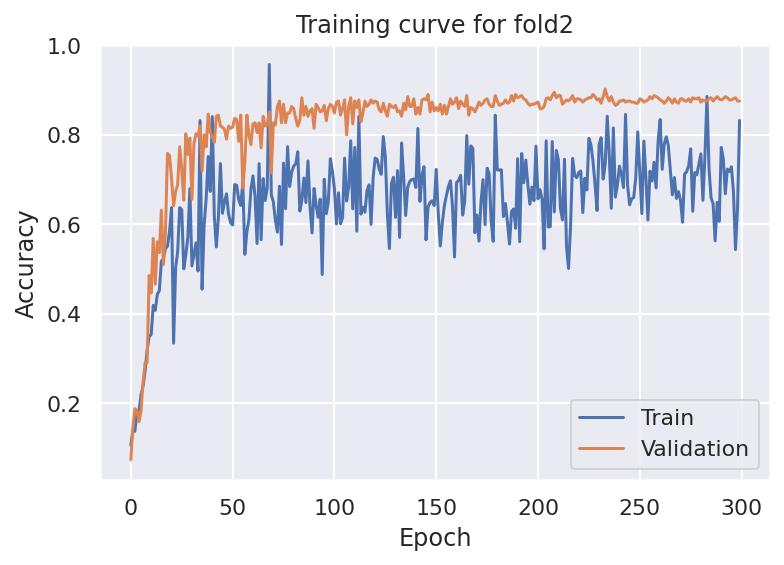

Epoch=0, Train loss=2.29816, Valid loss=2.30367, Train Accuracy=0.10745, Validation Accuracy=0.10000
Epoch=10, Train loss=2.17684, Valid loss=1.69349, Train Accuracy=0.29388, Validation Accuracy=0.42195
Epoch=20, Train loss=1.85913, Valid loss=1.33453, Train Accuracy=0.50817, Validation Accuracy=0.69756
Epoch=30, Train loss=1.64252, Valid loss=0.87581, Train Accuracy=0.63202, Validation Accuracy=0.81220
Epoch=40, Train loss=1.53075, Valid loss=0.87463, Train Accuracy=0.68522, Validation Accuracy=0.84878
Epoch=50, Train loss=1.58395, Valid loss=0.74812, Train Accuracy=0.66358, Validation Accuracy=0.86585
Epoch=60, Train loss=1.48405, Valid loss=0.81297, Train Accuracy=0.70265, Validation Accuracy=0.85610
Epoch=70, Train loss=1.43361, Valid loss=0.66330, Train Accuracy=0.73089, Validation Accuracy=0.89512
Epoch=80, Train loss=1.46029, Valid loss=0.66259, Train Accuracy=0.72499, Validation Accuracy=0.90244
Epoch=90, Train loss=1.75041, Valid loss=0.88227, Train Accuracy=0.59045, Validatio

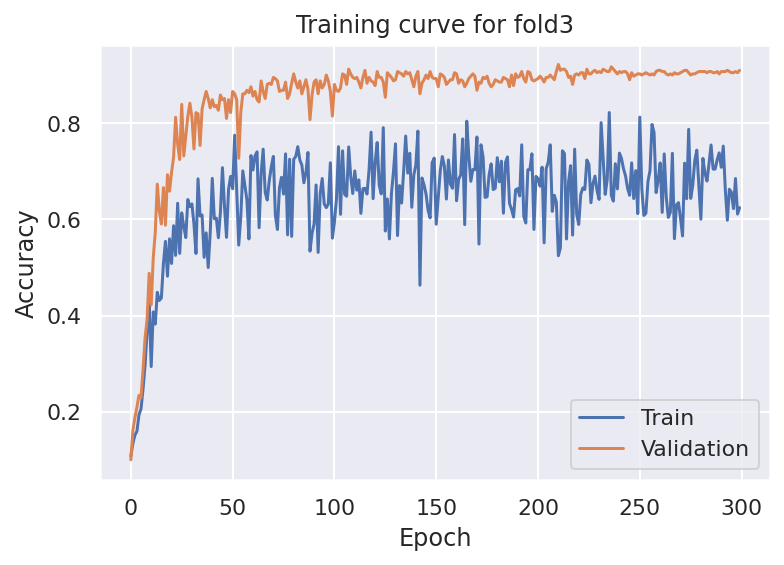

Epoch=0, Train loss=2.29951, Valid loss=2.30338, Train Accuracy=0.10307, Validation Accuracy=0.12225
Epoch=10, Train loss=2.11758, Valid loss=1.96216, Train Accuracy=0.31204, Validation Accuracy=0.31296
Epoch=20, Train loss=1.89829, Valid loss=1.47207, Train Accuracy=0.50408, Validation Accuracy=0.60880
Epoch=30, Train loss=1.86683, Valid loss=1.03429, Train Accuracy=0.52957, Validation Accuracy=0.74817
Epoch=40, Train loss=1.35234, Valid loss=0.88268, Train Accuracy=0.75202, Validation Accuracy=0.79707
Epoch=50, Train loss=1.51401, Valid loss=0.95339, Train Accuracy=0.68874, Validation Accuracy=0.80685
Epoch=60, Train loss=1.81811, Valid loss=1.06257, Train Accuracy=0.55135, Validation Accuracy=0.84841
Epoch=70, Train loss=1.27582, Valid loss=0.82479, Train Accuracy=0.78589, Validation Accuracy=0.83374
Epoch=80, Train loss=1.74222, Valid loss=0.96431, Train Accuracy=0.61081, Validation Accuracy=0.81663
Epoch=90, Train loss=1.68126, Valid loss=0.99217, Train Accuracy=0.61887, Validatio

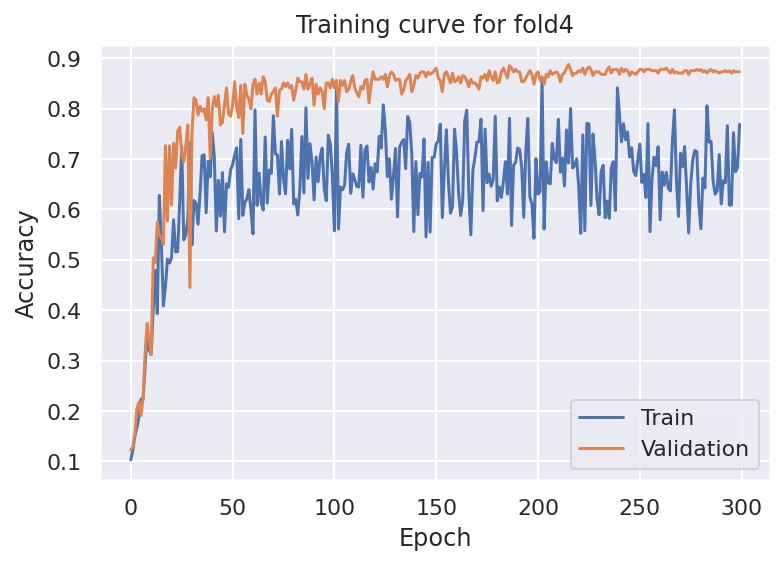

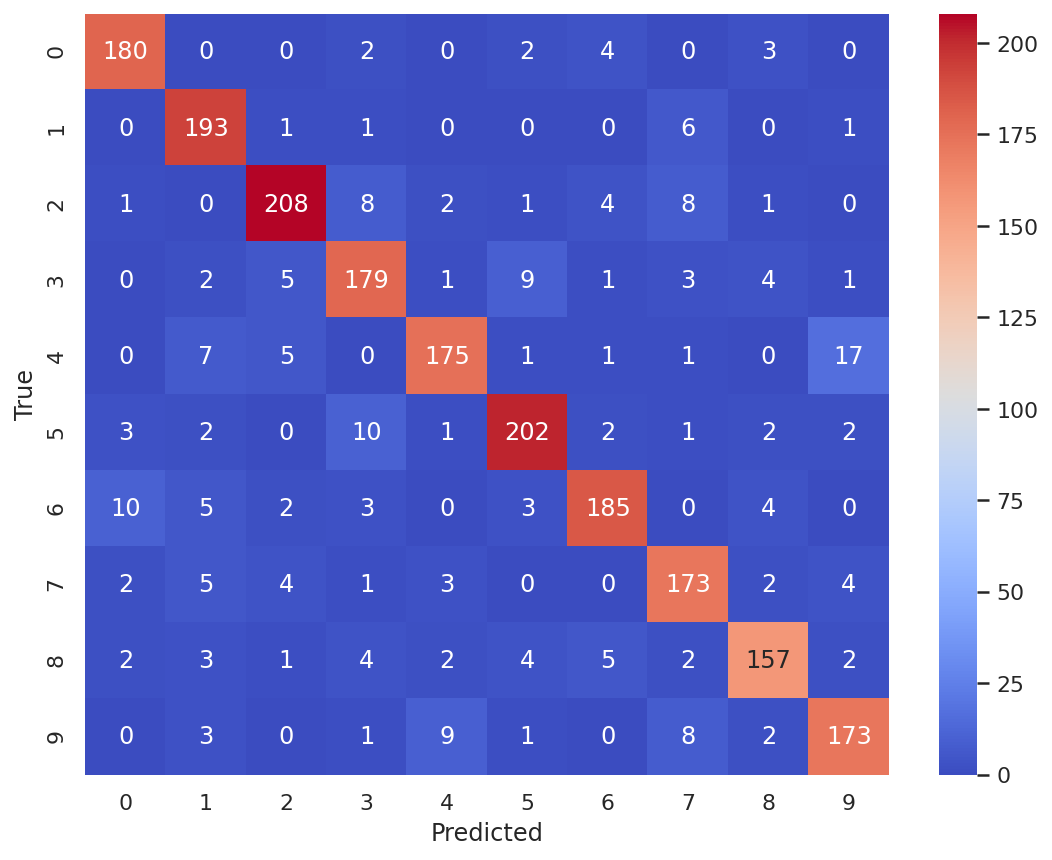

              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93       191
         1.0       0.88      0.96      0.91       202
         2.0       0.92      0.89      0.91       233
         3.0       0.86      0.87      0.86       205
         4.0       0.91      0.85      0.88       207
         5.0       0.91      0.90      0.90       225
         6.0       0.92      0.87      0.89       212
         7.0       0.86      0.89      0.87       194
         8.0       0.90      0.86      0.88       182
         9.0       0.86      0.88      0.87       197

    accuracy                           0.89      2048
   macro avg       0.89      0.89      0.89      2048
weighted avg       0.89      0.89      0.89      2048

CV Accuracy Score=0.89111328125
model=xresnet34, optimizer=radam, epochs=300, lr=0.003, wd=0.0005
CPU times: user 23min 8s, sys: 3min 21s, total: 26min 30s
Wall time: 28min 18s


In [144]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "xresnet34"
optim_name = "radam"
epochs = 300
lr = 3e-3
wd = 5e-4
oof, targs = run(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

### 2.2

Epoch=0, Train loss=2.30972, Valid loss=2.26392, Train Accuracy=0.13060, Validation Accuracy=0.15403
Epoch=10, Train loss=2.22823, Valid loss=2.29173, Train Accuracy=0.18474, Validation Accuracy=0.11247
Epoch=20, Train loss=2.23250, Valid loss=2.15401, Train Accuracy=0.20003, Validation Accuracy=0.22005
Epoch=30, Train loss=2.11352, Valid loss=2.17799, Train Accuracy=0.30900, Validation Accuracy=0.17848
Epoch=40, Train loss=2.04760, Valid loss=1.96896, Train Accuracy=0.36416, Validation Accuracy=0.28117
Epoch=50, Train loss=2.07961, Valid loss=1.72177, Train Accuracy=0.37295, Validation Accuracy=0.40342
Epoch=60, Train loss=1.92052, Valid loss=1.93368, Train Accuracy=0.45475, Validation Accuracy=0.34474
Epoch=70, Train loss=1.97422, Valid loss=1.39848, Train Accuracy=0.44560, Validation Accuracy=0.58435
Epoch=80, Train loss=2.00302, Valid loss=1.53875, Train Accuracy=0.42437, Validation Accuracy=0.50611
Epoch=90, Train loss=1.87103, Valid loss=1.36629, Train Accuracy=0.50120, Validatio

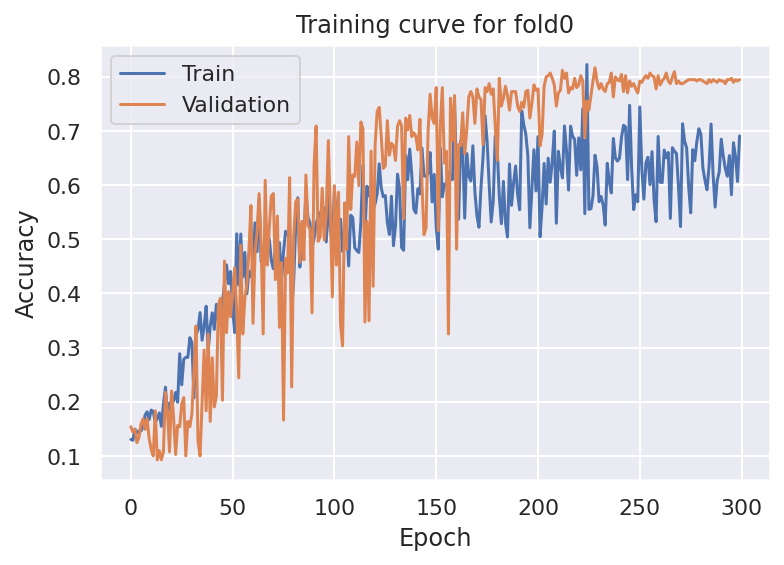

Epoch=0, Train loss=2.33632, Valid loss=2.28212, Train Accuracy=0.10421, Validation Accuracy=0.14634
Epoch=10, Train loss=2.27364, Valid loss=2.73230, Train Accuracy=0.14188, Validation Accuracy=0.11463
Epoch=20, Train loss=2.21785, Valid loss=2.18092, Train Accuracy=0.18463, Validation Accuracy=0.17561
Epoch=30, Train loss=2.07560, Valid loss=4.68840, Train Accuracy=0.28087, Validation Accuracy=0.13171
Epoch=40, Train loss=2.05098, Valid loss=1.86318, Train Accuracy=0.31445, Validation Accuracy=0.31463
Epoch=50, Train loss=1.91535, Valid loss=1.65869, Train Accuracy=0.42769, Validation Accuracy=0.39512
Epoch=60, Train loss=1.93539, Valid loss=2.06660, Train Accuracy=0.41972, Validation Accuracy=0.32683
Epoch=70, Train loss=1.98156, Valid loss=1.73110, Train Accuracy=0.43315, Validation Accuracy=0.46829
Epoch=80, Train loss=1.58328, Valid loss=1.49399, Train Accuracy=0.60066, Validation Accuracy=0.46098
Epoch=90, Train loss=1.70488, Valid loss=1.46733, Train Accuracy=0.57439, Validatio

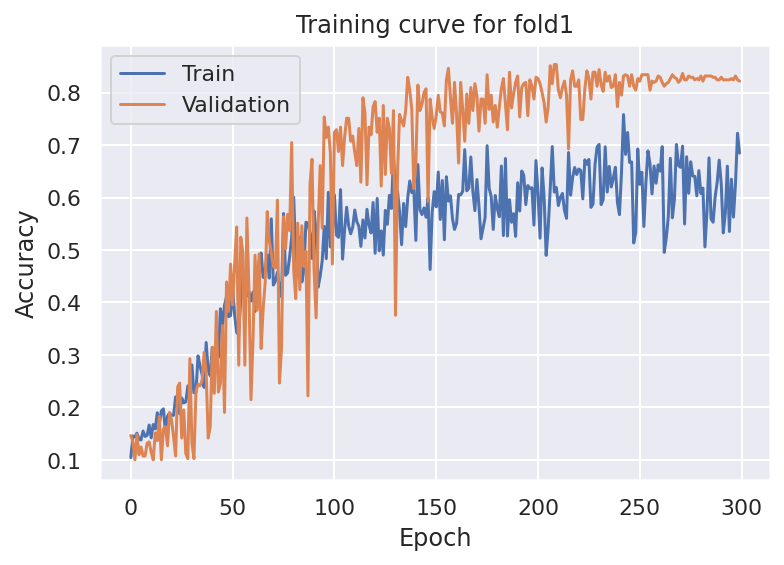

Epoch=0, Train loss=2.33660, Valid loss=2.28130, Train Accuracy=0.11398, Validation Accuracy=0.15122


KeyboardInterrupt: 

In [31]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "xresnet50"
optim_name = "adam"
epochs = 300
lr = 3e-3
wd = 5e-4
oof, targs = run(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

### 2.3

Epoch=0, Train loss=2.35517, Valid loss=2.32936, Train Accuracy=0.10970, Validation Accuracy=0.11491
Epoch=10, Train loss=1.72555, Valid loss=2.05694, Train Accuracy=0.54622, Validation Accuracy=0.36675
Epoch=20, Train loss=1.67966, Valid loss=1.13644, Train Accuracy=0.60237, Validation Accuracy=0.66993
Epoch=30, Train loss=1.52753, Valid loss=0.99626, Train Accuracy=0.67548, Validation Accuracy=0.72127
Epoch=40, Train loss=1.52771, Valid loss=0.82502, Train Accuracy=0.68562, Validation Accuracy=0.82885
Epoch=50, Train loss=1.61055, Valid loss=1.07206, Train Accuracy=0.65382, Validation Accuracy=0.77995
Epoch=60, Train loss=1.64688, Valid loss=0.98738, Train Accuracy=0.62829, Validation Accuracy=0.81418
Epoch=70, Train loss=1.56667, Valid loss=1.05414, Train Accuracy=0.68425, Validation Accuracy=0.77262
Epoch=80, Train loss=1.45157, Valid loss=0.79319, Train Accuracy=0.71332, Validation Accuracy=0.83374
Epoch=90, Train loss=1.64927, Valid loss=0.99775, Train Accuracy=0.64354, Validatio

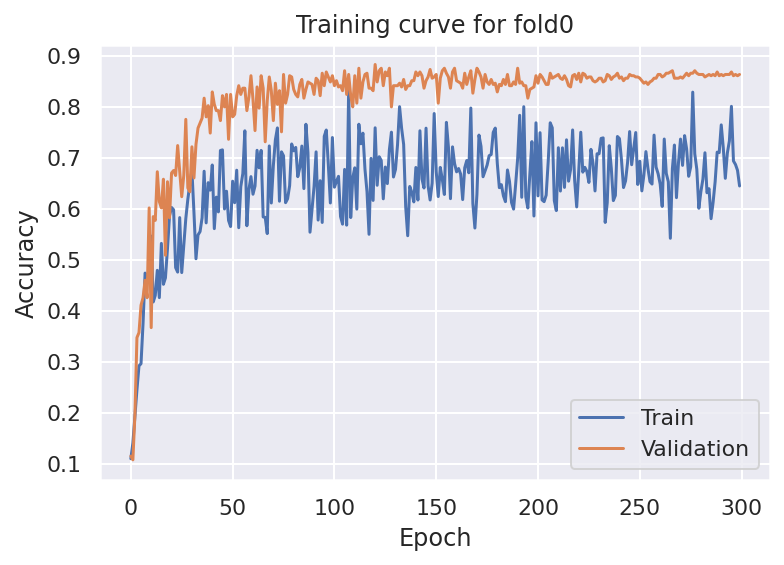

Epoch=0, Train loss=2.31938, Valid loss=2.37275, Train Accuracy=0.12461, Validation Accuracy=0.08049
Epoch=10, Train loss=2.00180, Valid loss=1.37054, Train Accuracy=0.40533, Validation Accuracy=0.56829
Epoch=20, Train loss=1.76217, Valid loss=0.97495, Train Accuracy=0.53819, Validation Accuracy=0.74634
Epoch=30, Train loss=1.71767, Valid loss=0.95065, Train Accuracy=0.59490, Validation Accuracy=0.73659
Epoch=40, Train loss=1.54488, Valid loss=0.85297, Train Accuracy=0.68003, Validation Accuracy=0.82927
Epoch=50, Train loss=1.42128, Valid loss=0.66999, Train Accuracy=0.72403, Validation Accuracy=0.87317
Epoch=60, Train loss=1.61415, Valid loss=1.03435, Train Accuracy=0.65282, Validation Accuracy=0.84146
Epoch=70, Train loss=1.78676, Valid loss=1.05447, Train Accuracy=0.57042, Validation Accuracy=0.83659
Epoch=80, Train loss=1.42817, Valid loss=0.85214, Train Accuracy=0.73634, Validation Accuracy=0.84146
Epoch=90, Train loss=1.66254, Valid loss=0.90792, Train Accuracy=0.62425, Validatio

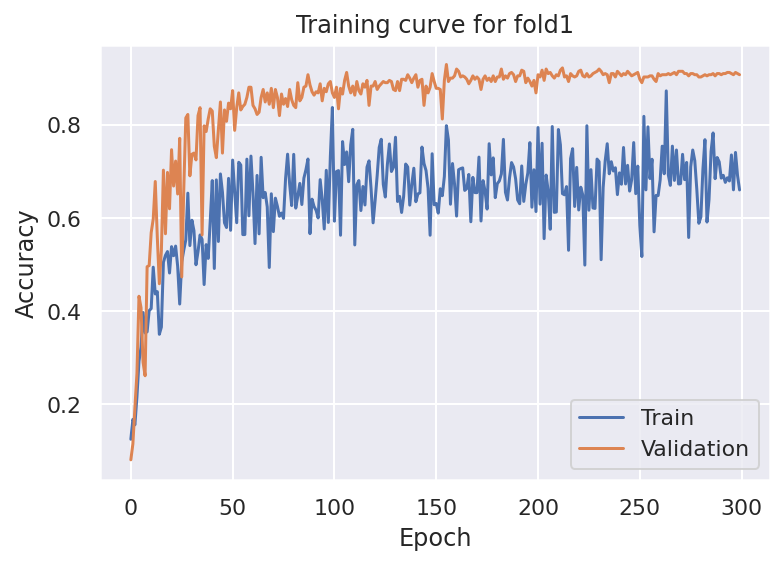

Epoch=0, Train loss=2.30815, Valid loss=2.35861, Train Accuracy=0.12494, Validation Accuracy=0.12439
Epoch=10, Train loss=2.04853, Valid loss=1.85992, Train Accuracy=0.37071, Validation Accuracy=0.39512
Epoch=20, Train loss=1.83373, Valid loss=1.25744, Train Accuracy=0.52042, Validation Accuracy=0.68780
Epoch=30, Train loss=1.84516, Valid loss=1.02852, Train Accuracy=0.54204, Validation Accuracy=0.72683
Epoch=40, Train loss=1.69837, Valid loss=0.91242, Train Accuracy=0.60730, Validation Accuracy=0.81951
Epoch=50, Train loss=1.71048, Valid loss=0.96037, Train Accuracy=0.61870, Validation Accuracy=0.81463
Epoch=60, Train loss=1.56498, Valid loss=1.02228, Train Accuracy=0.67822, Validation Accuracy=0.79268
Epoch=70, Train loss=1.70631, Valid loss=0.94525, Train Accuracy=0.61762, Validation Accuracy=0.83415
Epoch=80, Train loss=1.45666, Valid loss=0.92911, Train Accuracy=0.72283, Validation Accuracy=0.81707
Epoch=90, Train loss=1.66097, Valid loss=1.09972, Train Accuracy=0.63432, Validatio

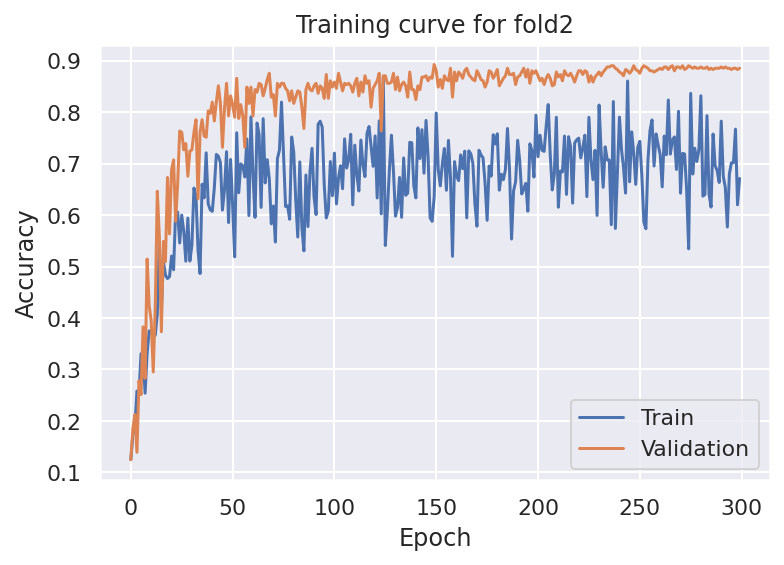

Epoch=0, Train loss=2.32910, Valid loss=2.43141, Train Accuracy=0.12507, Validation Accuracy=0.17805
Epoch=10, Train loss=1.84958, Valid loss=1.32479, Train Accuracy=0.49804, Validation Accuracy=0.58780
Epoch=20, Train loss=2.02768, Valid loss=1.56428, Train Accuracy=0.42464, Validation Accuracy=0.54390
Epoch=30, Train loss=1.59250, Valid loss=0.81981, Train Accuracy=0.65323, Validation Accuracy=0.82439
Epoch=40, Train loss=1.90733, Valid loss=0.99491, Train Accuracy=0.48971, Validation Accuracy=0.86585
Epoch=50, Train loss=1.64768, Valid loss=1.38485, Train Accuracy=0.62515, Validation Accuracy=0.63902
Epoch=60, Train loss=1.77088, Valid loss=0.90978, Train Accuracy=0.58831, Validation Accuracy=0.85854
Epoch=70, Train loss=1.54641, Valid loss=0.85490, Train Accuracy=0.68111, Validation Accuracy=0.84390
Epoch=80, Train loss=1.66983, Valid loss=0.80789, Train Accuracy=0.62792, Validation Accuracy=0.86585
Epoch=90, Train loss=1.47669, Valid loss=0.79459, Train Accuracy=0.70735, Validatio

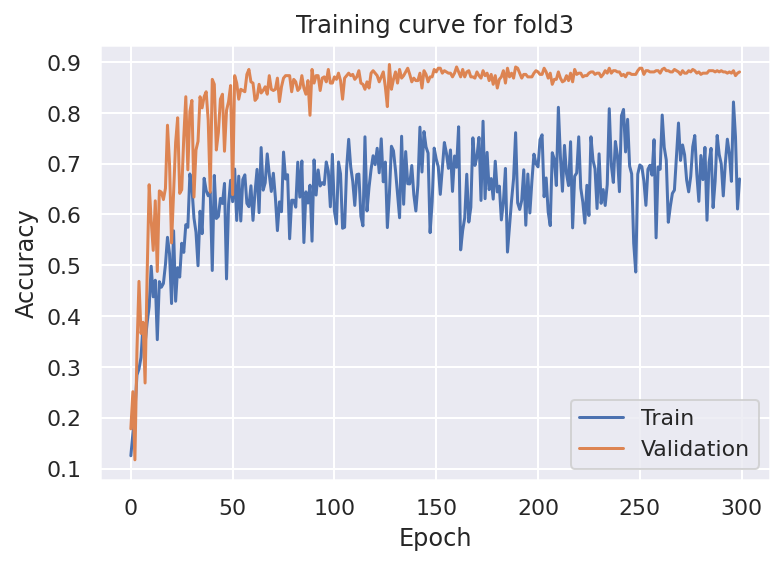

Epoch=0, Train loss=2.35794, Valid loss=2.32036, Train Accuracy=0.11107, Validation Accuracy=0.10513
Epoch=10, Train loss=1.87605, Valid loss=1.50185, Train Accuracy=0.47366, Validation Accuracy=0.46455
Epoch=20, Train loss=1.79655, Valid loss=1.42209, Train Accuracy=0.54984, Validation Accuracy=0.54768
Epoch=30, Train loss=1.57688, Valid loss=1.06954, Train Accuracy=0.66760, Validation Accuracy=0.73839
Epoch=40, Train loss=1.66518, Valid loss=1.18642, Train Accuracy=0.62974, Validation Accuracy=0.69927
Epoch=50, Train loss=1.70429, Valid loss=0.98014, Train Accuracy=0.61344, Validation Accuracy=0.78240
Epoch=60, Train loss=1.29119, Valid loss=0.72352, Train Accuracy=0.76771, Validation Accuracy=0.85086
Epoch=70, Train loss=1.48967, Valid loss=0.77231, Train Accuracy=0.69410, Validation Accuracy=0.86064
Epoch=80, Train loss=1.62475, Valid loss=1.05956, Train Accuracy=0.64404, Validation Accuracy=0.80440
Epoch=90, Train loss=1.50632, Valid loss=0.84992, Train Accuracy=0.69393, Validatio

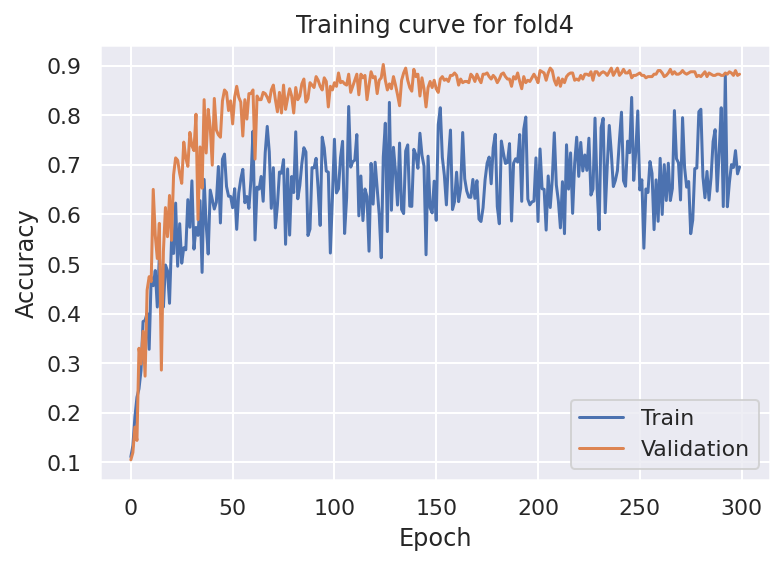

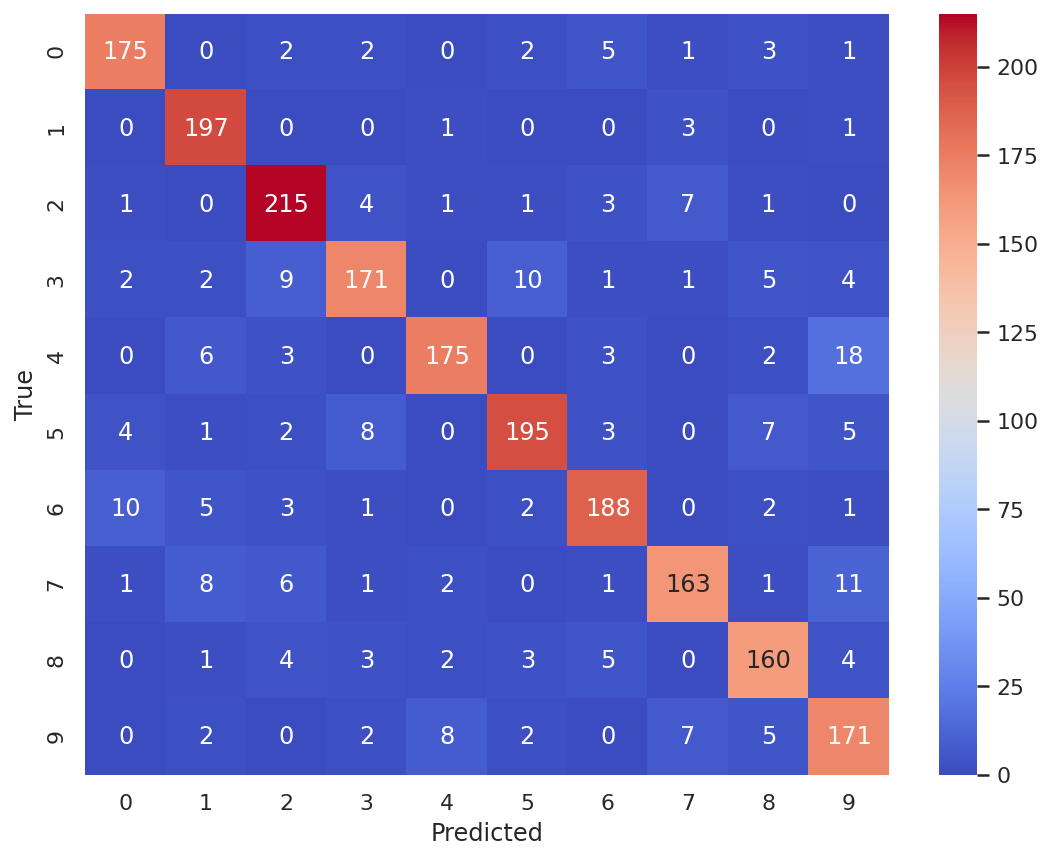

              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91       191
         1.0       0.89      0.98      0.93       202
         2.0       0.88      0.92      0.90       233
         3.0       0.89      0.83      0.86       205
         4.0       0.93      0.85      0.88       207
         5.0       0.91      0.87      0.89       225
         6.0       0.90      0.89      0.89       212
         7.0       0.90      0.84      0.87       194
         8.0       0.86      0.88      0.87       182
         9.0       0.79      0.87      0.83       197

    accuracy                           0.88      2048
   macro avg       0.88      0.88      0.88      2048
weighted avg       0.89      0.88      0.88      2048

CV Accuracy Score=0.8837890625
model=xresnet50, optimizer=radam, epochs=300, lr=0.003, wd=0.0005
CPU times: user 42min 18s, sys: 5min 5s, total: 47min 23s
Wall time: 49min 2s


In [15]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "xresnet50"
optim_name = "radam"
epochs = 300
lr = 3e-3
wd = 5e-4
oof, targs = run(model_name, optim_name, epochs, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")